# Notebook for compiling VGP level data of Keweenawan Track


- this notebook is modified from the Keweenawan Track compilation work of Swanson-Hysell et al., 2019 (http://dx.doi.org/10.1130/B31944.1)

# Import libraries for data analysis

This code blocks imports necessary libraries and defines functions that will be used in the data analysis below. The code below  the pmag.py and ipmag.py modules of the the PmagPy software package (https://github.com/PmagPy/PmagPy). The other modules are currently included with standard scientific python distributions.

In [1]:
import pmagpy.pmag as pmag
import pmagpy.ipmag as ipmag

import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
from IPython.core.display import HTML
import numpy as np
import scipy as sp
from scipy import special
import scipy.stats as st
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

This notebook runs with figures inline (instead of opening up in another window) that are in svg format by executing these commands:

In [2]:
%matplotlib inline
%config InlineBackend.figure_formats = 'retina'

Same as in Swanson-Hysellet al., 2019, let's create an empty dataframe that will be populated with pole means called 'pole_means'.

<b>PoleName | SLat | SLon | PLat | Plon | A95 | PolarityZone | PmagRef | AgeNominal | AgeLower | AgeUpper | AgeInfo | Q  </b>

<b>Pole_name</b> = Name of pole which corresponds to volcanic group <br>
<b>SLat</b> = Sample area decimal latitude (e.g. -56.2)<br>
<b>SLon</b> = Sample area decimal longitude (e.g. 134.8)<br>
<b>PLat</b> = Palaeomagnetic pole decimal latitude (e.g. -56.2)<br>
<b>PLon</b> = Palaeomagnetic pole decimal longitude (e.g. 134.8)<br>
<b>A95</b> = 95% confidence limit on pole in degrees (e.g. 6.2)<br>
<b>k</b> = Fisher precision parameter (e.g. 42.5)<br>
<b>N</b> = Number of VGPs used to calculate the mean<br>
<b>PolarityZone</b> = Assigned polarity zone<br>
<b>AgeNominal</b> = Mean / representative age of sampled formation (e.g. 1105.1)<br>
<b>AgeLower</b> = Estimate lower bound on age uncertainty (e.g. 1103.2)<br>
<b>AgeUpper</b> = Estimate upper bound on age uncertainty (e.g. 1107.4)<br>
<b>Gaussian_2sigma</b> = 2sigma error if Gaussian Distribution is to be used<br>
<b>GaussianOrUniform</b> = Distribution type used for Bayesian inversion<br>
<b>Q</b> = Van der Voo quality criteria (0 - 7)<br>


Because we are using MagIC format data files, we will also concatenate all site level data into a single dataframe for bootstrap resampling of VGP data and construct a VGP-based APWP. 

In [3]:
pole_means = pd.DataFrame(columns=['PoleName','SLat','SLon','PLat','PLon',
                                   'A95','K','N','PolarityZone','PmagRef',
                                   'AgeNominal','AgeLower','AgeUpper',
                                   'AgeInfo','AgeRef','Gaussian_2sigma',
                                   'GaussianOrUniform','Q','color'])

# Data compilation by volcanic group

## Osler Volcanic Group

### Import Halls (1974) data

In [4]:
%%capture
ipmag.download_magic('Halls1974.txt',
                     dir_path='../data/pmag_compiled/Halls1974',
                     input_dir_path='../data/pmag_compiled/Halls1974',
                     overwrite=True,print_progress=False,data_model=3.0)
Halls1974_sites = pd.read_csv('../data/pmag_compiled/Halls1974/sites.txt',sep='\t',header=1)
Halls1974_sites['citations'] = 'Halls, 1974'

In [5]:
# use sample n and dir_k to calculate dir_alpha95
Halls1974_sites['dir_alpha95'] = 140/np.sqrt(Halls1974_sites['dir_n_samples']*Halls1974_sites['dir_k'])

We are interested in using tilt-corrected data so will filter the DataFrame such that only data with dir_tilt_correction of 100 are included. We also wish to consider data from reversed and normal flows separately so will create DataFrames for each polarity.

In [6]:
Halls1974_sites_tc = Halls1974_sites[Halls1974_sites['dir_tilt_correction']==100]
Halls1974_sites_r = Halls1974_sites_tc[Halls1974_sites_tc['location']=='Osler Volcanics, Nipigon Strait, Lower Reversed']
Halls1974_sites_n = Halls1974_sites_tc[Halls1974_sites_tc['location']=='Osler Volcanics, Nipigon Strait, Upper Normal']

In [7]:
# assign ages to Halls 1974 sites
Halls1974_sites_r['age'] = 1105.0
Halls1974_sites_r['age_high'] = 1100.0
Halls1974_sites_r['age_low'] = 1103.0
Halls1974_sites_r['age_unit'] = 'Ma'

### Import Swanson-Hysell et al. (2014b) data

In [8]:
%%capture
ipmag.download_magic('magic_contribution_11088_model3.txt',
                     dir_path='../data/pmag_compiled/Swanson-Hysell2014b',
                     input_dir_path='../data/pmag_compiled/Swanson-Hysell2014b',
                     overwrite=True,print_progress=False,data_model=3.0)
SH2014_sites = pd.read_csv('../data/pmag_compiled/Swanson-Hysell2014b/sites.txt',sep='\t',header=1)
SH2014_sites['citations'] = 'Swanson-Hysell et al. 2014'
# filter out the rows with empty direction values
SH2014_sites = SH2014_sites[~SH2014_sites['dir_dec'].isna()]

In [9]:
# use sample n and dir_alpha95 to calculate dir_k
SH2014_sites['dir_n_samples'] = SH2014_sites['dir_n_specimens']
SH2014_sites['dir_k'] = 140**2/SH2014_sites['dir_alpha95']**2/SH2014_sites['dir_n_specimens']
SH2014_sites.head()

,age,age_high,age_low,age_unit,bed_dip,bed_dip_direction,citations,description,dir_alpha95,dir_dec,dir_inc,dir_n_specimens,geologic_classes,geologic_types,height,lat,lithologies,location,lon,method_codes,site,vgp_lat,vgp_lon,dir_n_samples,dir_k
1,1106.0,1110.0,1103.0,Ma,NaN,NaN,Swanson-Hysell et al. 2014,SI1(11.8 to 26.4),2.7,79.7,-70.5,7.0,NaN,NaN,11.8,48.8122,NaN,Simpson Island,272.3380,DE-FM:LP-DC4:LP-DIR-AF,SI1(11.8 to 26.4),33.1,229.6,7.0,384.087791
3,1106.0,1110.0,1103.0,Ma,NaN,NaN,Swanson-Hysell et al. 2014,SI1(116.3 to 118.8),6.4,74.1,-70.3,6.0,NaN,NaN,116.3,48.8062,NaN,Simpson Island,272.3366,DE-FM:LP-DC4:LP-DIR-AF,SI1(116.3 to 118.8),30.4,231.8,6.0,79.752604
5,1106.0,1110.0,1103.0,Ma,NaN,NaN,Swanson-Hysell et al. 2014,SI1(119.7 to 122.1),6.8,87.5,-68.9,5.0,NaN,NaN,119.7,48.8060,NaN,Simpson Island,272.3366,DE-FM:LP-DC4:LP-DIR-AF,SI1(119.7 to 122.1),35.3,223.9,5.0,84.775087
7,1106.0,1110.0,1103.0,Ma,NaN,NaN,Swanson-Hysell et al. 2014,SI1(122.1 to 123.7),4.9,75.7,-69.1,6.0,NaN,NaN,122.1,48.8058,NaN,Simpson Island,272.3367,DE-FM:LP-DC4:LP-DIR-AF,SI1(122.1 to 123.7),30.0,229.6,6.0,136.054422
9,1106.0,1110.0,1103.0,Ma,NaN,NaN,Swanson-Hysell et al. 2014,SI1(28.3 to 29.2),3.9,109.8,-66.8,7.0,NaN,NaN,28.3,48.8107,NaN,Simpson Island,272.3377,DE-FM:LP-DC4:LP-DIR-AF,SI1(28.3 to 29.2),45.8,210.9,7.0,184.089415


Split Swanson-Hysell et al. (2014b) data by stratigraphic posiition into the lower and upper third and then combine the data from the upper third with the reversed data from the Halls (1974) Nipigon Strait region study as done in Swanson-Hysell et al. (2014b) using the same stratigraphic levels.

In [10]:
SH2014_OslerR_lower = SH2014_sites[SH2014_sites.height<1041]
SH2014_OslerR_upper = SH2014_sites[SH2014_sites.height>2082]

### Import Swanson-Hysell et al., 2019 data

In [11]:
%%capture
ipmag.download_magic('AgatePointPuff_Feb6_MagIC3.txt',
                     dir_path='../data/pmag_compiled/Swanson-Hysell2019a/Agate_point/',
                     input_dir_path='../data/pmag_compiled/Swanson-Hysell2019a/Agate_point/',
                     overwrite=True,print_progress=False,data_model=3.0)
new_Osler_sites = pd.read_csv('../data/pmag_compiled/Swanson-Hysell2019a/Agate_point/sites.txt',
                              sep='\t',skiprows=1)
new_Osler_sites_tiltcorrected = new_Osler_sites[new_Osler_sites.dir_tilt_correction == 100]
new_Osler_sites_AP = new_Osler_sites_tiltcorrected[new_Osler_sites_tiltcorrected.location == 'Agate Point']
new_Osler_sites_Puff = new_Osler_sites_tiltcorrected[new_Osler_sites_tiltcorrected.location == 'Puff Island']

In [12]:
SH2014_OslerR_lower_vgps = ipmag.make_di_block(SH2014_OslerR_lower['vgp_lon'].tolist(),
                              SH2014_OslerR_lower['vgp_lat'].tolist())
SH2014_OslerR_upper_vgps = ipmag.make_di_block(SH2014_OslerR_upper['vgp_lon'].tolist(),
                              SH2014_OslerR_upper['vgp_lat'].tolist())
Halls1974_OslerR_vgps = ipmag.make_di_block(Halls1974_sites_r['vgp_lon'].tolist(),
                              Halls1974_sites_r['vgp_lat'].tolist())
AgatePoint_OslerR_vgps = ipmag.make_di_block(new_Osler_sites_AP['vgp_lon'].tolist(),
                              new_Osler_sites_AP['vgp_lat'].tolist())
AgatePoint_OslerR_vgps = ipmag.do_flip(di_block=AgatePoint_OslerR_vgps)

### Osler reverse (R1; lower Alona Bay reversed-polarity zone) pole

In [13]:
Osler_reverse_lower_site = SH2014_OslerR_lower
Osler_reverse_lower_site['pole_name'] = 'Osler reverse lower'
Osler_reverse_lower_site['dir_polarity'] = 'r'
Osler_reverse_lower_site['age'] = 1108
Osler_reverse_lower_site['age_high'] = 1110
Osler_reverse_lower_site['age_low'] = 1105.15
Osler_reverse_lower_site['age_uncertainty'] = 'uniform'
Osler_reverse_lower_site['geologic_classes'] = 'Extrusive:Igneous'
Osler_reverse_lower_site['geologic_types'] = 'Lava Flow'
Osler_reverse_lower_site['lithologies'] = 'Basalt'
Osler_reverse_lower_site.head()

,age,age_high,age_low,age_unit,bed_dip,bed_dip_direction,citations,description,dir_alpha95,dir_dec,dir_inc,dir_n_specimens,geologic_classes,geologic_types,height,lat,lithologies,location,lon,method_codes,site,vgp_lat,vgp_lon,dir_n_samples,dir_k,pole_name,dir_polarity,age_uncertainty
1,1108,1110,1105.15,Ma,NaN,NaN,Swanson-Hysell et al. 2014,SI1(11.8 to 26.4),2.7,79.7,-70.5,7.0,Extrusive:Igneous,Lava Flow,11.8,48.8122,Basalt,Simpson Island,272.3380,DE-FM:LP-DC4:LP-DIR-AF,SI1(11.8 to 26.4),33.1,229.6,7.0,384.087791,Osler reverse lower,r,uniform
3,1108,1110,1105.15,Ma,NaN,NaN,Swanson-Hysell et al. 2014,SI1(116.3 to 118.8),6.4,74.1,-70.3,6.0,Extrusive:Igneous,Lava Flow,116.3,48.8062,Basalt,Simpson Island,272.3366,DE-FM:LP-DC4:LP-DIR-AF,SI1(116.3 to 118.8),30.4,231.8,6.0,79.752604,Osler reverse lower,r,uniform
5,1108,1110,1105.15,Ma,NaN,NaN,Swanson-Hysell et al. 2014,SI1(119.7 to 122.1),6.8,87.5,-68.9,5.0,Extrusive:Igneous,Lava Flow,119.7,48.8060,Basalt,Simpson Island,272.3366,DE-FM:LP-DC4:LP-DIR-AF,SI1(119.7 to 122.1),35.3,223.9,5.0,84.775087,Osler reverse lower,r,uniform
7,1108,1110,1105.15,Ma,NaN,NaN,Swanson-Hysell et al. 2014,SI1(122.1 to 123.7),4.9,75.7,-69.1,6.0,Extrusive:Igneous,Lava Flow,122.1,48.8058,Basalt,Simpson Island,272.3367,DE-FM:LP-DC4:LP-DIR-AF,SI1(122.1 to 123.7),30.0,229.6,6.0,136.054422,Osler reverse lower,r,uniform
9,1108,1110,1105.15,Ma,NaN,NaN,Swanson-Hysell et al. 2014,SI1(28.3 to 29.2),3.9,109.8,-66.8,7.0,Extrusive:Igneous,Lava Flow,28.3,48.8107,Basalt,Simpson Island,272.3377,DE-FM:LP-DC4:LP-DIR-AF,SI1(28.3 to 29.2),45.8,210.9,7.0,184.089415,Osler reverse lower,r,uniform


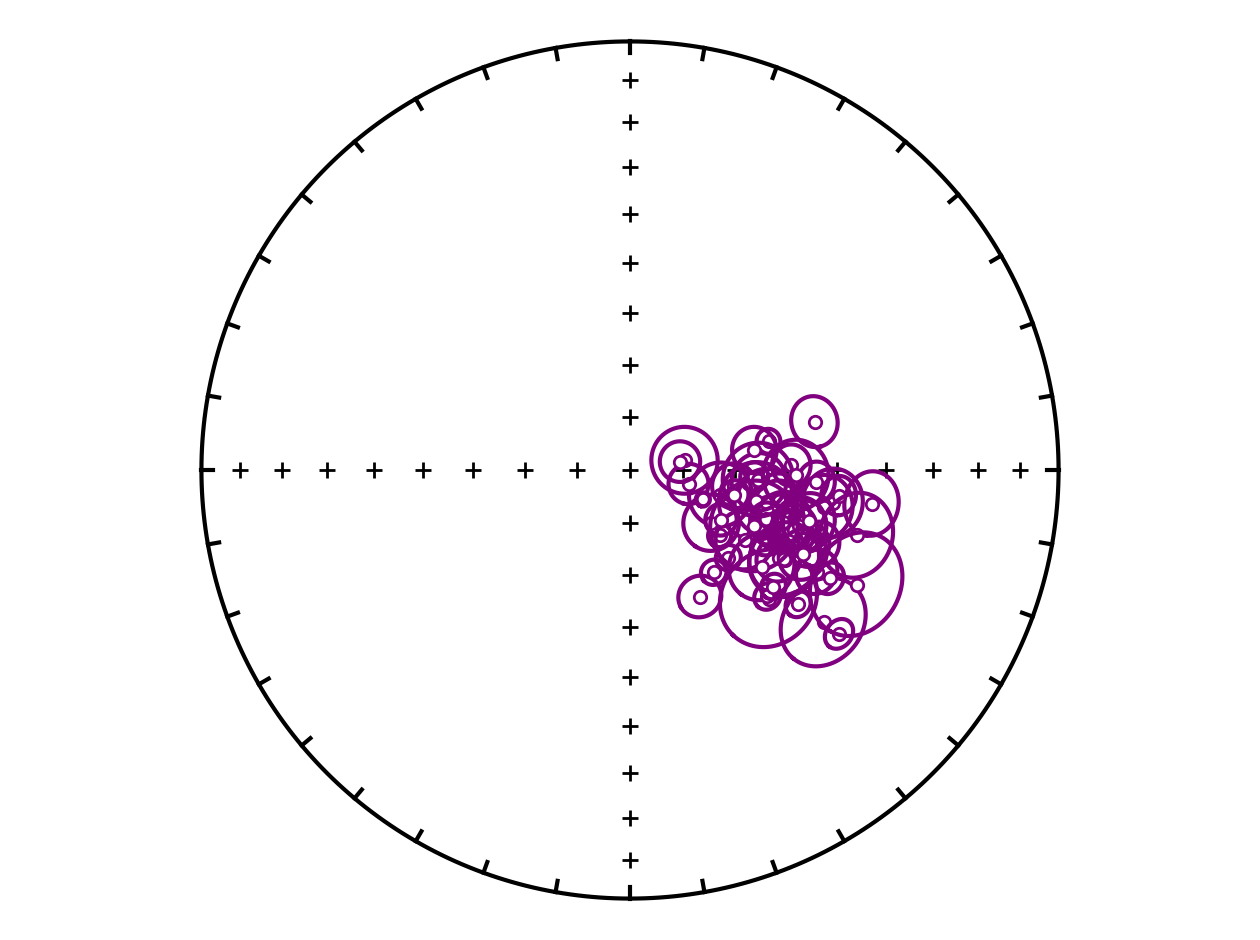

In [40]:
ipmag.plot_net()
for i in range(Osler_reverse_upper_site.shape[0]):
    ipmag.plot_di_mean(Osler_reverse_upper_site['dir_dec'].tolist()[i], Osler_reverse_upper_site['dir_inc'].tolist()[i], Osler_reverse_upper_site['dir_alpha95'].tolist()[i], color='purple')

In [14]:
Osler_lowerR_pole = pmag.fisher_mean(SH2014_OslerR_lower_vgps)
ipmag.print_pole_mean(Osler_lowerR_pole)

Plon: 218.6  Plat: 40.9
Number of directions in mean (n): 30
Angular radius of 95% confidence (A_95): 4.8
Precision parameter (k) estimate: 31.5


### Osler reverse (R2; upper Alona Bay reversed-polarity zone) pole

In [15]:
Osler_reverse_upper_site = pd.concat([SH2014_OslerR_upper, Halls1974_sites_r])
Osler_reverse_upper_site['pole_name'] = 'Osler reverse upper'
Osler_reverse_upper_site['dir_polarity'] = 'r'
Osler_reverse_upper_site['age'] = 1105.15
Osler_reverse_upper_site['age_high'] = 1105.48
Osler_reverse_upper_site['age_low'] = 1104.82
Osler_reverse_upper_site['age_uncertainty'] = 'gaussian'
Osler_reverse_upper_site['geologic_classes'] = 'Extrusive:Igneous'
Osler_reverse_upper_site['geologic_types'] = 'Lava Flow'
Osler_reverse_upper_site['lithologies'] = 'Basalt'
Osler_reverse_upper_site.head()

,age,age_high,age_low,age_unit,bed_dip,bed_dip_direction,citations,description,dir_alpha95,dir_dec,dir_inc,dir_n_specimens,geologic_classes,geologic_types,height,lat,lithologies,location,lon,method_codes,site,vgp_lat,vgp_lon,dir_n_samples,dir_k,dir_polarity,dir_tilt_correction,result_type,pole_name,age_uncertainty
65,1105.15,1105.48,1104.82,Ma,NaN,NaN,Swanson-Hysell et al. 2014,SI4(106.0 to 121.4),4.3,120.7,-56.8,7.0,Extrusive:Igneous,Lava Flow,2089.0,48.7499,Basalt,Simpson Island,272.4047,DE-FM:LP-DC4:LP-DIR-AF,SI4(106.0 to 121.4),46.4,190.3,7.0,151.433207,r,NaN,NaN,Osler reverse upper,gaussian
67,1105.15,1105.48,1104.82,Ma,NaN,NaN,Swanson-Hysell et al. 2014,SI4(121.4 to 127.3),4.1,111.5,-50.9,7.0,Extrusive:Igneous,Lava Flow,2104.4,48.7494,Basalt,Simpson Island,272.4046,DE-FM:LP-DC4:LP-DIR-AF,SI4(121.4 to 127.3),36.9,190.4,7.0,166.567519,r,NaN,NaN,Osler reverse upper,gaussian
71,1105.15,1105.48,1104.82,Ma,NaN,NaN,Swanson-Hysell et al. 2014,SI4(133.8 to 143.1),4.7,109.6,-60.6,7.0,Extrusive:Igneous,Lava Flow,2116.8,48.7490,Basalt,Simpson Island,272.4045,DE-FM:LP-DC4:LP-DIR-AF,SI4(133.8 to 143.1),41.7,201.8,7.0,126.754187,r,NaN,NaN,Osler reverse upper,gaussian
73,1105.15,1105.48,1104.82,Ma,NaN,NaN,Swanson-Hysell et al. 2014,SI4(160.4 to 171.1),4.0,151.1,-62.4,8.0,Extrusive:Igneous,Lava Flow,2143.4,48.7485,Basalt,Simpson Island,272.4042,DE-FM:LP-DC4:LP-DIR-AF,SI4(160.4 to 171.1),69.5,179.1,8.0,153.125000,r,NaN,NaN,Osler reverse upper,gaussian
85,1105.15,1105.48,1104.82,Ma,NaN,NaN,Swanson-Hysell et al. 2014,SI5a(0.0 to 9.0),3.9,112.8,-52.5,12.0,Extrusive:Igneous,Lava Flow,3115.0,48.7363,Basalt,Simpson Island,272.3038,DE-FM:LP-DC4:LP-DIR-AF,SI5a(0.0 to 9.0),38.7,190.9,12.0,107.385492,r,NaN,NaN,Osler reverse upper,gaussian


In [16]:
Osler_upperR_pole_old = pmag.fisher_mean(SH2014_OslerR_upper_vgps+Halls1974_OslerR_vgps)
ipmag.print_pole_mean(Osler_upperR_pole_old)

Plon: 201.6  Plat: 42.5
Number of directions in mean (n): 59
Angular radius of 95% confidence (A_95): 3.7
Precision parameter (k) estimate: 25.7


In [17]:
Osler_upperR_pole_new = pmag.fisher_mean(SH2014_OslerR_upper_vgps+Halls1974_OslerR_vgps+AgatePoint_OslerR_vgps)
ipmag.print_pole_mean(Osler_upperR_pole_new)

Plon: 203.4  Plat: 42.3
Number of directions in mean (n): 64
Angular radius of 95% confidence (A_95): 3.7
Precision parameter (k) estimate: 24.4


These mean poles can be added to the pole_means dataframe. In terms of Q factor, a fold test on the Osler R2 pole utilizing the directional data of both Halls (1974) and Swanson-Hysell et al. (2014b) passes Tauxe and Watson (1994) and McFadden and McElhinny (1990) fold tests (Tauxe et al., 2016). Given evidence for early tilting (e.g. the angular unconformity associated with the syn-rift volcanism Puff Island Conglomerate), this test provided evidence for a primary origin of magnetization. The Osler reverse (lower) data have no such test, although there are younger dikes of normal polarity within the reversed volcanics (that likely correspond to Portage Lake normal-polarity zone) providing additional evidence that the reversed volcanics have not be remagnetized. Buchan et al. (2001) considered the reversed Osler Volcanic Group pole to be a "key pole" and made the additional argument that the unconformity test provides strong evidence for a primary origin of remanence:

> Remanence is considered primary because the position of the prominent Keweenawan polarity reversal in the Upper Osler lavas coincides exactly with the position of an unconformity in the sequence (Halls, 1974).

In [18]:
pole_means.loc['Osler_R1'] = pd.Series({'PoleName' : 'Osler reverse (lower)',
                                        'SLat' : 48.80,
                                        'SLon' : 360-87.66,
                                        'PLat' : round(Osler_lowerR_pole['inc'],1),
                                        'PLon' : round(Osler_lowerR_pole['dec'],1),
                                        'A95' : round(Osler_lowerR_pole['alpha95'],1),
                                        'K' : round(Osler_lowerR_pole['k'],1),
                                        'N' : int(Osler_lowerR_pole['n']),
                                        'PolarityZone' : 'Alona Bay reversed-polarity zone',
                                        'PmagRef' : 'Swanson-Hysell et al., 2014b',
                                        'AgeNominal' : 1108,
                                        'AgeLower' : 1105.15,
                                        'AgeUpper' : 1110,
                                        'AgeInfo' : 'Older than 1105.15 $\pm$ 0.33 Ma Osler reverse (upper) pole, perhaps similar in age in Logan Sills ($^{\mathrm{207}}$Pb/$^{\mathrm{206}}$Pb date of 1109 $\pm$ 1 Ma)',
                                        'AgeRef' : 'Davis and Sutcliffe, 1985; this study',
                                        'GaussianOrUniform' : 'uniform',
                                        'Q' : 7,
                                        'color' : '#B82431'})

pole_means.loc['Osler_R2'] = pd.Series({'PoleName' : 'Osler reverse (upper)',
                                        'SLat' : 48.59,
                                        'SLon' : 360-88.19,
                                        'PLat' : round(Osler_upperR_pole_new['inc'],1),
                                        'PLon' : round(Osler_upperR_pole_new['dec'],1),
                                        'A95' : round(Osler_upperR_pole_new['alpha95'],1),
                                        'N' : int(Osler_upperR_pole_new['n']),
                                        'K' : round(Osler_upperR_pole_new['k'],1),
                                        'PolarityZone' : 'Alona Bay reversed-polarity zone',
                                        'PmagRef' : 'Halls, 1974; Swanson-Hysell et al., 2014b; this study',
                                        'AgeNominal' : 1105.15,
                                        'AgeLower' : 1104.82,
                                        'AgeUpper' : 1105.48,
                                        'AgeInfo' : '$^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U date of 1105.15 $\pm$ 0.33 Ma for a rhyolite at Agate Point (this study)',
                                        'AgeRef' : 'this study',
                                        'GaussianOrUniform' : 'gaussian',
                                        'Gaussian_2sigma' : 0.33,
                                        'Q' : 7,
                                        'color' : '#F2A07E'})

### Osler normal pole

The study of Halls (1974) included 5 normal sites and previous poles utilizing these data have calculated a mean pole wherein each of these sites is equally weighted (e.g. Halls and Pesonen, 1982). However, field mapping by Swanson-Hysell and Fairchild in July 2014 of the Osler Volcanic Group in the vicinity of Puff Island in the Lake Superior Archipelago revealed that the 5 normal sites of Halls (1974) are from a total of two flows. Sites 1, 2 and 5 are all from the first thick flow above the Puff Island conglomerate while sites 3 and 4 are from a single flow that forms the SSE shoreline of Puff Island and Tremblay Island.

In [19]:
Halls1974_sites_n = Halls1974_sites[Halls1974_sites['location']=='Osler Volcanics, Nipigon Strait, Upper Normal']
Halls1974_sites_n.head()

,bed_dip,bed_dip_direction,citations,dir_dec,dir_inc,dir_k,dir_n_samples,dir_polarity,dir_tilt_correction,geologic_classes,geologic_types,lat,lithologies,location,lon,method_codes,result_type,site,vgp_lat,vgp_lon,dir_alpha95
0,10,135,"Halls, 1974",289.8,43.6,517,5,n,100,Extrusive,Lava Flow,48.626429,Basalt,"Osler Volcanics, Nipigon Strait, Upper Normal",271.894142,DE-K:FS-FD:FS-H:LP-DC2:SO-SM:DE-DI:FS-LOC-GOOGLE,i,1,31.651552,185.574506,2.753580
1,10,135,"Halls, 1974",293.1,34.5,517,5,n,0,Extrusive,Lava Flow,48.626429,Basalt,"Osler Volcanics, Nipigon Strait, Upper Normal",271.894142,DE-K:FS-FD:FS-H:LP-DC2:SO-SM:DE-DI:FS-LOC-GOOGLE,i,1,NaN,NaN,2.753580
2,12,140,"Halls, 1974",285.7,42.0,243,5,n,100,Extrusive,Lava Flow,48.637185,Basalt,"Osler Volcanics, Nipigon Strait, Upper Normal",271.913846,DE-K:FS-FD:FS-H:LP-DC2:SO-SM:DE-DI:FS-LOC-GOOGLE,i,2,28.110086,187.514758,4.016427
3,12,140,"Halls, 1974",290.6,31.9,243,5,n,0,Extrusive,Lava Flow,48.637185,Basalt,"Osler Volcanics, Nipigon Strait, Upper Normal",271.913846,DE-K:FS-FD:FS-H:LP-DC2:SO-SM:DE-DI:FS-LOC-GOOGLE,i,2,NaN,NaN,4.016427
4,14,146,"Halls, 1974",307.4,37.9,2485,5,n,100,Extrusive,Lava Flow,48.640811,Basalt,"Osler Volcanics, Nipigon Strait, Upper Normal",271.928039,DE-K:FS-FD:FS-H:LP-DC2:SO-SM:DE-DI:FS-LOC-GOOGLE,i,3,40.260604,167.886292,1.255972


To deal with the multiple sites from the same flow, we can calculate the mean direction of the Halls (1974) "sites" for each flow and then calculate the VGP from that mean direction. This method isn't ideal as it would be preferable to calculate Fisher means from the sample level data, but these data are not published.

In [20]:
#Halls flow #1 is sites 1, 2 and 5 which we can separate out into a new list of directions
Halls_N_flow1_directions=[]
Halls_N_flow1_directions.append([Halls1974_sites_n.dir_dec[0], Halls1974_sites_n.dir_inc[0]])
Halls_N_flow1_directions.append([Halls1974_sites_n.dir_dec[1], Halls1974_sites_n.dir_inc[1]])
Halls_N_flow1_directions.append([Halls1974_sites_n.dir_dec[4], Halls1974_sites_n.dir_inc[4]])

#take the Fisher mean of flow 1 directions
Halls_N_flow1_mean=pmag.fisher_mean(Halls_N_flow1_directions)

#Halls flow #2 is sites 3 and 4 which we can separate out into a new list of directions
Halls_N_flow2_directions=[]
Halls_N_flow2_directions.append([Halls1974_sites_n.dir_dec[2], Halls1974_sites_n.dir_inc[2]])
Halls_N_flow2_directions.append([Halls1974_sites_n.dir_dec[3], Halls1974_sites_n.dir_inc[3]])

#take the Fisher mean of flow 2 directions
Halls_N_flow2_mean = pmag.fisher_mean(Halls_N_flow2_directions)

#create a new data frame and insert the data for the two flows (making sure that the values are floats)
Halls1974_Osler_Data_N_new = pd.DataFrame(columns=['age', 'age_high', 'age_low', 'age_unit', 'citations',
                                                    'criteria', 'dir_alpha95', 'dir_dec', 'dir_inc',
                                                    'dir_k', 'dir_n_samples', 'dir_n_specimens', 
                                                    'dir_n_specimens_lines', 'dir_n_specimens_planes', 'dir_polarity', 'dir_r',
                                                    'dir_tilt_correction', 'lat', 'location', 'lon', 'method_codes',
                                                    'result_quality', 'result_type', 'site'])


Halls1974_Osler_Data_N_new.loc[0]=pd.Series({'name':'Halls_N_flow1', 
                                   'lat':Halls1974_sites_n.lat[0],
                                   'lon':Halls1974_sites_n.lon[0],
                                   'dir_dec':Halls_N_flow1_mean['dec'],
                                   'dir_inc':Halls_N_flow1_mean['inc'], 
                                   'dir_alpha95':Halls_N_flow1_mean['alpha95'],
                                   'dir_k':Halls_N_flow1_mean['k'],
                                   'dir_n_samples':Halls_N_flow1_mean['n'], 
                                   'dir_n_specimens':Halls_N_flow1_mean['n'], 
                                   'dir_n_specimens_lines':	Halls_N_flow1_mean['n'],
                                   'dir_n_specimens_planes':0,
                                   'dir_polarity':'n', 
                                   'dir_r':Halls_N_flow1_mean['r'],
                                   'dir_tilt_correction':100,
                                   'location':'Osler Volcanics, Nipigon Strait, Upper Normal', 
                                   'method_codes':'DE-K:FS-FD:FS-H:LP-DC2:SO-SM:DE-DI:FS-LOC-GOOGLE', 
                                   'result_quality':'g',
                                   'result_type':'i',
                                   'site':'flow 1',
                                   })

Halls1974_Osler_Data_N_new.loc[1]=pd.Series({'name':'Halls_N_flow2', 
                                   'lat':Halls1974_sites_n.lat[2],
                                   'lon':Halls1974_sites_n.lon[2],
                                   'dir_dec':Halls_N_flow2_mean['dec'],
                                   'dir_inc':Halls_N_flow2_mean['inc'],
                                   'dir_alpha95':Halls_N_flow2_mean['alpha95'],
                                   'dir_k':Halls_N_flow2_mean['k'],
                                   'dir_n_samples':Halls_N_flow2_mean['n'], 
                                   'dir_n_specimens':Halls_N_flow2_mean['n'], 
                                   'dir_n_specimens_lines':	Halls_N_flow2_mean['n'],
                                   'dir_n_specimens_planes':0,
                                   'dir_polarity':'n', 
                                   'dir_r':Halls_N_flow2_mean['r'],
                                   'dir_tilt_correction':100,
                                   'location':'Osler Volcanics, Nipigon Strait, Upper Normal', 
                                   'method_codes':'DE-K:FS-FD:FS-H:LP-DC2:SO-SM:DE-DI:FS-LOC-GOOGLE', 
                                   'result_quality':'g',
                                   'result_type':'i',
                                   'site':'flow 2',
                                   })

Halls1974_Osler_Data_N_new['age'] = 1095
Halls1974_Osler_Data_N_new['age_high'] = 1100
Halls1974_Osler_Data_N_new['age_low'] = 1080
Halls1974_Osler_Data_N_new['age_unit'] = 'Ma'
Halls1974_Osler_Data_N_new['criteria'] = 'ACCEPT'


Halls1974_Osler_Data_N_new['dir_dec'] = Halls1974_Osler_Data_N_new['dir_dec'].astype(float)
Halls1974_Osler_Data_N_new['dir_inc'] = Halls1974_Osler_Data_N_new['dir_inc'].astype(float)
Halls1974_Osler_Data_N_new['lat'] = Halls1974_Osler_Data_N_new['lat'].astype(float)
Halls1974_Osler_Data_N_new['lon'] = Halls1974_Osler_Data_N_new['lon'].astype(float)

#calculate VGPs from the directional data
ipmag.vgp_calc(Halls1974_Osler_Data_N_new, site_lon='lon', site_lat= 'lat', tilt_correction='yes', dec_tc= 'dir_dec', inc_tc='dir_inc')

OslerN_VGPs_Halls=[]
OslerN_Plong_Halls=[]
OslerN_Plat_Halls=[]

for n in range(0,len(Halls1974_Osler_Data_N_new)): 
    Plong,Plat=Halls1974_Osler_Data_N_new['vgp_lon'][n],Halls1974_Osler_Data_N_new['vgp_lat'][n]
    OslerN_Plong_Halls.append(Plong)
    OslerN_Plat_Halls.append(Plat)
    OslerN_VGPs_Halls.append([Plong,Plat,1.])

In [21]:
Halls1974_Osler_Data_N_new

,age,age_high,age_low,age_unit,citations,criteria,dir_alpha95,dir_dec,dir_inc,dir_k,dir_n_samples,dir_n_specimens,dir_n_specimens_lines,dir_n_specimens_planes,dir_polarity,dir_r,dir_tilt_correction,lat,location,lon,method_codes,result_quality,result_type,site,paleolatitude,vgp_lat,vgp_lon,vgp_lat_rev,vgp_lon_rev
0,1095,1100,1080,Ma,NaN,ACCEPT,13.147087,296.891898,38.913266,88.980357,3,3,3,0,n,2.977523,100,48.626429,"Osler Volcanics, Nipigon Strait, Upper Normal",271.894142,DE-K:FS-FD:FS-H:LP-DC2:SO-SM:DE-DI:FS-LOC-GOOGLE,g,i,flow 1,21.980989,33.925083,177.238633,-33.925083,357.238633
1,1095,1100,1080,Ma,NaN,ACCEPT,23.812889,288.312949,36.975063,112.092549,2,2,2,0,n,1.991079,100,48.637185,"Osler Volcanics, Nipigon Strait, Upper Normal",271.913846,DE-K:FS-FD:FS-H:LP-DC2:SO-SM:DE-DI:FS-LOC-GOOGLE,g,i,flow 2,20.628142,27.305825,182.694352,-27.305825,2.694352


In addition to the two flows above the angular unconformity studied by Halls (1974), we identified, sampled and developed data from two other flows exposed above the unconformity on Puff Island. After calculating each VGP, we can calculate a new mean pole for the Osler normal polarity volcanics. There are only 4 VGPs from which the Osler normal pole can be calculated making it so that the pole is not robust. There is little prospect for significant improvement of the pole as there only appear to be four flows in total exposed above the Puff Island conglomerate at the current water level of Lake Superior.

In [22]:
new_Osler_sites_Puff

,age,age_high,age_low,age_sigma,age_unit,citations,criteria,dir_alpha95,dir_comp_name,dir_dec,dir_inc,dir_k,dir_n_samples,dir_n_specimens,dir_n_specimens_lines,dir_n_specimens_planes,dir_polarity,dir_r,dir_tilt_correction,lat,location,lon,method_codes,result_quality,result_type,samples,site,software_packages,specimens,vgp_dm,vgp_dp,vgp_lat,vgp_lon
11,1105.0,1106.0,1104.0,1.0,Ma,This study,ACCEPT,3.8,mag,303.4,25.2,219,8,8,8,0,t,7.9680,100,48.7,Puff Island,-88.0,LP-DIR-T:DE-BFL:DA-DIR-TILT:LP-DC4:DE-FM:DA-DIR-GEO,g,i,Puf1-1:Puf1-2:Puf1-3:Puf1-4:Puf1-5:Puf1-6:Puf1-7:Puf1-8,Puf1,pmagpy-3.4.1: demag_gui.v.3.0,Puf1-1a:Puf1-2a:Puf1-3a:Puf1-4a:Puf1-5a:Puf1-6a:Puf1-7a:Puf1-8a,4.1,2.2,31.7,164.8
13,1105.0,1106.0,1104.0,1.0,Ma,This study,ACCEPT,3.5,mag,296.9,24.7,293,7,7,7,0,t,6.9795,100,48.7,Puff Island,-88.0,LP-DIR-T:DE-BFL:DA-DIR-TILT:LP-DC4:DE-FM:DA-DIR-GEO,g,i,Puf2-1:Puf2-2:Puf2-3:Puf2-4:Puf2-5:Puf2-6:Puf2-7,Puf2,pmagpy-3.4.1: demag_gui.v.3.0,Puf2-1a:Puf2-2a:Puf2-3a:Puf2-4a:Puf2-5a:Puf2-6a:Puf2-7a,3.8,2.0,27.3,170.1


In [23]:
PuffIsland_OslerN_vgps = ipmag.make_di_block(new_Osler_sites_Puff['vgp_lon'].tolist(),
                              new_Osler_sites_Puff['vgp_lat'].tolist())

OslerN_pole = pmag.fisher_mean(OslerN_VGPs_Halls+PuffIsland_OslerN_vgps) 
ipmag.print_pole_mean(OslerN_pole)

Plon: 173.7  Plat: 30.2
Number of directions in mean (n): 4
Angular radius of 95% confidence (A_95): 8.6
Precision parameter (k) estimate: 114.6


In [24]:
Osler_normal_site = pd.concat([Halls1974_Osler_Data_N_new, new_Osler_sites_Puff])
Osler_normal_site['pole_name'] = 'Osler normal'
Osler_normal_site['dir_polarity'] = 'n'
Osler_normal_site['age'] = 1095
Osler_normal_site['age_high'] = 1100
Osler_normal_site['age_low'] = 1080
Osler_normal_site['age_uncertainty'] = 'uniform'
Osler_normal_site['citations'] = 'Halls, 1974:Swanson-Hysell et al., 2019'
Osler_normal_site['geologic_classes'] = 'Extrusive:Igneous'
Osler_normal_site['geologic_types'] = 'Lava Flow'
Osler_normal_site['lithologies'] = 'Basalt'
Osler_normal_site.head()

,age,age_high,age_low,age_unit,citations,criteria,dir_alpha95,dir_dec,dir_inc,dir_k,dir_n_samples,dir_n_specimens,dir_n_specimens_lines,dir_n_specimens_planes,dir_polarity,dir_r,dir_tilt_correction,lat,location,lon,method_codes,result_quality,result_type,site,paleolatitude,vgp_lat,vgp_lon,vgp_lat_rev,vgp_lon_rev,age_sigma,dir_comp_name,samples,software_packages,specimens,vgp_dm,vgp_dp,pole_name,age_uncertainty,geologic_classes,geologic_types,lithologies
0,1095,1100,1080,Ma,"Halls, 1974:Swanson-Hysell et al., 2019",ACCEPT,13.147087,296.891898,38.913266,88.980357,3,3,3,0,n,2.977523,100,48.626429,"Osler Volcanics, Nipigon Strait, Upper Normal",271.894142,DE-K:FS-FD:FS-H:LP-DC2:SO-SM:DE-DI:FS-LOC-GOOGLE,g,i,flow 1,21.980989,33.925083,177.238633,-33.925083,357.238633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Osler normal,uniform,Extrusive:Igneous,Lava Flow,Basalt
1,1095,1100,1080,Ma,"Halls, 1974:Swanson-Hysell et al., 2019",ACCEPT,23.812889,288.312949,36.975063,112.092549,2,2,2,0,n,1.991079,100,48.637185,"Osler Volcanics, Nipigon Strait, Upper Normal",271.913846,DE-K:FS-FD:FS-H:LP-DC2:SO-SM:DE-DI:FS-LOC-GOOGLE,g,i,flow 2,20.628142,27.305825,182.694352,-27.305825,2.694352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Osler normal,uniform,Extrusive:Igneous,Lava Flow,Basalt
11,1095,1100,1080,Ma,"Halls, 1974:Swanson-Hysell et al., 2019",ACCEPT,3.8,303.400000,25.200000,219,8,8,8,0,n,7.968,100,48.700000,Puff Island,-88.000000,LP-DIR-T:DE-BFL:DA-DIR-TILT:LP-DC4:DE-FM:DA-DIR-GEO,g,i,Puf1,NaN,31.700000,164.800000,NaN,NaN,1.0,mag,Puf1-1:Puf1-2:Puf1-3:Puf1-4:Puf1-5:Puf1-6:Puf1-7:Puf1-8,pmagpy-3.4.1: demag_gui.v.3.0,Puf1-1a:Puf1-2a:Puf1-3a:Puf1-4a:Puf1-5a:Puf1-6a:Puf1-7a:Puf1-8a,4.1,2.2,Osler normal,uniform,Extrusive:Igneous,Lava Flow,Basalt
13,1095,1100,1080,Ma,"Halls, 1974:Swanson-Hysell et al., 2019",ACCEPT,3.5,296.900000,24.700000,293,7,7,7,0,n,6.9795,100,48.700000,Puff Island,-88.000000,LP-DIR-T:DE-BFL:DA-DIR-TILT:LP-DC4:DE-FM:DA-DIR-GEO,g,i,Puf2,NaN,27.300000,170.100000,NaN,NaN,1.0,mag,Puf2-1:Puf2-2:Puf2-3:Puf2-4:Puf2-5:Puf2-6:Puf2-7,pmagpy-3.4.1: demag_gui.v.3.0,Puf2-1a:Puf2-2a:Puf2-3a:Puf2-4a:Puf2-5a:Puf2-6a:Puf2-7a,3.8,2.0,Osler normal,uniform,Extrusive:Igneous,Lava Flow,Basalt


In [25]:
pole_means.loc['Osler_N'] = pd.Series({'PoleName' : 'Osler normal',
                                        'SLat' : 48.64,
                                        'SLon' : 271.91,
                                        'PLat' : round(OslerN_pole['inc'],1),
                                        'PLon' : round(OslerN_pole['dec'],1),
                                        'A95' : round(OslerN_pole['alpha95'],1),
                                        'K' : round(OslerN_pole['k'],1),
                                        'N' : int(OslerN_pole['n']),
                                        'PolarityZone' : 'Portage Lake normal-polarity zone',
                                        'PmagRef' : 'Halls, 1974; this study',
                                        'AgeNominal' : 1095,
                                        'AgeLower' : 1080,
                                        'AgeUpper' : 1100,
                                        'AgeInfo' : 'Poorly known, significantly younger than the ca. 1105 Ma Agate Point Rhyolite date, pole position similiar to Portage Lake normal-polarity zone poles and distinct from Flour Bay normal-polarity zone pole and therefore likely younger than 1100 Ma date in the Alona Bay reversed-polarity zone',
                                        'AgeRef' : '',
                                        'GaussianOrUniform' : 'uniform',
                                        'Q' : 7,
                                        'color' : '#0000FF'})

## Mamainse Point Volcanics

The succession of basalt flows at Mamainse Point, Ontario in the easternmost portion of the Lake Superior basin is interpretted to be the most time-complete record of extrusive volcanism in the Midcontinent Rift. Paleomagnetic data developed in stratigraphic context from the succession at Mamainse Point published in Swanson-Hysell et al. (2009) and Swanson-Hysell et al. (2014a) are imported below.

Swanson-Hysell, N. L., Maloof, A. C., Weiss, B. P., and Evans, D. A. D., 2009, No asymmetry in geomagnetic reversals recorded by 1.1-billion-year-old Keweenawan basalts: Nature Geoscience, vol. 2, pp. 713–717, doi:10.1038/ngeo622.

Swanson-Hysell, N. L., Burgess, S. D., Maloof, A. C., and Bowring, S. A., 2014a, Magmatic activity and plate motion during the latent stage of Midcontinent Rift development: Geology, vol. 42, pp. 475–478, doi:10.1130/G35271.1.

Link to MagIC contribution: https://earthref.org/MagIC/16333 or http://earthref.org/MAGIC/doi/10.1130/G35271.1

In [26]:
%%capture
ipmag.download_magic('MamainseMagIC.txt',
                     dir_path='../data/pmag_compiled/Swanson-Hysell2014a',
                     input_dir_path='../data/pmag_compiled/Swanson-Hysell2014a',
                     overwrite=True,print_progress=False,data_model=3.0)
MP_sites = pd.read_csv('../data/pmag_compiled/Swanson-Hysell2014a/sites.txt',sep='\t',header=1)
MP_sites['citations'] = 'Swanson-Hysell et al., 2014'

There are significant changes in pole position recorded in the succession at Mamainse Point. As a result, poles need to be calculated from subsets of the VGPs. These divisions are made by stratigraphic intervals as was done in Swanson-Hysell et al. (2009, 2014a) with four resulting poles:
- Mamainse Point lower R1 (the stratigraphically lowest 600 meters; older portion of the Alona Bay reversed-polarity zone)
- Mamainse Point lower R2 (flows between meters 1080 and 1301; the younger portion of the Alona Bay reversed-polarity zone)
- Mamainse Point lower N and upper R (flows within the Flour Bay normal-polarity zone and the Flour Bay reversed-polarity zone)
- Mamainse Point upper N (flows within the Portage Lake normal-polarity zone; all studied flows stratigraphically above the "Great Conglomerate")

### Mamainse Point lower R1 (lower Alona Bay reversed-polarity zone)

In [27]:
MP_sites_lowerR1 = MP_sites[MP_sites.height<600]
MP_sites_lowerR1['pole_name'] = 'Mamainse lower R1'
MP_sites_lowerR1['dir_polarity'] = 'r'
MP_sites_lowerR1['age'] = 1109
MP_sites_lowerR1['age_high'] = 1112
MP_sites_lowerR1['age_low'] = 1106
MP_sites_lowerR1['age_unit'] = 'Ma'
MP_sites_lowerR1['age_uncertainty'] = 'uniform'
MP_sites_lowerR1.head()

,citations,dir_alpha95,dir_dec,dir_inc,dir_k,dir_n_samples,dir_tilt_correction,geologic_classes,geologic_types,height,lat,lithologies,location,lon,method_codes,result_type,site,vgp_lat,vgp_lon,pole_name,dir_polarity,age,age_high,age_low,age_unit,age_uncertainty
0,"Swanson-Hysell et al., 2014",9.2,131.6,-63.2,54.0,6,100,Extrusive:Igneous,Lava Flow,68,47.0988,Basalt,Mamainse Point,275.2877,DE-BFL:FS-C-DRILL:SO-POM,i,MP101(0.0 to 15.5),56.78,199.36,Mamainse lower R1,r,1109,1112,1106,Ma,uniform
1,"Swanson-Hysell et al., 2014",13.7,146.0,-77.2,54.0,3,100,Extrusive:Igneous,Lava Flow,84,47.0987,Basalt,Mamainse Point,275.2876,DE-BFL:FS-C-DRILL:SO-POM,i,MP101(15.5 to 16.8),64.21,243.17,Mamainse lower R1,r,1109,1112,1106,Ma,uniform
2,"Swanson-Hysell et al., 2014",7.4,120.3,-77.5,88.0,5,100,Extrusive:Igneous,Lava Flow,85,47.0986,Basalt,Mamainse Point,275.2876,DE-BFL:FS-C-DRILL:SO-POM,i,MP101(16.8 to 18.7),53.99,238.76,Mamainse lower R1,r,1109,1112,1106,Ma,uniform
3,"Swanson-Hysell et al., 2014",8.4,141.5,-66.4,121.0,4,100,Extrusive:Igneous,Lava Flow,89,47.0986,Basalt,Mamainse Point,275.2875,DE-BFL:FS-C-DRILL:SO-POM,i,MP101(20.7 to 21.3),64.44,203.58,Mamainse lower R1,r,1109,1112,1106,Ma,uniform
4,"Swanson-Hysell et al., 2014",4.5,126.6,-72.7,189.0,6,100,Extrusive:Igneous,Lava Flow,89,47.0986,Basalt,Mamainse Point,275.2874,DE-BFL:FS-C-DRILL:SO-POM,i,MP101(21.3 to 21.9),56.76,224.54,Mamainse lower R1,r,1109,1112,1106,Ma,uniform


In [28]:
MPlowerR1_mean = ipmag.fisher_mean(dec=MP_sites_lowerR1.vgp_lon.tolist(),
                                   inc=MP_sites_lowerR1.vgp_lat.tolist())
ipmag.print_pole_mean(MPlowerR1_mean)

Plon: 227.0  Plat: 49.5
Number of directions in mean (n): 24
Angular radius of 95% confidence (A_95): 5.3
Precision parameter (k) estimate: 31.7


### Mamainse Point lower R2 (upper Alona Bay reversed-polarity zone)

In [29]:
MP_sites_lowerR2 = MP_sites[(MP_sites.height > 1070) & (MP_sites.height < 1350)]
MP_sites_lowerR2['pole_name'] = 'Mamainse lower R2'
MP_sites_lowerR2['dir_polarity'] = 'r'
MP_sites_lowerR2['age'] = 1105
MP_sites_lowerR2['age_high'] = 1109
MP_sites_lowerR2['age_low'] = 1100.4
MP_sites_lowerR2['age_unit'] = 'Ma'
MP_sites_lowerR2['age_uncertainty'] = 'uniform'


In [30]:
MPlowerR2_mean = ipmag.fisher_mean(dec=MP_sites_lowerR2.vgp_lon.tolist(),
                                   inc=MP_sites_lowerR2.vgp_lat.tolist())
ipmag.print_pole_mean(MPlowerR2_mean)

Plon: 205.2  Plat: 37.5
Number of directions in mean (n): 14
Angular radius of 95% confidence (A_95): 4.5
Precision parameter (k) estimate: 78.6


### Mamainse lower normal [Mamainse Point lower N and upper R (Flour Bay normal and reversed polarity zones)]

In [31]:
MP_sites_lowerN = MP_sites[(MP_sites.height > 1350) & (MP_sites.height < 1810)]
MP_sites_upperR = MP_sites[(MP_sites.height > 1860) & (MP_sites.height < 2100)]

MP_sites_lower_normal = pd.concat([MP_sites_lowerN, MP_sites_upperR])
MP_sites_lower_normal['pole_name'] = 'Mamainse lower normal'
MP_sites_lower_normal['dir_polarity'] = 'n'
MP_sites_lower_normal['age'] = 1100.36
MP_sites_lower_normal['age_high'] = 1100.61
MP_sites_lower_normal['age_low'] = 1100.11
MP_sites_lower_normal['age_unit'] = 'Ma'
MP_sites_lower_normal['age_uncertainty'] = 'gaussian'
MP_sites_lower_normal.head()

,citations,dir_alpha95,dir_dec,dir_inc,dir_k,dir_n_samples,dir_tilt_correction,geologic_classes,geologic_types,height,lat,lithologies,location,lon,method_codes,result_type,site,vgp_lat,vgp_lon,pole_name,dir_polarity,age,age_high,age_low,age_unit,age_uncertainty
38,"Swanson-Hysell et al., 2014",5.2,287.7,53.6,218.0,5,100,Extrusive:Igneous,Lava Flow,1351,47.0835,Basalt,Mamainse Point,275.2691,DE-BFL:FS-C-DRILL:SO-POM,i,MP214(60.3 to 67.9),35.62,199.36,Mamainse lower normal,n,1100.36,1100.61,1100.11,Ma,gaussian
39,"Swanson-Hysell et al., 2014",6.1,283.7,44.5,129.0,5,100,Extrusive:Igneous,Lava Flow,1364,47.0834,Basalt,Mamainse Point,275.2687,DE-BFL:FS-C-DRILL:SO-POM,i,MP214(73.4 to 79.1),27.89,194.69,Mamainse lower normal,n,1100.36,1100.61,1100.11,Ma,gaussian
40,"Swanson-Hysell et al., 2014",6.7,271.8,42.7,131.0,5,100,Extrusive:Igneous,Lava Flow,1370,47.0837,Basalt,Mamainse Point,275.2683,DE-BFL:FS-C-DRILL:SO-POM,i,MP214(79.1 to 90.0),19.04,201.51,Mamainse lower normal,n,1100.36,1100.61,1100.11,Ma,gaussian
41,"Swanson-Hysell et al., 2014",5.5,283.5,39.4,103.0,8,100,Extrusive:Igneous,Lava Flow,1384,47.0782,Basalt,Mamainse Point,275.2667,DE-BFL:FS-C-DRILL:SO-POM,i,MP46(0.0 to 7.0),34.23,185.86,Mamainse lower normal,n,1100.36,1100.61,1100.11,Ma,gaussian
42,"Swanson-Hysell et al., 2014",16.2,282.8,36.3,59.0,3,100,Extrusive:Igneous,Lava Flow,1387,47.0780,Basalt,Mamainse Point,275.2666,DE-BFL:FS-C-DRILL:SO-POM,i,MP46(7.0 to 8.0),36.82,179.30,Mamainse lower normal,n,1100.36,1100.61,1100.11,Ma,gaussian


In [32]:

MPlower_N_upper_R_mean = ipmag.fisher_mean(dec=MP_sites_lowerN.vgp_lon.tolist()+MP_sites_upperR.vgp_lon.tolist(),
                                           inc=MP_sites_lowerN.vgp_lat.tolist()+MP_sites_upperR.vgp_lat.tolist())
ipmag.print_pole_mean(MPlower_N_upper_R_mean)

Plon: 189.7  Plat: 36.1
Number of directions in mean (n): 24
Angular radius of 95% confidence (A_95): 4.9
Precision parameter (k) estimate: 37.3


### Mamainse Point upper N (Portage Lake polarity zone)

*Note that two upper N poles are presented in Swanson-Hysell et al., 2014a. The other one doesn't include the uppermost portion of the stratigraphy (the MP306 section)*

In [152]:
MP_sites_upperN = MP_sites[MP_sites.height > 2400]
MP_sites_upperN['pole_name'] = 'Mamainse upper normal'
MP_sites_upperN['dir_polarity'] = 'n'
MP_sites_upperN['age'] = 1094
MP_sites_upperN['age_high'] = 1100
MP_sites_upperN['age_low'] = 1090
MP_sites_upperN['age_unit'] = 'Ma'
MP_sites_upperN['age_uncertainty'] = 'uniform'

In [153]:
MPupperN_mean = ipmag.fisher_mean(dec=MP_sites_upperN.vgp_lon.tolist(),
                                   inc=MP_sites_upperN.vgp_lat.tolist())
ipmag.print_pole_mean(MPupperN_mean)

Plon: 183.2  Plat: 31.2
Number of directions in mean (n): 34
Angular radius of 95% confidence (A_95): 2.5
Precision parameter (k) estimate: 94.4


In [154]:
pole_means.loc['MP_lowerR1'] = pd.Series({'PoleName' : 'Mamainse lower reversed 1',
                                        'SLat' : round(MP_sites_lowerR1.lat[0],2),
                                        'SLon' : round(MP_sites_lowerR1.lon[0],2),
                                        'PLat' : round(MPlowerR1_mean['inc'],1),
                                        'PLon' : round(MPlowerR1_mean['dec'],1),
                                        'A95' : round(MPlowerR1_mean['alpha95'],1),
                                        'K' : round(MPlowerR1_mean['k'],1),
                                        'N' : int(MPlowerR1_mean['n']),
                                        'PolarityZone' : 'Alona Bay reversed-polarity zone',
                                        'PmagRef' : 'Swanson-Hysell et al., 2014a',
                                        'AgeNominal' : 1109,
                                        'AgeLower' : 1106,
                                        'AgeUpper' : 1112,
                                        'AgeInfo' : 'Likely older than ca. 1105 Ma given distinct higher latitude pole position from Osler R1 and similar position to ca. 1107 Ma Siemens Creek Volcanic Pole',
                                        'AgeRef' : '',
                                        'GaussianOrUniform' : 'uniform',
                                        'Q' : '7',
                                        'color' : '#930E26'})

pole_means.loc['MP_lowerR2'] = pd.Series({'PoleName' : 'Mamainse lower reversed 2',
                                        'SLat' : round(MP_sites_lowerR2.lat.tolist()[0],2),
                                        'SLon' : round(MP_sites_lowerR2.lon.tolist()[0],2),
                                        'PLat' : round(MPlowerR2_mean['inc'],1),
                                        'PLon' : round(MPlowerR2_mean['dec'],1),
                                        'A95' : round(MPlowerR2_mean['alpha95'],1),
                                        'K' : round(MPlowerR2_mean['k'],1),
                                        'N' : int(MPlowerR2_mean['n']),
                                        'PolarityZone' : 'Alona Bay reversed-polarity zone',
                                        'PmagRef' : 'Swanson-Hysell, 2014a',
                                        'AgeNominal' : 1105,
                                        'AgeLower' : 1100.4,
                                        'AgeUpper' : 1109,
                                        'AgeInfo' : 'Older than $^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U date of 1100.4 Ma based on stratigraphic position; likely ca. 1105 Ma based on comparison with paleomagnetic data from the Osler Volcanic Group',
                                        'AgeRef' : 'Swanson-Hysell, 2014a',
                                        'GaussianOrUniform' : 'uniform',
                                        'Q' : '7',
                                        'color' : '#F8C1A6'})

pole_means.loc['MP_lowerNupperR'] = pd.Series({'PoleName' : 'Mamainse lower normal and upper reversed',
                                        'SLat' : round(MP_sites_upperR.lat.tolist()[0],2),
                                        'SLon' : round(MP_sites_upperR.lon.tolist()[0],2),
                                        'PLat' : round(MPlower_N_upper_R_mean['inc'],1),
                                        'PLon' : round(MPlower_N_upper_R_mean['dec'],1),
                                        'A95' : round(MPlower_N_upper_R_mean['alpha95'],1),
                                        'K' : round(MPlower_N_upper_R_mean['k'],1),
                                        'N' : int(MPlower_N_upper_R_mean['n']),
                                        'PolarityZone' : 'Flour Bay normal and reversed polarity zones',
                                        'PmagRef' : 'Swanson-Hysell, 2014a',
                                        'AgeNominal' : 1100.36,
                                        'AgeLower' : 1100.10,
                                        'AgeUpper' : 1100.61,
                                        'AgeInfo' : 'Age constrained by $^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U date of 1100.36 $\pm$ 0.25 Ma on Flour Bay tuff',
                                        'AgeRef' : 'Swanson-Hysell, 2014a',
                                        'GaussianOrUniform' : 'gaussian',
                                        'Gaussian_2sigma' : 0.25,
                                        'Q' : '7',
                                        'color' : '#6A579A'})

pole_means.loc['MP_upperN'] = pd.Series({'PoleName' : 'Mamainse upper normal',
                                        'SLat' : round(MP_sites_upperN.lat.tolist()[0],2),
                                        'SLon' : round(MP_sites_upperN.lon.tolist()[0],2),
                                        'PLat' : round(MPupperN_mean['inc'],1),
                                        'PLon' : round(MPupperN_mean['dec'],1),
                                        'A95' : round(MPupperN_mean['alpha95'],1),
                                        'K' : round(MPupperN_mean['k'],1),
                                        'N' : int(MPupperN_mean['n']),
                                        'PolarityZone' : 'Portage Lake normal-polarity zone',
                                        'PmagRef' : 'Swanson-Hysell, 2014a',
                                        'AgeNominal' : 1094,
                                        'AgeLower' : 1090,
                                        'AgeUpper' : 1100,
                                        'AgeInfo' : 'Likely ca. 1094 Ma based on similar pole position to the Portage Lake Polarity Zone upper NE limb North Shore Volcanic Group poles',
                                        'AgeRef' : '',
                                        'GaussianOrUniform' : 'uniform',
                                        'Q' : '7',
                                        'color' : '#3B7185'})

## North Shore Volcanic Group and Schroeder-Lutsen Basalts

Tauxe and Kodama (2009) published data from sites of the North Shore Volcanic Group that was the first study of the North Shore Volcanic Group to publish data from these lava flows using modern methods. Books (1968, 1972) and Palmer (1970) also developed data that can largely be considered to be superseded by the Tauxe and Kodama results. However, we will consider some of the Books data from the Grand Portage basalts since only one of those flows was sampled by Tauxe and Kodama (2009) and the generally single component remanence of these lava flows makes it such that the single AF cleaning step methods of those researchers likely isolated robust site means. The Tauxe data can be unpacked from the MagIC contribution and be imported into a dataframe.

### Import Tauxe and Kodama (2009)

Tauxe, L. and Kodama, K., 2009, Paleosecular variation models for ancient times: Clues from Keweenawan lava flows: Physics of the Earth and Planetary Interiors, vol. 177, pp. 31–45, doi:10.1016/j.pepi.2009.07.006.

Link to MagIC contribution: http://earthref.org/MAGIC/doi/j.pepi.2009.07.006

In [155]:
%%capture
ipmag.download_magic('zmab0099887tmp01.txt',
                     dir_path='../data/pmag_compiled/Tauxe2009',
                     input_dir_path='../data/pmag_compiled/Tauxe2009',
                     overwrite=True,print_progress=False)

In [156]:
NSVG_Data=pd.read_csv('../data/pmag_compiled/Tauxe2009/pmag_results.txt',sep='\t',skiprows=1)
NSVG_Data.drop(['magic_software_packages', 'pmag_criteria_codes', 'pmag_result_name', 'vgp_n'], axis=1, inplace=True)
NSVG_Data.head()

,average_alpha95,average_dec,average_inc,average_k,average_lat,average_lon,average_n,average_nn,average_r,data_type,er_citation_names,er_location_names,er_site_names,er_specimen_names,magic_method_codes,tilt_correction,vgp_dm,vgp_dp,vgp_lat,vgp_lon
0,6.6,283.5,38.7,192.0,47.7341,269.5708,4,4,3.9844,i,This study,North Shore Volcanics,ns002,ns002b1 : ns002c1 : ns002d1 : ns002f1,DE-FM : DE-DI,100,5.7,8.7,24.9,185.2
1,3.8,286.9,47.9,412.9,47.7371,269.5886,5,5,4.9903,i,This study,North Shore Volcanics,ns003,ns003a1 : ns003b1 : ns003d2 : ns003e1 : ns003f1,DE-FM : DE-DI,100,3.8,5.0,32.0,188.9
2,5.6,290.0,47.8,186.1,47.7328,269.5637,5,5,4.9785,i,This study,North Shore Volcanics,ns004,ns004a1 : ns004c1 : ns004e1 : ns004f1 : ns004g1,DE-FM : DE-DI,100,5.6,7.4,34.0,186.7
3,5.3,299.8,37.6,298.6,47.7254,269.5570,4,4,3.9900,i,This study,North Shore Volcanics,ns005,ns005b1 : ns005c1 : ns005e1 : ns005g1,DE-FM : DE-DI,100,4.5,7.0,35.3,172.4
4,3.0,294.9,38.4,653.4,47.7161,269.5096,5,5,4.9939,i,This study,North Shore Volcanics,ns006,ns006b1 : ns006c1 : ns006d2 : ns006e2 : ns006f1,DE-FM : DE-DI,100,2.6,4.0,32.4,176.7


In [157]:
NSVG_Data.columns


Index(['average_alpha95', 'average_dec', 'average_inc', 'average_k',
       'average_lat', 'average_lon', 'average_n', 'average_nn', 'average_r',
       'data_type', 'er_citation_names', 'er_location_names', 'er_site_names',
       'er_specimen_names', 'magic_method_codes', 'tilt_correction', 'vgp_dm',
       'vgp_dp', 'vgp_lat', 'vgp_lon'],
      dtype='object')

In [158]:
NSVG_Data.columns = ['dir_alpha95', 'dir_dec', 'dir_inc', 'dir_k', 
                     'lat', 'lon', 'dir_n_samples', 'dir_n_specimens', 
                     'dir_r', 'result_type', 'citations',
                     'location','site','specimen', 'method_codes','dir_tilt_correction',
                     'vgp_dm', 'vgp_dp', 'vgp_lat', 'vgp_lon']
NSVG_Data['citations'] = 'Tauxe and Kodama, 2009'
NSVG_Data.head()

,dir_alpha95,dir_dec,dir_inc,dir_k,lat,lon,dir_n_samples,dir_n_specimens,dir_r,result_type,citations,location,site,specimen,method_codes,dir_tilt_correction,vgp_dm,vgp_dp,vgp_lat,vgp_lon
0,6.6,283.5,38.7,192.0,47.7341,269.5708,4,4,3.9844,i,"Tauxe and Kodama, 2009",North Shore Volcanics,ns002,ns002b1 : ns002c1 : ns002d1 : ns002f1,DE-FM : DE-DI,100,5.7,8.7,24.9,185.2
1,3.8,286.9,47.9,412.9,47.7371,269.5886,5,5,4.9903,i,"Tauxe and Kodama, 2009",North Shore Volcanics,ns003,ns003a1 : ns003b1 : ns003d2 : ns003e1 : ns003f1,DE-FM : DE-DI,100,3.8,5.0,32.0,188.9
2,5.6,290.0,47.8,186.1,47.7328,269.5637,5,5,4.9785,i,"Tauxe and Kodama, 2009",North Shore Volcanics,ns004,ns004a1 : ns004c1 : ns004e1 : ns004f1 : ns004g1,DE-FM : DE-DI,100,5.6,7.4,34.0,186.7
3,5.3,299.8,37.6,298.6,47.7254,269.5570,4,4,3.9900,i,"Tauxe and Kodama, 2009",North Shore Volcanics,ns005,ns005b1 : ns005c1 : ns005e1 : ns005g1,DE-FM : DE-DI,100,4.5,7.0,35.3,172.4
4,3.0,294.9,38.4,653.4,47.7161,269.5096,5,5,4.9939,i,"Tauxe and Kodama, 2009",North Shore Volcanics,ns006,ns006b1 : ns006c1 : ns006d2 : ns006e2 : ns006f1,DE-FM : DE-DI,100,2.6,4.0,32.4,176.7


#### Assign Tauxe and Kodama (2009) sites to lava sequences

There are a few sites from intrusive units within the Tauxe and Kodama (2009) data set. Sites ns027 and ns029 are from the Brule Lake Hovland Gabbro. ns025 is from the Monker River Diabase. ns041 is from the Stony Point Diabase. The focus here is on extrusive flows so let's split the data into groups related to the sequence of lava flows they are from using the terminology from Minnesota Geological Survey mapping (Duluth Complex overviewmap). The sequence codes are as follows:

- 'nnel' is the lower northeast sequence of the North Shore Volcanic Group
- 'nneu' is the upper northeast sequence of the North Shore Volcanic Group
- 'nswu' is the upper southwest sequence of the North Shore Volcanic Group
- 'nsl' is the Schroeder-Lutsen basalts above the North Shore Volcanic Group

These codes are assigned to the sites in the code cell below. 

In [159]:
nnel_site_list = ['ns024', 'ns026']
nneu_site_list = ['ns002', 'ns003', 'ns004', 'ns005',
                  'ns016', 'ns018', 'ns019', 'ns020',
                  'ns021', 'ns022', 'ns023', 'ns028',
                  'ns030', 'ns031', 'ns032']
nswu_site_list = ['ns034', 'ns035', 'ns036', 'ns037', 'ns038', 'ns039',
                  'ns040', 'ns042', 'ns043', 'ns044', 'ns045', 'ns046', 
                  'ns047', 'ns048', 'ns049', 'ns050', 'ns051', 'ns052', 
                  'ns053', 'ns054', 'ns055', 'ns056', 'ns057', 'ns058',  
                  'ns059', 'ns060', 'ns061', 'ns062', 'ns063', 'ns064',
                  'ns065', 'ns066', 'ns067', 'ns068', 'ns071', 'ns072', 
                  'ns073', 'ns074', 'ns075', 'ns077', 'ns078', 'ns079', 
                  'ns080', 'ns081', 'ns083', 'ns085', 'ns087']
nsl_site_list = ['ns006', 'ns007',  'ns008', 'ns009', 'ns010', 'ns011',
                 'ns012', 'ns013',  'ns014', 'ns015']

nnel_data = NSVG_Data.loc[NSVG_Data['site'].isin(nnel_site_list)]
nneu_data = NSVG_Data.loc[NSVG_Data['site'].isin(nneu_site_list)]
nswu_data = NSVG_Data.loc[NSVG_Data['site'].isin(nswu_site_list)]
nsl_data = NSVG_Data.loc[NSVG_Data['site'].isin(nsl_site_list)]

### NSVG Southwest Sequence

In addition to assigning sequences, these sites can be divided into the lithostratigraphic units described in Green et al. 2011 that are used in maps of the Minnesota Geological Survey such as GEOLOGIC MAP OF THE DULUTH COMPLEX AND RELATED ROCKS, NORTHEASTERN MINNESOTA (Miller et al., 2001) as well as the more detailed quadrangles. The codes of those map are used here as follows.

- 'nlwb' is the Lakewood Basalts of the upper southwest sequence
- 'nsrb' is the Sucker River Basalts of the upper southwest sequence
- 'nlmb' is the Larsmont Basalts of the upper southwest sequence 
- 'nthb' is the Two Harbors Basalts of the upper southwest sequence

*Note that there are no sites from Tauxe and Kodama (2009) within the following lithostratigraphic units of the upper Southwest Sequence: Leif Erickson Park lavas, Lakeside lavas, Gooseberry River Basalts, Belmore Bay lavas.*

- 'ngpb' is the Grand Portage Basalts of the lower northeast sequence
- 'ndba' is the Deronda Bay Andesite of the lower northeast sequence
- 'nmil' is the Marr Island Lavas of the upper northeast sequence
- 'nkcr' is the Kimball Creek felsites of the upper northeast sequence
- 'nrcb' is the Red Cliff basalts of the upper northeast sequence
- 'ncvb' is the Croftville basalts of the upper northeast sequence
- 'nbwb' is the Breakwater basalts of the upper northeast sequence
- 'ngha' is the Good Harbor Bay andesites of the upper northeast sequence
- 'ntpb' is the Terrace Point basalt flow of the upper northeast sequence
- 'norl'is the Onion River lavas of the upper northeast sequence

In [160]:
nneu_nlwb_sites = ['ns053', 'ns055', 'ns057', 'ns060', 'ns061',
                   'ns062', 'ns063', 'ns064', 'ns065', 'ns066',
                   'ns067', 'ns068', 'ns071', 'ns072', 'ns073',
                   'ns074', 'ns075', 'ns077', 'ns078', 'ns079',
                   'ns080', 'ns081', 'ns083', 'ns085', 'ns087']
        
nswu_nsrb_sites =  ['ns040', 'ns042', 'ns043', 'ns044', 'ns045',
                    'ns046', 'ns047', 'ns048', 'ns049', 'ns050',
                    'ns051', 'ns052', 'ns054', 'ns056', 'ns058',
                    'ns059']

nswu_nlmb_sites = ['ns038', 'ns039']

nswu_nthb_sites = ['ns034', 'ns035', 'ns036', 'ns037']

#Brule_Lake_Hovland_Gabbro
bhrd = ['ns027']
nnel_ngpb_sites = ['ns024']
nnel_ndba_sites = ['ns026']
nneu_nmil_sites = ['ns030']
nneu_nkcr_sites = ['ns022']
nneu_nrcb_sites = ['ns020', 'ns023', 'ns018', 'ns021']
nneu_ncvb_sites = ['ns031', 'ns028']
nneu_nbwb_sites = ['ns016', 'ns019']
nneu_ngha_sites = ['ns003', 'ns002', 'ns004', 'ns032']
nneu_ntpb_sites = ['ns005']

### Import Books (1968)

The study of Books (1968) developed data from the Powder Mill Group and the Grand Portage Basalts. In this compilation, we have developed a MagIC database contribution for the Books (1968) data. The VGPs were not reported in the study. The code below imports a version of the MagIC contribution without the VGPs and calculates the VGPs using the ipmag.vgpcalc() function. These calculated VGPs were added to the Books (1968) dataset and included in the MagIC contribution that we uploaded.

Books, K., 1968, Magnetization of the lowermost Keweenawan lava flows in the Lake Superior area, Geological Survey research 1968, chapter D: U.S. Geological Survey Professional Paper, vol. P 0600-D, pp. 248–254.

Link to MagIC contribution: http://earthref.org/MagIC/11860

In [161]:
Books1968 = pd.read_csv('../data/pmag_compiled/Books1968/Books1968.txt',sep='\t',skiprows=10)
ipmag.vgp_calc(Books1968,site_lon='lon',site_lat='lat',
               dec_tc='dir_dec',inc_tc='dir_inc')
Books1968.vgp_lat = Books1968.vgp_lat_rev
Books1968.vgp_lon = Books1968.vgp_lon_rev


In [162]:
%%capture
ipmag.download_magic('Books1968_MagIC.txt',
                     dir_path='../data/pmag_compiled/Books1968',
                     input_dir_path='../data/pmag_compiled/Books1968',
                     overwrite=True,print_progress=False)

In [163]:
Books1968_sites = pd.read_csv('../data/pmag_compiled/Books1968/sites.txt',sep='\t',header=1)
Books1968_sites['citations'] = 'Books, 1968'
Books1968_ngpb_sites = Books1968_sites[Books1968_sites.location == 'Grand Portage']

### Import Books (1972)

The study of Books (1972) developed data from throughout the Lake Superior region including the upper northeast sequence of the North Shore Volcanic Group.

Books, K., 1972, Paleomagnetism of some Lake Superior Keweenawan rocks: U.S. Geological Survey Professional Paper, vol. P 0760, p. 42.

In the data table, the site level precision parameter K and the directional alpha95 were not reported. It is necessary that we have the precision parameter to propagate uncertainty from the site level directions to the paleopoles. We assign the site-level a95 to each site in order to have an approximated value for the site level uncertainty for this study. 

In [164]:
%%capture
ipmag.download_magic('Books1972_MagIC.txt',
                     dir_path='../data/pmag_compiled/Books1972',
                     input_dir_path='../data/pmag_compiled/Books1972',
                     overwrite=True,print_progress=False)

In [165]:
Books1972_sites = pd.read_csv('../data/pmag_compiled/Books1972/sites.txt',sep='\t',header=1)
Books1972_sites['citations'] = 'Books, 1972'
Books1972_MN_sites = Books1972_sites[Books1972_sites.location == 'North Shore Volcanic Group:Minnesota']

The Books 1972 sites can be divided by lithostratigraphic unit using the same codes as above.

In [166]:
nneu_nmil_sites_B72 = ['NS269','NS378','NS227']
nneu_nkcr_sites_B72 = ['NS229','NS375']
nneu_nrcb_sites_B72 = ['NS226']
nneu_ncvb_sites_B72 = ['NS362','NS365']
nneu_ngha_sites_B72 = ['NS367','NS265']
nneu_ntpb_sites_B72 = ['NS368', 'NS369', 'NS374', 'NS376',
                       'NS377', 'NS169', 'NS170', 'NS171']
#Note that the Terrace Point Basalt is a single flow
nneu_norl_sites_B72 = ['NS370', 'NS371', 'NS372']
nsl_sites_B72 = ['NS264', 'NS257', 'NS258', 'NS259',
                 'NS260', 'NS261', 'NS262','NS263',
                 'NS256', 'NS255', 'NS254', 'NS379',
                 'NS380', 'NS381', 'NS382']

nneu_B72_site_list = nneu_nmil_sites_B72 + nneu_nkcr_sites_B72 + nneu_nrcb_sites_B72 + nneu_ncvb_sites_B72 + nneu_ngha_sites_B72 + nneu_norl_sites_B72 
nneu_data_B72 = Books1972_MN_sites.loc[Books1972_MN_sites['site'].isin(nneu_B72_site_list)]
nsl_data_B72 = Books1972_MN_sites.loc[Books1972_MN_sites['site'].isin(nsl_sites_B72)]

In [167]:
# let's calculate the site mean direction of all of the NNEU sites in Books 1972
nneu_data_B72_dir_mean = ipmag.fisher_mean(nneu_data_B72['dir_dec'].tolist(),nneu_data_B72['dir_inc'].tolist())

nneu_B72_k = nneu_data_B72_dir_mean['k']
nneu_B72_a95 = nneu_data_B72_dir_mean['alpha95']

nneu_data_B72['dir_k'] = nneu_B72_k
nneu_data_B72['dir_alpha95'] = nneu_B72_a95
nneu_data_B72.head()


,citations,dir_dec,dir_inc,dir_n_samples,dir_polarity,dir_tilt_correction,formation,geologic_classes,geologic_types,lat,lithologies,location,lon,method_codes,result_type,site,site_alternatives,vgp_lat,vgp_lon,dir_k,dir_alpha95
110,"Books, 1972",285.0,54.2,5,n,100,NaN,Extrusive,Lava Flow,47.609657,Basalt,North Shore Volcanic Group:Minnesota,-90.772245,LT-AF-Z,a,NS370,Onion River lavas,34.346366,195.186906,64.104316,5.217252
112,"Books, 1972",288.8,43.3,4,n,100,NaN,Extrusive,Lava Flow,47.610753,Basalt,North Shore Volcanic Group:Minnesota,-90.773259,LT-AF-Z,a,NS372,Onion River lavas,30.753380,184.035032,64.104316,5.217252
114,"Books, 1972",285.2,41.6,4,n,100,NaN,Extrusive,Lava Flow,47.610068,Basalt,North Shore Volcanic Group:Minnesota,-90.772448,LT-AF-Z,a,NS371,Onion River lavas,27.466210,185.474423,64.104316,5.217252
131,"Books, 1972",286.0,47.2,3,n,100,NaN,Extrusive,Lava Flow,47.732568,Basalt,North Shore Volcanic Group:Minnesota,-90.436042,LT-AF-Z,a,NS265,Good Harbor Bay andesite,30.978886,188.967173,64.104316,5.217252
132,"Books, 1972",285.5,56.0,5,n,100,NaN,Extrusive,Lava Flow,47.734540,Andesite,North Shore Volcanic Group:Minnesota,-90.425016,LT-AF-Z,a,NS367,Good Harbor Bay andesite,35.809202,196.910574,64.104316,5.217252


In [168]:
# let's calculate the site mean direction of all of the Schroeder Lutsen Basalts sites in Books 1972
nsl_data_B72_dir_mean = ipmag.fisher_mean(nsl_data_B72['dir_dec'].tolist(),nsl_data_B72['dir_inc'].tolist())

nsl_B72_k = nsl_data_B72_dir_mean['k']
nsl_B72_a95 = nsl_data_B72_dir_mean['alpha95']

nsl_data_B72['dir_k'] = nsl_B72_k
nsl_data_B72['dir_alpha95'] = nsl_B72_a95
nsl_data_B72.head()


,citations,dir_dec,dir_inc,dir_n_samples,dir_polarity,dir_tilt_correction,formation,geologic_classes,geologic_types,lat,lithologies,location,lon,method_codes,result_type,site,site_alternatives,vgp_lat,vgp_lon,dir_k,dir_alpha95
105,"Books, 1972",291.1,46.4,3,n,100,NaN,Extrusive,Lava Flow,47.564968,Basalt,North Shore Volcanic Group:Minnesota,-90.848973,LT-AF-Z,a,NS254,Schroeder-Lutsen basalts,33.928685,184.575220,111.153816,3.642775
106,"Books, 1972",293.6,47.8,4,n,100,NaN,Extrusive,Lava Flow,47.571273,Basalt,North Shore Volcanic Group:Minnesota,-90.839048,LT-AF-Z,a,NS255,Schroeder-Lutsen basalts,36.366353,183.934655,111.153816,3.642775
107,"Books, 1972",286.6,32.4,5,n,100,NaN,Extrusive,Lava Flow,47.582573,Basalt,North Shore Volcanic Group:Minnesota,-90.819450,LT-AF-Z,a,NS256,Schroeder-Lutsen basalts,24.014142,179.367350,111.153816,3.642775
108,"Books, 1972",298.3,52.1,4,n,100,NaN,Extrusive,Lava Flow,47.599743,Basalt,North Shore Volcanic Group:Minnesota,-90.788503,LT-AF-Z,a,NS263,Schroeder-Lutsen basalts,41.916604,184.596711,111.153816,3.642775
109,"Books, 1972",296.0,51.1,5,n,100,NaN,Extrusive,Lava Flow,47.556285,Basalt,North Shore Volcanic Group:Minnesota,-90.874028,LT-AF-Z,a,NS381,Schroeder-Lutsen basalts,39.804491,185.140228,111.153816,3.642775


Given that the Terrace Point Basalt is a single flow and that Tauxe and Kodama (2009) also developed data from this flow, these data are not included in the upper Northeast sequence sites.

### Import Fairchild et al. (2017)

Fairchild et al. (2017) developed data from Schroeder-Lutsen Basalt flows along the Two Island River in northern Minnesota that can be combined with data from Tauxe and Kodama (2009) in order to develop a pole for the Schroeder-Lutsen Basalts. This study also developed data for the Michipicoten Island Formation which are used below.

Fairchild, L. M., Swanson-Hysell, N. L., Ramezani, J., Sprain, C. J., and Bowring, S. A., 2017, The end of Midcontinent Rift magmatism and the paleogeography of Laurentia: Lithosphere, vol. 9, pp. 117–133, doi:10.1130/L580.1.

Link to MagIC contribution: http://earthref.org/MAGIC/doi/10.1130/L580.1

In [169]:
%%capture
ipmag.download_magic('magic_contribution_11883.txt',
                     dir_path='../data/pmag_compiled/Fairchild2017',
                     input_dir_path='../data/pmag_compiled/Fairchild2017',
                     overwrite=True,print_progress=False,data_model=3.0)
Fairchild2017_sites = pd.read_csv('../data/pmag_compiled/Fairchild2017/sites.txt',sep='\t',header=1)
Fairchild2017_sites['citations'] = 'Fairchild et al., 2017'

In [170]:
Fairchild2017_SLB = Fairchild2017_sites[Fairchild2017_sites['location'] == 'Two Island River']
Fairchild2017_SLB = Fairchild2017_SLB[Fairchild2017_SLB['dir_comp_name'] == 'mag']
Fairchild2017_SLB = Fairchild2017_SLB[Fairchild2017_SLB['dir_tilt_correction'] == 100.0]

### North Shore Volcanic Group northeast limb poles

#### Grand Portage Basalts Pole

The Grand Portage Basalts are reversed polarity lava flows in the lower portion of the lower northeast sequence of the North Shore Volcanic Group and are stratigraphically below the Red Rock Rhyolite. The Tauxe and Kodama (2009) data include one flow from the Grand Portage Basalts (ns024) and data from the overlying Deronda Bay Andesite (ns026) that is the flow below the  Red Rock Rhyolite and will be included here in the Grand Portage mean. Data from these flows are combined with the Grand Portage Basalt data from the Books (1968) study.

We have developed a new U-Pb date from the Red Rock Rhyolite which provides an age of 1105.60 +/- 0.32 Ma. This age provides a minimum age constraint on the pole and it is likely close to the absolute pole age. 

In [171]:
Books1968_vgps = ipmag.make_di_block(Books1968_ngpb_sites.vgp_lon.tolist(),
                                     Books1968_ngpb_sites.vgp_lat.tolist())
NSVG_nnel_vgps_r = ipmag.make_di_block(nnel_data.vgp_lon.tolist(),
                                     nnel_data.vgp_lat.tolist())
NSVG_nnel_vgps = ipmag.do_flip(di_block=NSVG_nnel_vgps_r)
Grand_Portage_vgps = Books1968_vgps + NSVG_nnel_vgps
Grand_Portage_mean=pmag.fisher_mean(Grand_Portage_vgps)
ipmag.print_pole_mean(Grand_Portage_mean)

Plon: 201.7  Plat: 46.0
Number of directions in mean (n): 13
Angular radius of 95% confidence (A_95): 6.8
Precision parameter (k) estimate: 38.3


In [172]:
Grand_portage_site = pd.concat([Books1968_ngpb_sites, nnel_data])
Grand_portage_site['pole_name'] = 'Grand Portage Basalts'
Grand_portage_site['dir_polarity'] = 'r'
Grand_portage_site['age'] = 1106
Grand_portage_site['age_high'] = 1108
Grand_portage_site['age_low'] = 1105.28
Grand_portage_site['age_unit']  = 'Ma'
Grand_portage_site['age_uncertainty'] = 'uniform'
Grand_portage_site['geologic_classes'] = 'Extrusive:Igneous'
Grand_portage_site['geologic_types'] = 'Lava Flow'
Grand_portage_site['lithologies'] = 'Basalt'

In [173]:
pole_means.loc['Grand Portage Basalts'] = pd.Series({'PoleName' : 'Grand Portage Basalts',
                                        'SLat' : 47.93,
                                        'SLon' : 270.28,
                                        'PLat' : round(Grand_Portage_mean['inc'],1),
                                        'PLon' : round(Grand_Portage_mean['dec'],1),
                                        'A95' : round(Grand_Portage_mean['alpha95'],1),
                                        'K' : round(Grand_Portage_mean['k'],1),
                                        'N' : int(Grand_Portage_mean['n']),
                                        'PolarityZone' : 'Alona Bay reversed-polarity zone',
                                        'PmagRef' : 'Books, 1968; Tauxe and Kodama, 2009',
                                        'AgeNominal' : 1106,
                                        'AgeLower' : 1105.28,
                                        'AgeUpper' : 1108,
                                        'AgeInfo' : 'Close to, but slightly older than, $^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U 1105.60 $\pm$ 0.32 Ma based on date from Red Rock Rhyolite',
                                        'AgeRef' : 'this study',
                                        'GaussianOrUniform' : 'uniform',
                                        'Q' : '5',
                                        'color' : '#E0785F'})

#### North Shore Volcanic Group upper northeast limb pole

In [174]:
nneu_combined_vgp_lon = nneu_data_B72.vgp_lon.tolist() + nneu_data.vgp_lon.tolist()
nneu_combined_vgp_lat = nneu_data_B72.vgp_lat.tolist() + nneu_data.vgp_lat.tolist()


nneu_VGPs = ipmag.make_di_block(nneu_combined_vgp_lon,
                                nneu_combined_vgp_lat)
nneu_mean=pmag.fisher_mean(nneu_VGPs)
ipmag.print_pole_mean(nneu_mean)

Plon: 181.7  Plat: 31.1
Number of directions in mean (n): 28
Angular radius of 95% confidence (A_95): 4.2
Precision parameter (k) estimate: 42.2


In [175]:
nneu_combined_dir_dec = nneu_data_B72.dir_dec.tolist() + nneu_data.dir_dec.tolist()
nneu_combined_dir_inc = nneu_data_B72.dir_inc.tolist() + nneu_data.dir_inc.tolist()


nneu_dirs = ipmag.make_di_block(nneu_combined_dir_dec,
                                nneu_combined_dir_inc)
nneu_mean=pmag.fisher_mean(nneu_dirs)
ipmag.print_direction_mean(nneu_mean)

Dec: 291.3  Inc: 40.3
Number of directions in mean (n): 28
Angular radius of 95% confidence (a_95): 4.9
Precision parameter (k) estimate: 32.1


In [176]:
NNEU_sites = pd.concat([nneu_data_B72, nneu_data])
NNEU_sites['pole_name'] = 'North Shore Volcanic Group (upper NE sequence)'
NNEU_sites['dir_polarity'] = 'n'
NNEU_sites['age'] = 1095
NNEU_sites['age_high'] = 1098
NNEU_sites['age_low'] = 1092
NNEU_sites['age_unit']  = 'Ma'
NNEU_sites['age_uncertainty'] = 'uniform'
NNEU_sites['geologic_classes'] = 'Extrusive:Igneous'
NNEU_sites['geologic_types'] = 'Lava Flow'

In [177]:
pole_means.loc['NSVG_nneu'] = pd.Series({'PoleName' : 'North Shore Volcanic Group (upper NE sequence)',
                                        'SLat' : round(nneu_data_B72.lat.tolist()[0],2),
                                        'SLon' : 360+round(nneu_data_B72.lon.tolist()[0],2),
                                        'PLat' : round(nneu_mean['inc'],1),
                                        'PLon' : round(nneu_mean['dec'],1),
                                        'A95' : round(nneu_mean['alpha95'],1),
                                        'K' : round(nneu_mean['k'],1),
                                        'N' : int(nneu_mean['n']),
                                        'PolarityZone' : 'Portage Lake normal-polarity zone',
                                        'PmagRef' : 'Books, 1972; Tauxe and Kodama, 2009',
                                        'AgeNominal' : 1095,
                                        'AgeLower' : 1092,
                                        'AgeUpper' : 1098,
                                        'AgeInfo' : "Younger than the the Devil's Kettle Rhyolite $^{\mathrm{207}}$Pb/$^{\mathrm{206}}$Pb date of 1097.7 $\pm$ 2.2 Ma, the new $^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U 1093.38 $\pm$ 0.55 Ma date from the Grand Marais Rhyolite is near the top of the sequence with paleomagnetic data",
                                        'AgeRef' : 'Davis and Green, 1997; Fairchild et al., 2017',
                                        'GaussianOrUniform' : 'uniform',
                                        'Q' : '6',
                                        'color' : '#35474E'})

### North Shore Volcanic Group southwest limb pole

#### Import new Gooseberry Basalts data

In [178]:
GB_Data = pd.read_csv('../data/pmag_compiled/Swanson-Hysell2019a/Gooseberry/sites.txt',sep='\t',skiprows=1)
GB_Data_tc = GB_Data[GB_Data['dir_tilt_correction'] == 100.0]
GB_Data_HT = GB_Data[GB_Data['dir_comp_name'] == 'HT']
GB_Data_HT = GB_Data_HT[GB_Data_HT['dir_tilt_correction'] == 100.0]
GB_Data_HT.head()

,age,age_high,age_low,age_sigma,age_unit,citations,criteria,dir_alpha95,dir_comp_name,dir_dec,dir_inc,dir_k,dir_n_samples,dir_n_specimens,dir_n_specimens_lines,dir_n_specimens_planes,dir_polarity,dir_r,dir_tilt_correction,lat,location,lon,method_codes,result_quality,result_type,samples,site,software_packages,specimens,vgp_dm,vgp_dp,vgp_lat,vgp_lon
1,1095.25,1095.8,1094.7,0.55,Years Cal BP,This study,ACCEPT,4.5,HT,299.4,47.9,154,8,8,8,0,n,7.9545,100,47.2,Gooseberry,-91.5,LP-DIR-T:DE-BFL:DA-DIR-TILT:LP-DC4:DE-FM:DA-DIR-GEO,g,i,GB1-1:GB1-2:GB1-3:GB1-4:GB1-5:GB1-6:GB1-7:GB1-8,GB1,pmagpy-3.8.9-2: demag_gui.v.3.0,GB1-1a:GB1-2a:GB1-3a:GB1-4a:GB1-5a:GB1-6a:GB1-7a:GB1-8a,5.9,3.8,40.3,179.5
3,1095.25,1095.8,1094.7,0.55,Years Cal BP,This study,ACCEPT,2.2,HT,301.1,42.1,466,10,10,10,0,n,9.9807,100,47.1,Gooseberry,-91.5,LP-DIR-T:DE-BFL:DA-DIR-TILT:LP-DC4:DE-FM:DA-DIR-GEO,g,i,GB10-10:GB10-1:GB10-2:GB10-3:GB10-4:GB10-5:GB10-6:GB10-7:GB10-8:GB10-9,GB10,pmagpy-3.8.9-2: demag_gui.v.3.0,GB10-10a:GB10-1a:GB10-2a:GB10-3a:GB10-4a:GB10-5a:GB10-6a:GB10-7a:GB10-8a:GB10-9a,2.7,1.7,38.5,173.8
5,1095.25,1095.8,1094.7,0.55,Years Cal BP,This study,ACCEPT,4.7,HT,303.2,38.3,168,7,7,7,0,n,6.9643,100,47.1,Gooseberry,-91.5,LP-DIR-T:DE-BFL:DA-DIR-TILT:LP-DC4:DE-FM:DA-DIR-GEO,g,i,GB11-1:GB11-2:GB11-3:GB11-4:GB11-7:GB11-8:GB11-9,GB11,pmagpy-3.8.9-2: demag_gui.v.3.0,GB11-1a:GB11-2a:GB11-3a:GB11-4a:GB11-7a:GB11-8a:GB11-9a,5.6,3.3,38.0,169.5
7,1095.25,1095.8,1094.7,0.55,Years Cal BP,This study,ACCEPT,1.8,HT,303.0,41.0,1112,7,7,7,0,n,6.9946,100,47.1,Gooseberry,-91.5,LP-DIR-T:DE-BFL:DA-DIR-TILT:LP-DC4:DE-FM:DA-DIR-GEO,g,i,GB12-1:GB12-2:GB12-3:GB12-5:GB12-6:GB12-7:GB12-8,GB12,pmagpy-3.8.9-2: demag_gui.v.3.0,GB12-1a:GB12-2a:GB12-3a:GB12-5a:GB12-6a:GB12-7a:GB12-8a,2.2,1.3,39.2,171.5
9,1095.25,1095.8,1094.7,0.55,Years Cal BP,This study,ACCEPT,2.0,HT,295.1,42.3,742,8,8,8,0,t,7.9906,100,47.1,Gooseberry,-91.5,LP-DIR-T:DE-BFL:DA-DIR-TILT:LP-DC4:DE-FM:DA-DIR-GEO,g,i,GB13-1:GB13-2:GB13-3:GB13-4:GB13-5:GB13-6:GB13-7:GB13-8,GB13,pmagpy-3.8.9-2: demag_gui.v.3.0,GB13-1a:GB13-2a:GB13-3a:GB13-4a:GB13-5a:GB13-6a:GB13-7a:GB13-8a,2.5,1.5,34.5,178.4


The site means all form a coherent cluster with the exception of the GB5 site mean which is north and up in orientation rather than NE and down. We interpret this flow to be recording an excursion and therefore exclude it from the calculation of a new pole.

In [179]:
GB_Data_HT_filtered = GB_Data_HT[GB_Data_HT.site != 'GB5']

In [180]:
GB_mean_pole = ipmag.fisher_mean(GB_Data_HT_filtered['vgp_lon'].tolist(),GB_Data_HT_filtered['vgp_lat'].tolist())
ipmag.print_pole_mean(GB_mean_pole)

Plon: 174.9  Plat: 38.4
Number of directions in mean (n): 31
Angular radius of 95% confidence (A_95): 2.3
Precision parameter (k) estimate: 125.8


#### Combine data for North Shore Volcanic Group upper southwest limb pole

The North Shore Volcanic Group (NSVG) is comprised of two main limbs with distinct stratigraphy and radiometric age control. The southwest limb of the NSVG ('nswu') was particularly well-sampled by Tauxe and Kodama (2009) and we now add data from 31 additional flows of the Gooseberry Basalts. All of these sites can be bracketed with U-Pb dates from the Lakewood icelandite and the Palisade rhyolite.

In [181]:
nswu_vgp_lons = nswu_data.vgp_lon.tolist() + GB_Data_HT_filtered.vgp_lon.tolist()
nswu_vgp_lats = nswu_data.vgp_lat.tolist() + GB_Data_HT_filtered.vgp_lat.tolist()

nswu_VGPs = ipmag.make_di_block(nswu_vgp_lons,nswu_vgp_lats)
nswu_mean=pmag.fisher_mean(nswu_VGPs)
ipmag.print_pole_mean(nswu_mean)

Plon: 179.3  Plat: 36.9
Number of directions in mean (n): 78
Angular radius of 95% confidence (A_95): 2.1
Precision parameter (k) estimate: 56.8


In [182]:
NSWU_sites = pd.concat([nswu_data,GB_Data_HT_filtered])
NSWU_sites['pole_name'] = 'North Shore Volcanic Group (upper SW sequence)'
NSWU_sites['dir_polarity'] = 'n'
NSWU_sites['age'] = 1096.18
NSWU_sites['age_high'] = 1096.75
NSWU_sites['age_low'] = 1093.94
NSWU_sites['age_unit']  = 'Ma'
NSWU_sites['age_uncertainty'] = 'gaussian'
NSWU_sites['geologic_classes'] = 'Extrusive:Igneous'
NSWU_sites['geologic_types'] = 'Lava Flow'
NSWU_sites['lithologies'] = 'Basalt'
NSWU_sites.head()

,dir_alpha95,dir_dec,dir_inc,dir_k,lat,lon,dir_n_samples,dir_n_specimens,dir_r,result_type,citations,location,site,specimen,method_codes,dir_tilt_correction,vgp_dm,vgp_dp,vgp_lat,vgp_lon,age,age_high,age_low,age_sigma,age_unit,criteria,dir_comp_name,dir_n_specimens_lines,dir_n_specimens_planes,dir_polarity,result_quality,samples,software_packages,specimens,pole_name,age_uncertainty,geologic_classes,geologic_types,lithologies
30,4.8,299.7,54.2,259.8,47.0167,268.3397,5,5,4.9846,i,"Tauxe and Kodama, 2009",North Shore Volcanics,ns034,ns034a1 : ns034b1 : ns034c1 : ns034d1 : ns034g1,DE-FM : DE-DI,100,5.6,6.3,44.0,185.6,1096.18,1096.75,1093.94,NaN,Ma,NaN,NaN,NaN,NaN,n,NaN,NaN,NaN,NaN,North Shore Volcanic Group (upper SW sequence),gaussian,Extrusive:Igneous,Lava Flow,Basalt
31,1.6,293.8,55.9,2377.3,47.0182,268.3401,5,5,4.9983,i,"Tauxe and Kodama, 2009",North Shore Volcanics,ns035,ns035a1 : ns035b1 : ns035c2 : ns035d2 : ns035e2,DE-FM : DE-DI,100,1.9,2.1,41.0,191.2,1096.18,1096.75,1093.94,NaN,Ma,NaN,NaN,NaN,NaN,n,NaN,NaN,NaN,NaN,North Shore Volcanic Group (upper SW sequence),gaussian,Extrusive:Igneous,Lava Flow,Basalt
32,7.0,297.0,54.6,193.5,47.0163,268.3397,4,4,3.9871,i,"Tauxe and Kodama, 2009",North Shore Volcanics,ns036,ns036a1 : ns036b1 : ns036d1 : ns036f1,DE-FM-LP : DE-DI,100,8.2,9.1,42.4,187.7,1096.18,1096.75,1093.94,NaN,Ma,NaN,NaN,NaN,NaN,n,NaN,NaN,NaN,NaN,North Shore Volcanic Group (upper SW sequence),gaussian,Extrusive:Igneous,Lava Flow,Basalt
33,3.2,293.4,53.3,577.7,47.0202,268.3402,5,5,4.9931,i,"Tauxe and Kodama, 2009",North Shore Volcanics,ns037,ns037a1 : ns037b1 : ns037c2 : ns037f2 : ns037g1,DE-FM : DE-DI,100,3.7,4.2,39.2,188.6,1096.18,1096.75,1093.94,NaN,Ma,NaN,NaN,NaN,NaN,n,NaN,NaN,NaN,NaN,North Shore Volcanic Group (upper SW sequence),gaussian,Extrusive:Igneous,Lava Flow,Basalt
34,7.5,286.0,29.2,104.6,46.9541,268.2268,5,5,4.9618,i,"Tauxe and Kodama, 2009",North Shore Volcanics,ns038,ns038a1 : ns038b1 : ns038c1 : ns038d1 : ns038f1,DE-FM : DE-DI,100,5.9,9.8,22.2,177.6,1096.18,1096.75,1093.94,NaN,Ma,NaN,NaN,NaN,NaN,n,NaN,NaN,NaN,NaN,North Shore Volcanic Group (upper SW sequence),gaussian,Extrusive:Igneous,Lava Flow,Basalt


In [183]:
pole_means.loc['NSVG_nswu'] = pd.Series({'PoleName' : 'North Shore Volcanic Group (upper SW sequence)',
                                        'SLat' : round(GB_Data_HT.lat.tolist()[0],2),
                                        'SLon' : round((360+GB_Data_HT.lon.tolist()[0]),2),
                                        'PLat' : round(nswu_mean['inc'],1),
                                        'PLon' : round(nswu_mean['dec'],1),
                                        'A95' : round(nswu_mean['alpha95'],1),
                                        'K' : round(nswu_mean['k'],1),
                                        'N' : int(nswu_mean['n']),
                                        'PolarityZone' : 'Portage Lake normal-polarity zone',
                                        'PmagRef' : 'Tauxe and Kodama, 2009; this study',
                                        'AgeNominal' : 1096.18,
                                        'AgeLower' : 1093.94,
                                        'AgeUpper' : 1096.75,
                                        'AgeInfo' : '$^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U date on 40th Ave. Icelandite (1096.75 $\pm$ 0.28) provides a lower bound, the $^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U date on the Two Harbors Icelandite is within the sequence (1096.18 $\pm$ 0.32) and the Palisade Rhyolite (1093.94 $\pm$ 0.28) provides an upper bound',
                                        'AgeRef' : 'this study',
                                        'GaussianOrUniform' : 'gaussian',
                                        'Gaussian_2sigma' : round(((1096.18-1093.94)/2),2),
                                        'Q' : '6',
                                        'color' : '#154F8D'})

###  Schroeder Lutsen Basalts

The pole published for the Schroeder-Lutsen Basalts in Fairchild et al., 2017 combined data from 40 new sites with data from 10 sites within the basalts developed by Tauxe and Kodama (2009).

In addition to the sites in the pole above, sites were developed by Books (1972) from the Schroeder-Lutsen Basalts that can be added to the pole.

In [184]:
combined_SLB_lon_new = nsl_data['vgp_lon'].tolist() + Fairchild2017_SLB['vgp_lon'].tolist() + nsl_data_B72['vgp_lon'].tolist()
combined_SLB_lat_new = nsl_data['vgp_lat'].tolist() + Fairchild2017_SLB['vgp_lat'].tolist() + nsl_data_B72['vgp_lat'].tolist()
SLB_pole_new = ipmag.fisher_mean(combined_SLB_lon_new,combined_SLB_lat_new)
ipmag.print_pole_mean(SLB_pole_new)

Plon: 187.6  Plat: 28.3
Number of directions in mean (n): 65
Angular radius of 95% confidence (A_95): 2.5
Precision parameter (k) estimate: 50.5


In [185]:
SLB_sites = pd.concat([nsl_data,Fairchild2017_SLB,nsl_data_B72])
SLB_sites['pole_name'] = 'Schroeder Lutsen Basalts'
SLB_sites['dir_polarity'] = 'n'
SLB_sites['age'] = 1090
SLB_sites['age_high'] = 1091.5
SLB_sites['age_low'] = 1085
SLB_sites['age_unit']  = 'Ma'
SLB_sites['age_uncertainty'] = 'uniform'
SLB_sites['geologic_classes'] = 'Extrusive:Igneous'
SLB_sites.head()

,dir_alpha95,dir_dec,dir_inc,dir_k,lat,lon,dir_n_samples,dir_n_specimens,dir_r,result_type,citations,location,site,specimen,method_codes,dir_tilt_correction,vgp_dm,vgp_dp,vgp_lat,vgp_lon,age,age_high,age_low,age_sigma,age_unit,analysts,criteria,description,dir_comp_name,dir_n_specimens_lines,dir_n_specimens_planes,dir_polarity,geologic_classes,geologic_types,height,lithologies,result_quality,samples,software_packages,specimens,formation,site_alternatives,pole_name,age_uncertainty
4,3.0,294.9,38.4,653.4,47.7161,269.5096,5,5.0,4.9939,i,"Tauxe and Kodama, 2009",North Shore Volcanics,ns006,ns006b1 : ns006c1 : ns006d2 : ns006e2 : ns006f1,DE-FM : DE-DI,100,2.6,4.0,32.4,176.7,1090,1091.5,1085,NaN,Ma,NaN,NaN,NaN,NaN,NaN,NaN,n,Extrusive:Igneous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Schroeder Lutsen Basalts,uniform
5,5.8,301.5,40.6,173.7,47.7012,269.4609,5,5.0,4.9770,i,"Tauxe and Kodama, 2009",North Shore Volcanics,ns007,ns007a1 : ns007c1 : ns007d1 : ns007f1 : ns007g1,DE-FM : DE-DI,100,5.1,7.7,37.9,172.9,1090,1091.5,1085,NaN,Ma,NaN,NaN,NaN,NaN,NaN,NaN,n,Extrusive:Igneous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Schroeder Lutsen Basalts,uniform
6,4.8,309.4,44.7,252.3,47.6011,269.2134,5,5.0,4.9841,i,"Tauxe and Kodama, 2009",North Shore Volcanics,ns008,ns008a1 : ns008b1 : ns008c1 : ns008d1 : ns008h1,DE-FM : DE-DI,100,4.6,6.3,45.3,169.3,1090,1091.5,1085,NaN,Ma,NaN,NaN,NaN,NaN,NaN,NaN,n,Extrusive:Igneous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Schroeder Lutsen Basalts,uniform
7,4.6,281.9,49.0,407.0,47.5979,269.2085,4,4.0,3.9926,i,"Tauxe and Kodama, 2009",North Shore Volcanics,ns009,ns009a1 : ns009c1 : ns009e1 : ns009f1,DE-FM : DE-DI,100,4.7,6.1,29.3,192.7,1090,1091.5,1085,NaN,Ma,NaN,NaN,NaN,NaN,NaN,NaN,n,Extrusive:Igneous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Schroeder Lutsen Basalts,uniform
8,4.5,285.7,39.5,284.0,47.5941,269.2027,5,5.0,4.9859,i,"Tauxe and Kodama, 2009",North Shore Volcanics,ns010,ns010a1 : ns010b1 : ns010c1 : ns010d1 : ns010e1,DE-FM : DE-DI,100,3.9,5.9,26.7,183.8,1090,1091.5,1085,NaN,Ma,NaN,NaN,NaN,NaN,NaN,NaN,n,Extrusive:Igneous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Schroeder Lutsen Basalts,uniform


In [186]:
pole_means.loc['SLB'] = pd.Series({'PoleName' : 'Schroeder Lutsen Basalts',
                                        'SLat' : 47.54,
                                        'SLon' : 269.10,
                                        'PLat' : round(SLB_pole_new['inc'],1),
                                        'PLon' : round(SLB_pole_new['dec'],1),
                                        'A95' : round(SLB_pole_new['alpha95'],1),
                                        'K' : round(SLB_pole_new['k'],1),
                                        'N' : int(SLB_pole_new['n']),
                                        'PolarityZone' : 'Portage Lake normal-polarity zone',
                                        'PmagRef' : 'Books, 1972; Tauxe and Kodama, 2009; Fairchild et al., 2017',
                                        'AgeNominal' : 1090,
                                        'AgeLower' : 1085,
                                        'AgeUpper' : 1091.5,
                                        'AgeInfo' : '$^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U date of of 1091.48 $\pm$ 0.21 Ma on Beaver Bay Complex aplite provides maximum age constraint',
                                        'AgeRef' : 'Fairchild et al., 2017',
                                        'GaussianOrUniform' : 'uniform',
                                        'Q' : '6',
                                        'color' : '#8DC2DC'})

## Portage Lake Volcanics and Lake Shore Traps

Books (1972) and Hnat et al. (2006) published paleomagnetic data from the lava flows of the Portage Lake Volcanics. We seek to calculate a pole from these data that are constrained by our new dates from the Copper City Flow and the Greenstone Flow. These stratigraphic position of the sites needs to be considered in order to select such sites. Additionally, flows such as the Greenstone Flow were sampled repeatedly by Books (1972) and Hnat et al. (2006). Such data need to be combined such that data from an individual cooling units are not considered as multiple sites for the calculation of the poel.  

### Books (1972) data

The data from Books (1972) was unpacked from the MagIC database file above and below the data from the Portage Lake Volcanics are extracted from that site level data.

In [187]:
Books1972_PLV_sites = Books1972_sites[Books1972_sites.formation == 'Portage Lake Volcanics']
# let's calculate the site mean direction of all of the NNEU sites in Books 1972
Books1972_PLV_dir_mean = ipmag.fisher_mean(Books1972_PLV_sites['dir_dec'].tolist(),Books1972_PLV_sites['dir_inc'].tolist())

Books1972_PLV_k = Books1972_PLV_dir_mean['k']
Books1972_PLV_a95 = Books1972_PLV_dir_mean['alpha95']

Books1972_PLV_sites['dir_k'] = Books1972_PLV_k
Books1972_PLV_sites['dir_alpha95'] = Books1972_PLV_a95
Books1972_PLV_sites.head()


,citations,dir_dec,dir_inc,dir_n_samples,dir_polarity,dir_tilt_correction,formation,geologic_classes,geologic_types,lat,lithologies,location,lon,method_codes,result_type,site,site_alternatives,vgp_lat,vgp_lon,dir_k,dir_alpha95
0,"Books, 1972",284.0,33.0,4,n,100,Portage Lake Volcanics,Extrusive,Lava Flow,47.287980,Basalt,Keweenaw Peninsula:Michigan,-88.409545,LT-AF-Z,a,PL150,NaN,22.519506,184.098089,48.532879,2.475916
1,"Books, 1972",284.2,19.9,5,n,100,Portage Lake Volcanics,Extrusive,Lava Flow,47.265851,Basalt,Keweenaw Peninsula:Michigan,-88.415699,LT-AF-Z,a,PL50,Iroquois Flow,17.134900,178.198395,48.532879,2.475916
2,"Books, 1972",283.3,35.3,5,n,100,Portage Lake Volcanics,Extrusive,Lava Flow,47.280715,Basalt,Keweenaw Peninsula:Michigan,-88.414582,LT-AF-Z,a,PL331,NaN,23.097852,185.767223,48.532879,2.475916
3,"Books, 1972",294.7,38.2,3,n,100,Portage Lake Volcanics,Extrusive,Lava Flow,47.357412,Basalt,Keweenaw Peninsula:Michigan,-88.421841,LT-AF-Z,a,PL344,NaN,32.191176,179.004237,48.532879,2.475916
4,"Books, 1972",290.9,24.8,3,n,100,Portage Lake Volcanics,Extrusive,Lava Flow,47.283731,Basalt,Keweenaw Peninsula:Michigan,-88.405516,LT-AF-Z,a,PL51,Osceola Flow,23.651775,175.158729,48.532879,2.475916


### Import Hnat et al. (2006)

The data from Hnat et al. (2006) can be unpacked from the MagIC database file.

Hnat, J. S., van der Pluijm, B. A., and Van der Voo, R., 2006, Primary curvature in the Mid-Continent Rift: Paleomagnetism of the Portage Lake Volcanics (northern Michigan, USA): Tectonophysics, vol. 425, pp. 71–82, doi:10.1016/j.tecto.2006.07.006.

Link to MagIC contribution: http://earthref.org/MAGIC/doi/10.1016/j.tecto.2006.07.006

In [188]:
%%capture
ipmag.download_magic('Hnat2006_MagIC.txt',
                     dir_path='../data/pmag_compiled/Hnat2006',
                     input_dir_path='../data/pmag_compiled/Hnat2006',
                     overwrite=True,print_progress=False)

In [189]:
Hnat2006_sites = pd.read_csv('../data/pmag_compiled/Hnat2006/sites.txt',sep='\t',header=1)
Hnat2006_sites['citations'] = 'Hnat, 2006'

In [190]:
#Flows between CC and GS inclusive of the CC flow
PLV_CCtoGS = ['PL343', 'PL61', 'PL325', 'PL60', 'PL58',
              'PL57', 'PL60', 'PL327', 'PL326', 'PL56', 
              'PL55', 'PL324', 'PL53', 'PL323', 'PL52',
              'PL330', 'PL51', 'PL344', 'PL331', 'PL50',
              'PL150', 'PL1', 'PL3', 'PL6','PL5', 'PL4',
              'PL7', 'PL35', 'PL158', 'PL160', 'PL159',
              'PL157', 'PL154', 'PL153']
        
              
#Kearsarge Flow is between CC and GS and has two books sites within it
PLV_Kearsarge = ['PL54',
                 'PL335']

#Scales Creek Flow is between CC and GS and has two books sites within it
PLV_Scales = ['PL59',
              'PL341']

#There are many Books sites within the Greenstone Flow
PLV_GS = ['PL34', 'PL33', 'PL32', 'PL345', 'PL346',
          'PL347', 'PL348', 'PL349']

#PLV flows between the GS flow and Conglomerate No. 16 (all within ~1000 ft)
PLV_GS_16 = ['PL8', 'PL9', 'PL10', 'PL11',  'PL12',
             'PL13', 'PL14', 'PL19', 'PL20', 'PL22',
             'PL24', 'PL25', 'PL26', 'PL27'] 

#PLV flows above Conglomerate No. 16 1000 feet and more above GS flow
PLV_16_top = ['PL49', 'PL333', 'PL44']

#Ashbed Flow has a lot of sites in it that Books used to test for curvature.
#The Ashbed Flow is above Conglomerate No. 16
PLV_Ashbed = ['PL329', 'PL43', 'PL340', 'PL338', 'PL339', 'PL342']

In [191]:
#Two of the Hnat flows are to the NE of the Copper City Flow, but appear to be below it
Hnat_bottom_CC = ['H_PL10',
                  'H_PL17']

#PL26, PL27, PL28, PL29, PL30, PL31, PL32 are to the SW of the CC and GS flow. 
#They appear to be in the middle of the PLV and likely between the units in time
#Note that H_PL33 is not in the PLV
Hnat_CC_GS = ['H_PL15', 'H_PL21', 'H_PL13', 'H_PL11',
             'H_PL06', 'H_PL04', 'H_PL03', 'H_PL02',            
             'H_PL01', 'H_PL08', 'H_PL24', 'H_PL25',
             'H_PL19', 'H_PL26', 'H_PL27', 'H_PL28',
             'H_PL29', 'H_PL30', 'H_PL31', 'H_PL32']
              
Hnat_GS_top = ['H_PL22', 'H_PL23', 'H_PL07', 'H_PL05', 'H_PL12']
             
Hnat_GS = ['H_PL14','H_PL16','H_PL20']

Books (1972) sampled flows like the Greenstone Flow multiple times which each sample locality being called a site. Given that these sites are from the same cooling unit they should be combined into a single flow mean. Hnat et al. (2006) sampled this flow as well. Other flows were samples multiple times. The mean VGPs for these multiply sampled flows are calculated below.

In [192]:
PLV_Ashbed_B72 = Books1972_PLV_sites.loc[Books1972_PLV_sites['site'].isin(PLV_Ashbed)]
PLV_Ashbed_B72_mean_vgp = ipmag.fisher_mean(dec=PLV_Ashbed_B72.vgp_lon.tolist(),
                                            inc=PLV_Ashbed_B72.vgp_lat.tolist()) 
PLV_Ashbed_B72_mean_dir = ipmag.fisher_mean(dec=PLV_Ashbed_B72.dir_dec.tolist(),
                                            inc=PLV_Ashbed_B72.dir_inc.tolist()) 

PLV_Greenstone_B72 = Books1972_PLV_sites.loc[Books1972_PLV_sites['site'].isin(PLV_GS)]
PLV_Greenstone_H06 = Hnat2006_sites.loc[Hnat2006_sites['site'].isin(Hnat_GS)]
PLV_Greenstone_mean_vgp = ipmag.fisher_mean(dec=PLV_Greenstone_B72.vgp_lon.tolist()+PLV_Greenstone_H06.vgp_lon.tolist(),
                                            inc=PLV_Greenstone_B72.vgp_lat.tolist()+PLV_Greenstone_H06.vgp_lat.tolist()) 
PLV_Greenstone_mean_dir = ipmag.fisher_mean(dec=PLV_Greenstone_B72.dir_dec.tolist()+PLV_Greenstone_H06.dir_dec.tolist(),
                                            inc=PLV_Greenstone_B72.dir_inc.tolist()+PLV_Greenstone_H06.dir_inc.tolist())

PLV_Kearsarge_B72 = Books1972_PLV_sites.loc[Books1972_PLV_sites['site'].isin(PLV_Kearsarge)]
PLV_Kearsarge_B72_mean_vgp = ipmag.fisher_mean(dec=PLV_Kearsarge_B72.vgp_lon.tolist(),
                                            inc=PLV_Kearsarge_B72.vgp_lat.tolist()) 
PLV_Kearsarge_B72_mean_dir = ipmag.fisher_mean(dec=PLV_Kearsarge_B72.dir_dec.tolist(),
                                            inc=PLV_Kearsarge_B72.dir_inc.tolist()) 

PLV_Scales_B72 = Books1972_PLV_sites.loc[Books1972_PLV_sites['site'].isin(PLV_Scales)]
PLV_Scales_B72_mean_vgp = ipmag.fisher_mean(dec=PLV_Scales_B72.vgp_lon.tolist(),
                                            inc=PLV_Scales_B72.vgp_lat.tolist()) 
PLV_Scales_B72_mean_dir = ipmag.fisher_mean(dec=PLV_Scales_B72.dir_dec.tolist(),
                                            inc=PLV_Scales_B72.dir_inc.tolist()) 

In [193]:
Books1972_PLV_sites.head()

,citations,dir_dec,dir_inc,dir_n_samples,dir_polarity,dir_tilt_correction,formation,geologic_classes,geologic_types,lat,lithologies,location,lon,method_codes,result_type,site,site_alternatives,vgp_lat,vgp_lon,dir_k,dir_alpha95
0,"Books, 1972",284.0,33.0,4,n,100,Portage Lake Volcanics,Extrusive,Lava Flow,47.287980,Basalt,Keweenaw Peninsula:Michigan,-88.409545,LT-AF-Z,a,PL150,NaN,22.519506,184.098089,48.532879,2.475916
1,"Books, 1972",284.2,19.9,5,n,100,Portage Lake Volcanics,Extrusive,Lava Flow,47.265851,Basalt,Keweenaw Peninsula:Michigan,-88.415699,LT-AF-Z,a,PL50,Iroquois Flow,17.134900,178.198395,48.532879,2.475916
2,"Books, 1972",283.3,35.3,5,n,100,Portage Lake Volcanics,Extrusive,Lava Flow,47.280715,Basalt,Keweenaw Peninsula:Michigan,-88.414582,LT-AF-Z,a,PL331,NaN,23.097852,185.767223,48.532879,2.475916
3,"Books, 1972",294.7,38.2,3,n,100,Portage Lake Volcanics,Extrusive,Lava Flow,47.357412,Basalt,Keweenaw Peninsula:Michigan,-88.421841,LT-AF-Z,a,PL344,NaN,32.191176,179.004237,48.532879,2.475916
4,"Books, 1972",290.9,24.8,3,n,100,Portage Lake Volcanics,Extrusive,Lava Flow,47.283731,Basalt,Keweenaw Peninsula:Michigan,-88.405516,LT-AF-Z,a,PL51,Osceola Flow,23.651775,175.158729,48.532879,2.475916


In [194]:
# Now lets put these recalcualted mean sites into a dataframe
PLV_Ashbed_Greenstone_Kearsarge_Scales = pd.DataFrame(columns=['citations', 'dir_dec', 'dir_inc', 'dir_alpha95', 'dir_k', 'dir_n_samples', 'dir_polarity',
                                                                'dir_tilt_correction', 'formation', 'geologic_classes','geologic_types', 
                                                                'lat', 'lithologies', 'location', 'lon','method_codes', 'result_type', 
                                                                'site', 'vgp_lat','vgp_lon'])

PLV_Ashbed_Greenstone_Kearsarge_Scales.loc['Ashbed'] = pd.Series({'citations':'Books, 1972', 
                                                                    'dir_dec':PLV_Ashbed_B72_mean_dir['dec'], 
                                                                    'dir_inc':PLV_Ashbed_B72_mean_dir['inc'], 
                                                                    'dir_alpha95':PLV_Ashbed_B72_mean_dir['alpha95'],
                                                                    'dir_k':PLV_Ashbed_B72_mean_dir['k'],
                                                                    'dir_n_samples':PLV_Ashbed_B72['dir_n_samples'].sum(), 
                                                                    'dir_polarity':'n',
                                                                    'dir_tilt_correction':100, 
                                                                    'formation':'Portage Lake Volcanics', 
                                                                    'geologic_classes':'Extrusive',
                                                                    'geologic_types':'Lava Flow', 
                                                                    'lat':PLV_Ashbed_B72['lat'].mean(), 
                                                                    'lithologies':'Basalt', 
                                                                    'location':'Keweenaw Peninsula:Michigan', 
                                                                    'lon':PLV_Ashbed_B72['lon'].mean(),
                                                                    'method_codes':'LT-AF-Z', 
                                                                    'result_type':'a', 
                                                                    'site':'Ashbed flow', 
                                                                    'vgp_lat':PLV_Ashbed_B72_mean_vgp['dec'],
                                                                    'vgp_lon':PLV_Ashbed_B72_mean_vgp['inc']})

PLV_Ashbed_Greenstone_Kearsarge_Scales.loc['Greenstone'] = pd.Series({'citations':'Books, 1972', 
                                                                    'dir_dec': PLV_Greenstone_mean_dir['dec'],
                                                                    'dir_inc': PLV_Greenstone_mean_dir['inc'],
                                                                    'dir_alpha95': PLV_Greenstone_mean_dir['alpha95'],
                                                                    'dir_k': PLV_Greenstone_mean_dir['k'],
                                                                    'dir_n_samples': PLV_Greenstone_B72['dir_n_samples'].sum(), 
                                                                    'dir_polarity':'n',
                                                                    'dir_tilt_correction':100,
                                                                    'formation':'Portage Lake Volcanics',
                                                                    'geologic_classes':'Extrusive',
                                                                    'geologic_types': 'Lava Flow',
                                                                    'lat': PLV_Greenstone_B72['lat'].mean(),
                                                                    'lithologies': 'Basalt',
                                                                    'location': 'Keweenaw Peninsula:Michigan',
                                                                    'lon': PLV_Greenstone_B72['lon'].mean(),
                                                                    'method_codes': 'LT-AF-Z',
                                                                    'result_type': 'a',
                                                                    'site': 'Greenstone flow',
                                                                    'vgp_lat': PLV_Greenstone_mean_vgp['dec'],
                                                                    'vgp_lon': PLV_Greenstone_mean_vgp['inc']})

PLV_Ashbed_Greenstone_Kearsarge_Scales.loc['Kearsarge'] = pd.Series({'citations':'Books, 1972', 
                                                                    'dir_dec': PLV_Kearsarge_B72_mean_dir['dec'], 
                                                                    'dir_inc': PLV_Kearsarge_B72_mean_dir['inc'],
                                                                    'dir_alpha95': PLV_Kearsarge_B72_mean_dir['alpha95'],
                                                                    'dir_k': PLV_Kearsarge_B72_mean_dir['k'],
                                                                    'dir_n_samples': PLV_Kearsarge_B72['dir_n_samples'].sum(),
                                                                    'dir_polarity': 'n',
                                                                    'dir_tilt_correction': 100, 
                                                                    'formation': 'Portage Lake Volcanics',
                                                                    'geologic_classes': 'Extrusive',
                                                                    'geologic_types': 'Lava Flow',
                                                                    'lat': PLV_Kearsarge_B72['lat'].mean(),
                                                                    'lithologies': 'Basalt',
                                                                    'location': 'Keweenaw Peninsula:Michigan',
                                                                    'lon': PLV_Kearsarge_B72['lon'].mean(),
                                                                    'method_codes': 'LT-AF-Z',
                                                                    'result_type': 'a',
                                                                    'site': 'Kearsarge flow',
                                                                    'vgp_lat': PLV_Kearsarge_B72_mean_vgp['dec'],
                                                                    'vgp_lon': PLV_Kearsarge_B72_mean_vgp['inc']})

PLV_Ashbed_Greenstone_Kearsarge_Scales.loc['Scales'] = pd.Series({'citations':'Books, 1972',
                                                                  'dir_dec': PLV_Scales_B72_mean_dir['dec'],
                                                                    'dir_inc': PLV_Scales_B72_mean_dir['inc'],
                                                                    'dir_alpha95': PLV_Scales_B72_mean_dir['alpha95'],
                                                                    'dir_k': PLV_Scales_B72_mean_dir['k'],
                                                                    'dir_n_samples': PLV_Scales_B72['dir_n_samples'].sum(),
                                                                    'dir_polarity': 'n',
                                                                    'dir_tilt_correction': 100,
                                                                    'formation': 'Portage Lake Volcanics',
                                                                    'geologic_classes': 'Extrusive',
                                                                    'geologic_types': 'Lava Flow',
                                                                    'lat': PLV_Scales_B72['lat'].mean(),
                                                                    'lithologies': 'Basalt',
                                                                    'location': 'Keweenaw Peninsula:Michigan',
                                                                    'lon': PLV_Scales_B72['lon'].mean(),
                                                                    'method_codes': 'LT-AF-Z',
                                                                    'result_type': 'a',
                                                                    'site':'Scales flow',
                                                                    'vgp_lat': PLV_Scales_B72_mean_vgp['dec'],
                                                                    'vgp_lon': PLV_Scales_B72_mean_vgp['inc']})

PLV_Ashbed_Greenstone_Kearsarge_Scales

,citations,dir_dec,dir_inc,dir_alpha95,dir_k,dir_n_samples,dir_polarity,dir_tilt_correction,formation,geologic_classes,geologic_types,lat,lithologies,location,lon,method_codes,result_type,site,vgp_lat,vgp_lon
Ashbed,"Books, 1972",288.34757,29.512108,6.71189,100.606469,25,n,100,Portage Lake Volcanics,Extrusive,Lava Flow,47.383281,Basalt,Keweenaw Peninsula:Michigan,-88.241127,LT-AF-Z,a,Ashbed flow,179.441342,24.09031
Greenstone,"Books, 1972",291.271634,34.674953,6.273525,53.932849,35,n,100,Portage Lake Volcanics,Extrusive,Lava Flow,47.376933,Basalt,Keweenaw Peninsula:Michigan,-88.243628,LT-AF-Z,a,Greenstone flow,180.088096,28.262089
Kearsarge,"Books, 1972",290.799565,32.959847,19.691147,162.955981,9,n,100,Portage Lake Volcanics,Extrusive,Lava Flow,47.28722,Basalt,Keweenaw Peninsula:Michigan,-88.383081,LT-AF-Z,a,Kearsarge flow,179.080604,27.136283
Scales,"Books, 1972",289.116766,33.7058,6.808722,1347.534881,9,n,100,Portage Lake Volcanics,Extrusive,Lava Flow,47.331754,Basalt,Keweenaw Peninsula:Michigan,-88.223609,LT-AF-Z,a,Scales flow,180.896892,26.309106


In [195]:
PLV_CCtoGS_B72 = Books1972_PLV_sites.loc[Books1972_PLV_sites['site'].isin(PLV_CCtoGS)]

PLV_GS_16_B72 = Books1972_PLV_sites.loc[Books1972_PLV_sites['site'].isin(PLV_GS_16)]

PLV_16_top_B72 = Books1972_PLV_sites.loc[Books1972_PLV_sites['site'].isin(PLV_16_top)]

PLV_bottom_CC_H06 = Hnat2006_sites.loc[Hnat2006_sites['site'].isin(Hnat_bottom_CC)]

PLV_CCtoGS_H06 = Hnat2006_sites.loc[Hnat2006_sites['site'].isin(Hnat_CC_GS)]

PLV_GS_top_H06 = Hnat2006_sites.loc[Hnat2006_sites['site'].isin(Hnat_GS_top)]

In [196]:
PLV_pole_lons = []
PLV_pole_lons = \
PLV_bottom_CC_H06['vgp_lon'].tolist()\
+ PLV_CCtoGS_H06['vgp_lon'].tolist()\
+ PLV_GS_top_H06['vgp_lon'].tolist()\
+ PLV_CCtoGS_B72['vgp_lon'].tolist()\
+ PLV_GS_16_B72['vgp_lon'].tolist()\
+ PLV_16_top_B72['vgp_lon'].tolist()\
+ [PLV_Kearsarge_B72_mean_vgp['dec'],PLV_Greenstone_mean_vgp['dec'],PLV_Scales_B72_mean_vgp['dec'],PLV_Ashbed_B72_mean_vgp['dec']]\

PLV_pole_lats = \
PLV_bottom_CC_H06['vgp_lat'].tolist()\
+ PLV_CCtoGS_H06['vgp_lat'].tolist()\
+ PLV_GS_top_H06['vgp_lat'].tolist()\
+ PLV_CCtoGS_B72['vgp_lat'].tolist()\
+ PLV_GS_16_B72['vgp_lat'].tolist()\
+ PLV_16_top_B72['vgp_lat'].tolist()\
+ [PLV_Kearsarge_B72_mean_vgp['inc'],PLV_Greenstone_mean_vgp['inc'],PLV_Scales_B72_mean_vgp['inc'],PLV_Ashbed_B72_mean_vgp['inc']]\

PLV_pole = ipmag.fisher_mean(dec=PLV_pole_lons,inc=PLV_pole_lats)
ipmag.print_pole_mean(PLV_pole)

Plon: 183.0  Plat: 27.1
Number of directions in mean (n): 80
Angular radius of 95% confidence (A_95): 2.4
Precision parameter (k) estimate: 44.9


In [197]:
PLV_sites = pd.concat([PLV_bottom_CC_H06,
                      PLV_CCtoGS_H06,
                      PLV_GS_top_H06,
                      PLV_CCtoGS_B72,
                      PLV_GS_16_B72,
                      PLV_16_top_B72,
                      PLV_Ashbed_Greenstone_Kearsarge_Scales])
PLV_sites['pole_name'] = 'Portage Lake Volcanics'
PLV_sites['dir_polarity'] = 'n'
PLV_sites['age'] = round(((1093.36+1091.67)/2),2)
PLV_sites['age_low'] = 1091.59
PLV_sites['age_high'] = 1093.37
PLV_sites['age_unit'] = 'Ma'
PLV_sites['age_uncertainty'] = 'gaussian'
PLV_sites['geologic_classes'] = 'Extrusive:Igneous'

To have a mean flow effectively bracketed by dates from the Copper City and Greenstone flows, we combine the flows from Books 1972 and Hnat 2006 from between and including the two flows. Flows between the Greenstone Flow and  that were densely sampled by Books (1972) in the ~300 meters above the Greenstone Flow.

In [198]:
PLV_CC_GS_pole_lons = []
PLV_CC_GS_pole_lons = PLV_CCtoGS_H06['vgp_lon'].tolist()\
+ PLV_CCtoGS_B72['vgp_lon'].tolist()\
+ [PLV_Kearsarge_B72_mean_vgp['dec'],PLV_Greenstone_mean_vgp['dec'],PLV_Scales_B72_mean_vgp['dec']]\

PLV_CC_GS_pole_lats = []
PLV_CC_GS_pole_lats = PLV_CCtoGS_H06['vgp_lat'].tolist()\
+ PLV_CCtoGS_B72['vgp_lat'].tolist()\
+ [PLV_Kearsarge_B72_mean_vgp['inc'],PLV_Greenstone_mean_vgp['inc'],PLV_Scales_B72_mean_vgp['inc']]

PLV_CC_Cong16_pole_lons = []
PLV_CC_Cong16_pole_lons = PLV_CCtoGS_H06['vgp_lon'].tolist()\
+ PLV_CCtoGS_B72['vgp_lon'].tolist()\
+ PLV_GS_16_B72['vgp_lon'].tolist()\
+ [PLV_Kearsarge_B72_mean_vgp['dec'],PLV_Greenstone_mean_vgp['dec'],PLV_Scales_B72_mean_vgp['dec']]\

PLV_CC_Cong16_pole_lats = []
PLV_CC_Cong16_pole_lats = PLV_CCtoGS_H06['vgp_lat'].tolist()\
+ PLV_CCtoGS_B72['vgp_lat'].tolist()\
+ PLV_GS_16_B72['vgp_lat'].tolist()\
+ [PLV_Kearsarge_B72_mean_vgp['inc'],PLV_Greenstone_mean_vgp['inc'],PLV_Scales_B72_mean_vgp['inc']]

PLV_CC_GS_pole = ipmag.fisher_mean(dec=PLV_CC_GS_pole_lons,inc=PLV_CC_GS_pole_lats)
PLV_CC_Cong16_pole = ipmag.fisher_mean(dec=PLV_CC_Cong16_pole_lons,inc=PLV_CC_Cong16_pole_lats)
ipmag.print_pole_mean(PLV_CC_GS_pole)
print('')
ipmag.print_pole_mean(PLV_CC_Cong16_pole)

Plon: 184.9  Plat: 25.7
Number of directions in mean (n): 55
Angular radius of 95% confidence (A_95): 3.0
Precision parameter (k) estimate: 41.2

Plon: 184.1  Plat: 26.6
Number of directions in mean (n): 69
Angular radius of 95% confidence (A_95): 2.6
Precision parameter (k) estimate: 45.8


In [199]:
pole_means.loc['PLV'] = pd.Series({'PoleName' : 'Portage Lake Volcanics',
                                        'SLat' : round(PLV_CCtoGS_B72.lat.tolist()[0],2),
                                        'SLon' : 360+round(PLV_CCtoGS_B72.lon.tolist()[0],2),
                                        'PLat' : round(PLV_pole['inc'],1),
                                        'PLon' : round(PLV_pole['dec'],1),
                                        'A95' : round(PLV_pole['alpha95'],1),
                                        'K' : round(PLV_pole['k'],1),
                                        'N' : int(PLV_pole['n']),
                                        'PolarityZone' : 'Portage Lake normal-polarity zone',
                                        'PmagRef' : 'Books, 1972; Hnat et al., 2006',
                                        'AgeNominal' : round(((1093.36+1091.67)/2),2),
                                        'AgeLower' : 1091.59,
                                        'AgeUpper' : 1093.37,
                                        'AgeInfo' : '$^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U dates on Copper City flow 1093.37 $\pm$ 0.53 Ma and Greenstone Flow 1091.59 $\pm$ 0.27 Ma provide a lower and upper bound',
                                        'AgeRef' : 'this study',
                                        'GaussianOrUniform' : 'gaussian',
                                        'Gaussian_2sigma' : round(((1093.37-1091.59)/2),2),
                                        'Q' : '6',
                                        'color' : '#409BBE'})

### Lake Shore traps pole
#### Diehl and Haig (1994) data

The Lake Shore Traps site data developed by Diehl and Haig (1994) were contributed to the MagIC database as part of this compilation effort and can be found here: https://earthref.org/MagIC/16334

In [200]:
%%capture
ipmag.download_magic('magic_contribution_16334.txt',
                     dir_path='../data/pmag_compiled/Diehl1994',
                     input_dir_path='../data/pmag_compiled/Diehl1994',
                     overwrite=True,print_progress=False,data_model=3.0)

In [201]:
Diehl1994a_sites = pd.read_csv('../data/pmag_compiled/Diehl1994/sites.txt',sep='\t',header=1)
Diehl1994a_sites['citations'] = 'Diehl and Haig, 1994'

In [202]:
LST_Diehl_VGPs=ipmag.make_di_block(Diehl1994a_sites['vgp_lon'],
                                   Diehl1994a_sites['vgp_lat'])
LST_Diehl_mean = pmag.fisher_mean(LST_Diehl_VGPs)
ipmag.print_pole_mean(LST_Diehl_mean)

Plon: 180.8  Plat: 22.2
Number of directions in mean (n): 30
Angular radius of 95% confidence (A_95): 4.5
Precision parameter (k) estimate: 35.0


#### Kulakov et al. (2013) data

The Lake Shore Traps site data developed by Kulakov et al. (2013) were contributed to the MagIC database as part of this compilation effort and can be found here: https://earthref.org/MagIC/16335

In [203]:
%%capture
ipmag.download_magic('magic_contribution_16335.txt',
                     dir_path='../data/pmag_compiled/Kulakov2013',
                     input_dir_path='../data/pmag_compiled/Kulakov2013',
                     overwrite=True,print_progress=False,data_model=3.0)

In [204]:
Kulakov2013a_LST_Sites = pd.read_csv('../data/pmag_compiled/Kulakov2013/sites.txt',sep='\t',header=1)
Kulakov2013a_LST_Sites['citations'] = 'Kulakov et al., 2013'
LST_Kulakov_VGPs=ipmag.make_di_block(Kulakov2013a_LST_Sites['vgp_lon'],
                                     Kulakov2013a_LST_Sites['vgp_lat'])
LST_Kulakov_mean=pmag.fisher_mean(LST_Kulakov_VGPs)
print('Mean of Kulakov et al. (2013) VGPs: \n')
ipmag.print_pole_mean(LST_Kulakov_mean)

Mean of Kulakov et al. (2013) VGPs: 

Plon: 192.9  Plat: 23.9
Number of directions in mean (n): 21
Angular radius of 95% confidence (A_95): 3.3
Precision parameter (k) estimate: 95.3


Kulakov et al. (2013) reported data for the flow LST28 that supersedes the Diehl direction which should accordingly be dropped in order to calculate a combined mean.

In [205]:
Diehl1994a_sites_filtered = Diehl1994a_sites.drop(17)
Diehl1994a_sites_filtered.reset_index(inplace=True, drop=1)

LST_Diehl_VGPs_pruned=ipmag.make_di_block(Diehl1994a_sites_filtered['vgp_lon'],
                                   Diehl1994a_sites_filtered['vgp_lat'])

LST_VGPs=np.concatenate((LST_Diehl_VGPs_pruned,LST_Kulakov_VGPs))

LST_all_mean=pmag.fisher_mean(LST_VGPs)

print('\nCombined Diehl and Haig (1994) + Kulakov et al. (2013) mean: \n')
ipmag.print_pole_mean(LST_all_mean)


Combined Diehl and Haig (1994) + Kulakov et al. (2013) mean: 

Plon: 185.7  Plat: 23.1
Number of directions in mean (n): 50
Angular radius of 95% confidence (A_95): 3.3
Precision parameter (k) estimate: 38.8


In [206]:
LST_sites = pd.concat([Diehl1994a_sites_filtered, Kulakov2013a_LST_Sites], ignore_index=True)
LST_sites['pole_name'] = 'Lake Shore Traps'
LST_sites['dir_polarity'] = 'n'
LST_sites['age'] = 1085.47
LST_sites['age_low'] = 1084
LST_sites['age_high'] = 1091
LST_sites['age_unit'] = 'Ma'
LST_sites['age_uncertainty'] = 'uniform'
LST_sites['formation'] = 'Lake Shore Traps'
LST_sites['geologic_classes'] = 'Extrusive:Igneous'
LST_sites['location'] = 'Keweenaw Peninsula:Michigan'
LST_sites['result_type'] = 'a'
LST_sites.head()

,bed_dip,bed_dip_direction,dir_alpha95,dir_dec,dir_inc,dir_k,dir_n_samples,dir_tilt_correction,lat,lon,member,site,vgp_lat,vgp_lon,citations,pole_name,dir_polarity,age,age_low,age_high,age_unit,age_uncertainty,formation,geologic_classes,location,result_type
0,24,22,3.8,301.3,38.7,184.7,9,100,47.43,-87.71,Middle LST,LST1,36.9,175.8,"Diehl and Haig, 1994",Lake Shore Traps,n,1085.47,1084,1091,Ma,uniform,Lake Shore Traps,Extrusive:Igneous,Keweenaw Peninsula:Michigan,a
1,24,22,4.8,302.5,37.6,162.8,7,100,47.43,-87.71,Middle LST,LST2,37.1,173.2,"Diehl and Haig, 1994",Lake Shore Traps,n,1085.47,1084,1091,Ma,uniform,Lake Shore Traps,Extrusive:Igneous,Keweenaw Peninsula:Michigan,a
2,24,22,2.4,302.5,36.7,620.2,7,100,47.43,-87.71,Middle LST,LST3,36.7,172.6,"Diehl and Haig, 1994",Lake Shore Traps,n,1085.47,1084,1091,Ma,uniform,Lake Shore Traps,Extrusive:Igneous,Keweenaw Peninsula:Michigan,a
3,24,22,2.1,300.1,36.8,681.1,8,100,47.43,-87.71,Middle LST,LST4,35.2,174.6,"Diehl and Haig, 1994",Lake Shore Traps,n,1085.47,1084,1091,Ma,uniform,Lake Shore Traps,Extrusive:Igneous,Keweenaw Peninsula:Michigan,a
4,24,22,2.4,302.0,34.8,630.0,7,100,47.43,-87.71,Middle LST,LST5,35.5,171.9,"Diehl and Haig, 1994",Lake Shore Traps,n,1085.47,1084,1091,Ma,uniform,Lake Shore Traps,Extrusive:Igneous,Keweenaw Peninsula:Michigan,a


In [207]:
pole_means.loc['LST'] = pd.Series({'PoleName' : 'Lake Shore Traps',
                                        'SLat' : round(Diehl1994a_sites.lat.tolist()[0],2),
                                        'SLon' : 360+round(Diehl1994a_sites.lon.tolist()[0],2),
                                        'PLat' : round(LST_Diehl_mean['inc'],1),
                                        'PLon' : round(LST_Diehl_mean['dec'],1),
                                        'A95' : round(LST_Diehl_mean['alpha95'],1),
                                        'K' : round(LST_Diehl_mean['k'],1),
                                        'N' : int(LST_Diehl_mean['n']),
                                        'PolarityZone' : 'Portage Lake normal-polarity zone',
                                        'PmagRef' : 'Diehl and Haig, 1994',
                                        'AgeNominal' : 1085.47,
                                        'AgeLower' : 1084,
                                        'AgeUpper' : 1091,
                                        'AgeInfo' : 'Younger than Greenstone Flow, $^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U date on Lake Shore Trap andesitic flow of 1085.47 $\pm$ 0.32 Ma',
                                        'AgeRef' : 'Fairchild et al., 2017; this study',
                                        'GaussianOrUniform' : 'uniform',
                                        'Q' : '6',
                                        'color' : '#76C1C3'})

## Powder Mill Group Volcanics

Sites 11 and 12 are from the Portage Lake Volcanics. Sites 42, 43 and 44 are in rocks where the is pervasive development of amphibole development and partial obliteration of original igneous texture.

Palmer and Halls split their data into three main structural panels: (1) steep dips, ENE strike,(2) steep dips, E to ENE strike and,(3) moderate to shallow dips, east strike. They argue that the 3rd panel is the best constrained and provides the most reliable pole position. This panel is comprised of sites 15-24. 

> In view of the uncertainty in structural correction to be applied to those sections of the Powder Mill volcanics that are close to the basement ridge,the most reliable estimate of the Powder Mill pole may be that from segment 3, although a relatively small stratigraphic interval has been sampled,thus increasing the risk that secular variation has not been averaged out.

As shown in the common mean test below, the data from panel 3 and the data from panels 1 and 2 are consistent with sharing a common mean. This result weakens the conclusion of Palmer and Halls (1986) that the data from panels 1 and 2 are more unreliable due to the need to structurally correct a steep panel. However, an additional benefit of calculating a pole solely based on the data from panel 3 is that all of the flows are within the Siemens Creek Volcanics rather than spanning both those volcanics and the Kallander Creek Volcanics. Therefore, we use this subset in the pole compilation.

Note that in this compilation, we do not include the combined site of 1-3 as the samples were collected from multiple lava flows. This combined site is not in panel 3.

In [208]:
Palmer1986 = pd.read_csv('../data/pmag_compiled/Palmer1986/Palmer1986_site.csv',sep=',')
Palmer1986['citations'] = 'Palmer and Halls, 1986'
Palmer1986['dir_n_specimens'] = Palmer1986['dir_n_samples'] = Palmer1986['dir_n_specimens_lines']+Palmer1986['dir_n_specimens_planes'].fillna(0)
Palmer1986_PM = Palmer1986[Palmer1986['site'] != 11]
Palmer1986_PM = Palmer1986_PM[Palmer1986_PM['site'] != 12]
Palmer1986_PM = Palmer1986_PM[Palmer1986_PM['site'] != 42]
Palmer1986_PM = Palmer1986_PM[Palmer1986_PM['site'] != 43]
Palmer1986_PM = Palmer1986_PM[Palmer1986_PM['site'] != 44]

third_panel_sites = [15,16,17,18,19,20,21,22,23,24]
other_sites = [4,6,7,8,9,10,13,14,25,28,29,30,31,33,34,35,36,37,38,39,40,41]
Palmer1986_PM_reliable = Palmer1986_PM.loc[Palmer1986_PM['site'].isin(third_panel_sites)]
Palmer1986_PM_unreliable = Palmer1986_PM.loc[Palmer1986_PM['site'].isin(other_sites)]

In [209]:
Palmer1986_PM_reliable['pole_name'] = 'Powder Mill Group Volcanics'
Palmer1986_PM_reliable['dir_polarity'] = 'r'
Palmer1986_PM_reliable['age'] = 1108
Palmer1986_PM_reliable['age_low'] = 1105
Palmer1986_PM_reliable['age_high'] = 1111
Palmer1986_PM_reliable['age_unit'] = 'Ma'
Palmer1986_PM_reliable['age_uncertainty'] = 'uniform'
Palmer1986_PM_reliable['formation'] = 'Powder Mill Group Volcanics'
Palmer1986_PM_reliable['geologic_classes'] = 'Extrusive:Igneous'
Palmer1986_PM_reliable['geologic_types'] = 'Lava Flow'
Palmer1986_PM_reliable['lithologies'] = 'Basalt'
Palmer1986_PM_reliable['location'] = 'Keweenaw Peninsula:Michigan:Wisconsin'
Palmer1986_PM_reliable['result_type'] = 'a'
Palmer1986_PM_reliable.head()

,site,dir_dec,dir_inc,dir_alpha95,dir_n_specimens_lines,dir_n_specimens_planes,dir_tilt_correction,lat,lon,vgp_lat,vgp_lon,dir_r,dir_k,citations,dir_n_specimens,dir_n_samples,pole_name,dir_polarity,age,age_low,age_high,age_unit,age_uncertainty,formation,geologic_classes,geologic_types,lithologies,location,result_type
10,15,102,-63,2.40,5,NaN,100,46.48,-89.65,37.594810,208.572397,4.996,993.0,"Palmer and Halls, 1986",5.0,5.0,Powder Mill Group Volcanics,r,1108,1105,1111,Ma,uniform,Powder Mill Group Volcanics,Extrusive:Igneous,Lava Flow,Basalt,Keweenaw Peninsula:Michigan:Wisconsin,a
11,16,116,-70,2.90,6,NaN,100,46.48,-89.65,49.810231,215.296363,5.991,551.0,"Palmer and Halls, 1986",6.0,6.0,Powder Mill Group Volcanics,r,1108,1105,1111,Ma,uniform,Powder Mill Group Volcanics,Extrusive:Igneous,Lava Flow,Basalt,Keweenaw Peninsula:Michigan:Wisconsin,a
12,17,98,-71,5.35,3,3.0,100,46.48,-89.65,40.660392,222.584643,NaN,246.0,"Palmer and Halls, 1986",6.0,6.0,Powder Mill Group Volcanics,r,1108,1105,1111,Ma,uniform,Powder Mill Group Volcanics,Extrusive:Igneous,Lava Flow,Basalt,Keweenaw Peninsula:Michigan:Wisconsin,a
13,18,116,-64,2.50,7,NaN,100,46.48,-89.65,46.874611,203.702023,6.989,569.0,"Palmer and Halls, 1986",7.0,7.0,Powder Mill Group Volcanics,r,1108,1105,1111,Ma,uniform,Powder Mill Group Volcanics,Extrusive:Igneous,Lava Flow,Basalt,Keweenaw Peninsula:Michigan:Wisconsin,a
14,19,119,-67,6.70,6,NaN,100,46.48,-89.65,50.250969,208.070102,5.950,100.0,"Palmer and Halls, 1986",6.0,6.0,Powder Mill Group Volcanics,r,1108,1105,1111,Ma,uniform,Powder Mill Group Volcanics,Extrusive:Igneous,Lava Flow,Basalt,Keweenaw Peninsula:Michigan:Wisconsin,a


In [210]:
Powder_Mill_VGPs = ipmag.make_di_block(Palmer1986_PM['vgp_lon'].tolist(),
                                   Palmer1986_PM['vgp_lat'].tolist())
Powder_Mill_Pole = ipmag.fisher_mean(di_block=Powder_Mill_VGPs)
ipmag.print_pole_mean(Powder_Mill_Pole)

Plon: 217.0  Plat: 38.5
Number of directions in mean (n): 32
Angular radius of 95% confidence (A_95): 5.6
Precision parameter (k) estimate: 21.4


In [211]:
Powder_Mill_VGPs_reliable = ipmag.make_di_block(Palmer1986_PM_reliable['vgp_lon'].tolist(),
                                   Palmer1986_PM_reliable['vgp_lat'].tolist())
Powder_Mill_Pole_reliable = ipmag.fisher_mean(di_block=Powder_Mill_VGPs_reliable)
ipmag.print_pole_mean(Powder_Mill_Pole_reliable)

Plon: 214.0  Plat: 45.8
Number of directions in mean (n): 10
Angular radius of 95% confidence (A_95): 9.2
Precision parameter (k) estimate: 28.3


In [212]:
pole_means.loc['PM'] = pd.Series({'PoleName' : 'Siemens Creek Volcanics',
                                        'SLat' : 46.5,
                                        'SLon' : 360-90.2,
                                        'PLat' : round(Powder_Mill_Pole_reliable['inc'],1),
                                        'PLon' : round(Powder_Mill_Pole_reliable['dec'],1),
                                        'A95' : round(Powder_Mill_Pole_reliable['alpha95'],1),
                                        'K' : round(Powder_Mill_Pole_reliable['k'],1),
                                        'N' : int(Powder_Mill_Pole_reliable['n']),
                                        'PolarityZone' : 'Alona Bay reversed-polarity zone',
                                        'PmagRef' : 'Palmer and Halls, 1986',
                                        'AgeNominal' : 1108,
                                        'AgeLower' : 1105,
                                        'AgeUpper' : 1111,
                                        'AgeInfo' : 'Older than the $^{\mathrm{207}}$Pb/$^{\mathrm{206}}$Pb date of 1107.3 $\pm$ 1.6 Ma from a rhyolite in the Kallander Creek Volcanics',
                                        'AgeRef' : 'Davis and Green, 1997',
                                        'GaussianOrUniform' : 'uniform',
                                        'Q' : '6',
                                        'color' : '#CD4F45'})

## Michopicoten Island

The geology of Michipicoten Island can be divided into three distinct magmatic intervals:

- the basal interval consists primarily of sub-ophitic to ophitic olivine tholeiitic basalt flows (correlated by Annells [1974] to the main stage volcanics of the Mamainse Point Formation)
- hypabyssal quartz porphyry, granophyre, and intermediate intrusions  emplaced into the Quebec Mine Member basalt flows 
- Michipicoten Island Formation which unconformably overlies the intrusions and comprises: conglomerate/agglomerate deposits, thick intermediate to felsic flows, and tholeiitic basalt flows

Fairchild et al. (2017) presented new CA-ID-TIMS $^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U zircon dates from a Michipicoten Island Formation tuff (1084.35 ± 0.20 Ma) and rhyolite (1083.52 ± 0.23 Ma) along with new paleomagnetic data from intervening flows which are bracketed by these dates. 

Palmer and Davis (1987) dated a quartz-feldspar porphyry intrusion with a reported Concordia intercept U-Pb zircon date for the porphyry of 1086.5 + 1.3/- 3.0 Ma. With the interpretation of the dated unit having intruded prior to the eruption of the flows of the Michipicoten Island Formation, the Michipicoten Island Formation pole is the youngest pole from a volcanic unit in the Midcontinent Rift.

### Import Palmer and Davis (1987) data

https://earthref.org/MagIC/13470

In [213]:
%%capture
ipmag.download_magic('Palmer1987a.v24.txt',
                     dir_path='../data/pmag_compiled/Palmer1987',
                     input_dir_path='../data/pmag_compiled/Palmer1987',
                     overwrite=True,print_progress=False)

### lower Michipicoten Island Quebec Mine Member basalts

Palmer and Davis (1987) developed data from 8 sites with the sub-ophitic to ophitic olivine tholeiitic basalt flows of the Quebec Mine Member stratigraphically below the Michipicoten Island intrusions that Annells interpreted to correlate to the Mamainse Point Formation. They also report data from a site "KM" for which samples came from multiple flows and will not be included here as it does not met the definition of a site as a single cooling unit. 

In [214]:
Palmer1987_results = pd.read_csv('../data/pmag_compiled/Palmer1987/pmag_results.txt',sep='\t',skiprows=1)
Palmer1987_results['er_citation_names'] = 'Palmer and Davis, 1987'
Palmer1987_QM = Palmer1987_results[Palmer1987_results.er_location_names=='Mamainse Point Formation, Michipicoten Island']
Palmer1987_QM_sites = Palmer1987_QM[Palmer1987_QM.data_type=='i']
Palmer1987_QM_sites = Palmer1987_QM_sites[Palmer1987_QM_sites.er_site_names!='KM']

Site 18 appears to be an outlier and perhaps should be removed from the the calculation of the mean.

In [215]:
Palmer1987_QM_sites = Palmer1987_QM_sites[Palmer1987_QM_sites.er_site_names!='18']

In [216]:
Palmer1987_QM_sites = Palmer1987_QM_sites[Palmer1987_QM_sites.er_site_names!='KM']

In [217]:
MI_QM_VGPs = ipmag.make_di_block(Palmer1987_QM_sites.vgp_lon.tolist(),
                                 Palmer1987_QM_sites.vgp_lat.tolist())
MI_QM_mean=pmag.fisher_mean(MI_QM_VGPs)
ipmag.print_pole_mean(MI_QM_mean)

Plon: 185.6  Plat: 36.9
Number of directions in mean (n): 7
Angular radius of 95% confidence (A_95): 13.4
Precision parameter (k) estimate: 21.2


In [218]:
Palmer1987_QM_sites.head()

,average_age_high,average_age_low,average_age_unit,average_alpha95,average_dec,average_inc,average_k,average_lat,average_lon,average_n,average_nn,average_r,conglomerate_test,contact_test,data_type,er_citation_names,er_location_names,er_site_names,external_database_ids,external_database_names,fold_test,fold_test_significance,magic_method_codes,percent_reversed,pmag_result_name,pole_comp_name,result_description,reversal_test,rock_magnetic_test,tilt_alpha95_corr,tilt_alpha95_uncorr,tilt_correction,tilt_dec_corr,tilt_dec_uncorr,tilt_inc_corr,tilt_inc_uncorr,tilt_k_corr,tilt_k_ratio,tilt_k_uncorr,tilt_n,vgp_alpha95,vgp_dm,vgp_dp,vgp_lat,vgp_lon,vgp_n
6,NaN,NaN,NaN,3.2,321.0,33.0,809.0,47.80,274.25,1,4,3.996,ND,ND,i,"Palmer and Davis, 1987","Mamainse Point Formation, Michipicoten Island",19,NaN,NaN,Fo,NaN,FS-LOC-GOOGLE : LP-DC4 : LT-AF-Z : LT-T-Z,NaN,VGP : Site 19,Characteristic,NaN,ND,ND,NaN,NaN,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.493005,154.643163,1
8,NaN,NaN,NaN,8.4,277.0,61.0,52.0,47.75,274.07,1,5,6.886,ND,ND,i,"Palmer and Davis, 1987","Mamainse Point Formation, Michipicoten Island",7,NaN,NaN,Fo,NaN,FS-LOC-GOOGLE : LP-DC4 : LT-AF-Z : LT-T-Z,NaN,VGP : Site 7,Characteristic,NaN,ND,ND,NaN,NaN,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.823681,211.551566,1
9,NaN,NaN,NaN,11.9,299.0,30.0,33.0,47.74,274.40,1,4,5.847,ND,ND,i,"Palmer and Davis, 1987","Mamainse Point Formation, Michipicoten Island",8,NaN,NaN,Fo,NaN,FS-LOC-GOOGLE : LP-DC4 : LT-AF-Z : LT-T-Z,NaN,VGP : Site 8,Characteristic,NaN,ND,ND,NaN,NaN,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.232287,173.737070,1
10,NaN,NaN,NaN,3.4,270.0,46.0,399.0,47.73,274.38,1,4,5.987,ND,ND,i,"Palmer and Davis, 1987","Mamainse Point Formation, Michipicoten Island",22,NaN,NaN,Fo,NaN,FS-LOC-GOOGLE : LP-DC4 : LT-AF-Z : LT-T-Z,NaN,VGP : Site 22,Characteristic,NaN,ND,ND,NaN,NaN,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.891304,203.581279,1
11,NaN,NaN,NaN,3.0,300.0,41.0,508.0,47.71,274.06,1,5,5.990,ND,ND,i,"Palmer and Davis, 1987","Mamainse Point Formation, Michipicoten Island",10,NaN,NaN,Fo,NaN,FS-LOC-GOOGLE : LP-DC4 : LT-AF-Z : LT-T-Z,NaN,VGP : Site 10,Characteristic,NaN,ND,ND,NaN,NaN,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.116233,178.952173,1


In [219]:
Palmer1987_QM_sites.columns=['age_high', 'age_low', 'age_unit',
                            'dir_alpha95', 'dir_dec', 'dir_inc', 'dir_k',
                            'lat', 'lon', 'dir_n_samples', 'dir_n_specimens', 'dir_r',
                            'conglomerate_test', 'contact_test', 'data_type', 'citations',
                            'location', 'site', 'external_database_ids',
                            'external_database_names', 'fold_test', 'fold_test_significance',
                            'method_codes', 'percent_reversed', 'pmag_result_name',
                            'dir_comp_name', 'result_description', 'reversal_test',
                            'rock_magnetic_test', 'tilt_alpha95_corr', 'tilt_alpha95_uncorr',
                            'dir_tilt_correction', 'tilt_dec_corr', 'tilt_dec_uncorr', 'tilt_inc_corr',
                            'tilt_inc_uncorr', 'tilt_k_corr', 'tilt_k_ratio', 'tilt_k_uncorr',
                            'tilt_n', 'vgp_alpha95', 'vgp_dm', 'vgp_dp', 'vgp_lat', 'vgp_lon',
                            'vgp_n']
Palmer1987_QM_sites.drop(['conglomerate_test', 'contact_test', 'data_type',
                            'external_database_ids',
                            'external_database_names', 'fold_test', 'fold_test_significance',
                            'percent_reversed', 'pmag_result_name',
                            'result_description', 'reversal_test',
                            'rock_magnetic_test', 'tilt_alpha95_corr', 'tilt_alpha95_uncorr',
                            'tilt_dec_corr', 'tilt_dec_uncorr', 'tilt_inc_corr',
                            'tilt_inc_uncorr', 'tilt_k_corr', 'tilt_k_ratio', 'tilt_k_uncorr',
                            'tilt_n', 'vgp_n'], axis=1, inplace=True)
Palmer1987_QM_sites['pole_name'] = 'Quebec Mine Member (Michipicoten Island)'
Palmer1987_QM_sites['dir_polarity'] = 'n'
Palmer1987_QM_sites['age'] = 1095
Palmer1987_QM_sites['age_low'] = 1086.5
Palmer1987_QM_sites['age_high'] = 1100
Palmer1987_QM_sites['age_unit'] = 'Ma'
Palmer1987_QM_sites['age_uncertainty'] = 'uniform'
Palmer1987_QM_sites['geologic_classes'] = 'Extrusive:Igneous'
Palmer1987_QM_sites['geologic_types'] = 'Lava Flow'
Palmer1987_QM_sites['lithologies'] = 'Basalt'
Palmer1987_QM_sites.head()

,age_high,age_low,age_unit,dir_alpha95,dir_dec,dir_inc,dir_k,lat,lon,dir_n_samples,dir_n_specimens,dir_r,citations,location,site,method_codes,dir_comp_name,dir_tilt_correction,vgp_alpha95,vgp_dm,vgp_dp,vgp_lat,vgp_lon,pole_name,dir_polarity,age,age_uncertainty,geologic_classes,geologic_types,lithologies
6,1100,1086.5,Ma,3.2,321.0,33.0,809.0,47.80,274.25,1,4,3.996,"Palmer and Davis, 1987","Mamainse Point Formation, Michipicoten Island",19,FS-LOC-GOOGLE : LP-DC4 : LT-AF-Z : LT-T-Z,Characteristic,100,NaN,NaN,NaN,46.493005,154.643163,Quebec Mine Member (Michipicoten Island),n,1095,uniform,Extrusive:Igneous,Lava Flow,Basalt
8,1100,1086.5,Ma,8.4,277.0,61.0,52.0,47.75,274.07,1,5,6.886,"Palmer and Davis, 1987","Mamainse Point Formation, Michipicoten Island",7,FS-LOC-GOOGLE : LP-DC4 : LT-AF-Z : LT-T-Z,Characteristic,100,NaN,NaN,NaN,33.823681,211.551566,Quebec Mine Member (Michipicoten Island),n,1095,uniform,Extrusive:Igneous,Lava Flow,Basalt
9,1100,1086.5,Ma,11.9,299.0,30.0,33.0,47.74,274.40,1,4,5.847,"Palmer and Davis, 1987","Mamainse Point Formation, Michipicoten Island",8,FS-LOC-GOOGLE : LP-DC4 : LT-AF-Z : LT-T-Z,Characteristic,100,NaN,NaN,NaN,31.232287,173.737070,Quebec Mine Member (Michipicoten Island),n,1095,uniform,Extrusive:Igneous,Lava Flow,Basalt
10,1100,1086.5,Ma,3.4,270.0,46.0,399.0,47.73,274.38,1,4,5.987,"Palmer and Davis, 1987","Mamainse Point Formation, Michipicoten Island",22,FS-LOC-GOOGLE : LP-DC4 : LT-AF-Z : LT-T-Z,Characteristic,100,NaN,NaN,NaN,19.891304,203.581279,Quebec Mine Member (Michipicoten Island),n,1095,uniform,Extrusive:Igneous,Lava Flow,Basalt
11,1100,1086.5,Ma,3.0,300.0,41.0,508.0,47.71,274.06,1,5,5.990,"Palmer and Davis, 1987","Mamainse Point Formation, Michipicoten Island",10,FS-LOC-GOOGLE : LP-DC4 : LT-AF-Z : LT-T-Z,Characteristic,100,NaN,NaN,NaN,37.116233,178.952173,Quebec Mine Member (Michipicoten Island),n,1095,uniform,Extrusive:Igneous,Lava Flow,Basalt


### Import Fairchild et al. (2017)

We have imported data from Fairchild et al. (2017) from the MagIC contribution in the Fairchild2017_results dataframe. Filtering this dataframe by location, component and tilt correction gets the results needed for the pole.

In [220]:
Fairchild2017_MIF = pd.read_csv('../data/pmag_compiled/Fairchild2017/pmag_results_Michipicoten.txt',sep='\t',header=1)
Fairchild2017_MIF['er_citation_names'] = 'Fairchild et al., 2017'
Fairchild2017_MIF = Fairchild2017_MIF[Fairchild2017_MIF['pole_comp_name'] == 'HT']
Fairchild2017_MIF = Fairchild2017_MIF[Fairchild2017_MIF['tilt_correction'] == 100.0]
Fairchild2017_MIF = Fairchild2017_MIF[Fairchild2017_MIF['er_site_names'] != 'CM1']
Fairchild2017_MIF = Fairchild2017_MIF[Fairchild2017_MIF['er_site_names'] != 'CM2']

In [221]:
Quebec_Harbour_Member_Palmer87 = [171.701143, 40.970516] 
Davieaux_Island_Member_Palmer87 = [178.210301, 18.732965]

combined_MIF_lon = Fairchild2017_MIF['vgp_lon'].tolist()
combined_MIF_lon.append(Quebec_Harbour_Member_Palmer87[0])
combined_MIF_lon.append(Davieaux_Island_Member_Palmer87[0])

combined_MIF_lat = Fairchild2017_MIF['vgp_lat'].tolist()
combined_MIF_lat.append(Quebec_Harbour_Member_Palmer87[1])
combined_MIF_lat.append(Davieaux_Island_Member_Palmer87[1])

MIF_pole = ipmag.fisher_mean(combined_MIF_lon,combined_MIF_lat)
ipmag.print_pole_mean(MIF_pole)

Plon: 174.7  Plat: 17.0
Number of directions in mean (n): 23
Angular radius of 95% confidence (A_95): 4.4
Precision parameter (k) estimate: 48.2


In [222]:
Fairchild2017_MIF.columns

Index(['average_age', 'average_age_sigma', 'average_age_unit',
       'average_alpha95', 'average_dec', 'average_inc', 'average_k',
       'average_lat', 'average_lon', 'average_n', 'average_n_lines',
       'average_n_planes', 'average_r', 'data_type', 'er_analyst_mail_names',
       'er_citation_names', 'er_location_names', 'er_site_names',
       'er_specimen_names', 'magic_method_codes', 'magic_software_packages',
       'pmag_criteria_codes', 'pmag_result_name', 'pole_comp_name',
       'result_description', 'tilt_correction', 'vgp_dm', 'vgp_dp', 'vgp_lat',
       'vgp_lon', 'vgp_n'],
      dtype='object')

In [223]:
Fairchild2017_MIF.columns=['age', 'age_sigma', 'age_unit',
                            'dir_alpha95', 'dir_dec', 'dir_inc', 'dir_k',
                            'lat', 'lon', 'dir_n_samples', 'dir_n_specimens_lines',
                            'dir_n_specimens_planes', 'dir_r', 'data_type', 'er_analyst_mail_names',
                            'citations', 'location', 'site',
                            'specimen', 'method_codes', 'software_packages',
                            'criteria', 'pmag_result_name', 'dir_comp_name',
                            'result_description', 'dir_tilt_correction', 'vgp_dm', 'vgp_dp', 'vgp_lat',
                            'vgp_lon', 'vgp_n']
Fairchild2017_MIF.drop(['age_sigma', 'er_analyst_mail_names', 'pmag_result_name', 'result_description', 'vgp_n'], axis=1, inplace=True)
Fairchild2017_MIF['pole_name'] = 'Michipicoten Island Formation'
Fairchild2017_MIF['dir_polarity'] = 'n'
Fairchild2017_MIF['age'] = round(((1084.39+1083.52)/2),2)
Fairchild2017_MIF['age_low'] = 1083.52
Fairchild2017_MIF['age_high'] = 1084.39
Fairchild2017_MIF['age_unit'] = 'Ma'
Fairchild2017_MIF['age_uncertainty'] = 'gaussian'
Fairchild2017_MIF['geologic_classes'] = 'Extrusive:Igneous'
Fairchild2017_MIF['geologic_types'] = 'Lava Flow'
Fairchild2017_MIF['lithologies'] = 'Basalt'
Fairchild2017_MIF.columns

Index(['age', 'age_unit', 'dir_alpha95', 'dir_dec', 'dir_inc', 'dir_k', 'lat',
       'lon', 'dir_n_samples', 'dir_n_specimens_lines',
       'dir_n_specimens_planes', 'dir_r', 'data_type', 'citations', 'location',
       'site', 'specimen', 'method_codes', 'software_packages', 'criteria',
       'dir_comp_name', 'dir_tilt_correction', 'vgp_dm', 'vgp_dp', 'vgp_lat',
       'vgp_lon', 'pole_name', 'dir_polarity', 'age_low', 'age_high',
       'age_uncertainty', 'geologic_classes', 'geologic_types', 'lithologies'],
      dtype='object')

In [224]:
pole_means.loc['QM'] = pd.Series({'PoleName' : 'Quebec Mine Member (Michipicoten Island)',
                                        'SLat' : 47.80,
                                        'SLon' : 274.25,
                                        'PLat' : round(MI_QM_mean['inc'],1),
                                        'PLon' : round(MI_QM_mean['dec'],1),
                                        'A95' : round(MI_QM_mean['alpha95'],1),
                                        'K' : round(MI_QM_mean['k'],1),
                                        'N' : int(MI_QM_mean['n']),
                                        'PolarityZone' : 'Portage Lake normal-polarity zone',
                                        'PmagRef' : 'Palmer and Davis, 1987',
                                        'AgeNominal' : 1095,
                                        'AgeLower' : 1086.5,
                                        'AgeUpper' : 1100,
                                        'AgeInfo' : 'Older than ca. 1086.5 Ma $^{\mathrm{207}}$Pb/$^{\mathrm{206}}$Pb date on Michipicoten intrusive porphyry',
                                        'AgeRef' : 'Palmer and Davis, 1987',
                                        'GaussianOrUniform' : 'uniform',
                                        'Q' : '5',
                                        'color' : '#385C6A'})

pole_means.loc['MI'] = pd.Series({'PoleName' : 'Michipicoten Island Formation',
                                        'SLat' : 47.70,
                                        'SLon' : 360-85.85,
                                        'PLat' : round(MIF_pole['inc'],1),
                                        'PLon' : round(MIF_pole['dec'],1),
                                        'A95' : round(MIF_pole['alpha95'],1),
                                        'K' : round(MIF_pole['k'],1),
                                        'N' : MIF_pole['n'],
                                        'PolarityZone' : 'Portage Lake normal-polarity zone',
                                        'PmagRef' : 'Palmer and Davis, 1987); Fairchild et al., 2017',
                                        'AgeNominal' : round(((1084.39+1083.52)/2),2),
                                        'AgeLower' : 1083.52,
                                        'AgeUpper' : 1084.39,
                                        'AgeInfo' : '$^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U dates on the West Sand Bay tuff 1084.39 $\pm$ 0.21 Ma and the Davieux Island Rhyolite 1083.52 $\pm$ 0.23 Ma bracket the VGPs',
                                        'AgeRef' : 'Fairchild et al., 2017',
                                        'GaussianOrUniform' : 'gaussian',
                                        'Gaussian_2sigma' : round(((1084.39-1083.52)/2),2),
                                        'Q' : '6',
                                        'color' : '#9FD6BD'})

## Midcontinent Rift sedimentary poles

Sedimentary poles are taken as the site mean poles of Henry et al., 1977.

In [225]:
Henry1977_data = pd.read_csv('../data/pmag_compiled/Henry1977/sites.txt', sep='\t', header=1)
Henry1977_data['citations'] = 'Henry, 1977'
Henry1977_data['dir_polarity'] = 'n'
Henry1977_data['dir_n_specimens'] = [len(Henry1977_data['specimens'].iloc[i].split(':')) for i in range(len(Henry1977_data))]
Henry1977_data['age'] = np.where(Henry1977_data['formation'] == 'Freda', 1070, 1075)
Henry1977_data['age_low'] = np.where(Henry1977_data['formation'] == 'Freda', 1050, 1050)
Henry1977_data['age_high'] = np.where(Henry1977_data['formation'] == 'Freda', 1083.5, 1085.57)
Henry1977_data['pole_name'] = np.where(Henry1977_data['formation'] == 'Freda', 'Freda Formation', 'Nonesuch Formation')
Henry1977_data['age_uncertainty'] = 'uniform'
Henry1977_Freda_data = Henry1977_data[Henry1977_data['formation'] == 'Freda']
Henry1977_Freda_data['f_nominal'] = 0.58
Henry1977_Freda_data['f_sigma'] = 0.12
Henry1977_Nonesuch_data = Henry1977_data[Henry1977_data['formation'] == 'Nonesuch']

# Henry1977_data

In [226]:
Henry1977_Freda_data

,age_high,age_low,age_unit,dir_alpha95,dir_comp_name,dir_dec,dir_inc,dir_k,dir_n_samples,dir_tilt_correction,formation,geologic_classes,geologic_types,lat,lithologies,location,lon,method_codes,samples,site,specimens,citations,dir_polarity,dir_n_specimens,age,pole_name,age_uncertainty,f_nominal,f_sigma
1,1083.5,1050,Ma,4.9,PRIM,279.9,2.8,2558.0,2,100,Freda,Sedimentary,Sediment Layer,46.817,Sandstone,Big Iron River,-89.570,LP-DIR-T,NS7:NS9,3,NS7:NS9,"Henry, 1977",n,2,1070,Freda Formation,uniform,0.58,0.12
2,1083.5,1050,Ma,2.0,PRIM,285.5,4.9,2065.0,4,100,Freda,Sedimentary,Sediment Layer,46.817,Sandstone,Big Iron River,-89.571,LP-DIR-T,NS10:NS11:NS12:NS13,4,NS10:NS11:NS12:NS13,"Henry, 1977",n,4,1070,Freda Formation,uniform,0.58,0.12
3,1083.5,1050,Ma,12.6,PRIM,285.0,5.6,97.0,3,100,Freda,Sedimentary,Sediment Layer,46.815,Sandstone,Big Iron River,-89.570,LP-DIR-T,NS14:NS15:NS16:NS17,5,NS14:NS15:NS16:NS17,"Henry, 1977",n,4,1070,Freda Formation,uniform,0.58,0.12
4,1083.5,1050,Ma,13.1,PRIM,282.0,10.0,90.0,3,100,Freda,Sedimentary,Sediment Layer,46.815,Sandstone,Big Iron River,-89.569,LP-DIR-T,NS18:NS19:NS20,6,NS18:NS19:NS20,"Henry, 1977",n,3,1070,Freda Formation,uniform,0.58,0.12
10,1083.5,1050,Ma,7.5,PRIM,269.1,-3.8,270.0,3,100,Freda,Sedimentary,Sediment Layer,46.836,Sandstone,Lake Superior Shoreline,-89.535,LP-DIR-T,F1:F2:F4,12,F1:F2:F4,"Henry, 1977",n,3,1070,Freda Formation,uniform,0.58,0.12
11,1083.5,1050,Ma,5.7,PRIM,263.1,-7.5,261.0,4,100,Freda,Sedimentary,Sediment Layer,46.837,Sandstone,Lake Superior Shoreline,-89.533,LP-DIR-T,13X:13Y:F16:F17,13,13X:13Y:F16:F17,"Henry, 1977",n,4,1070,Freda Formation,uniform,0.58,0.12
12,1083.5,1050,Ma,3.9,PRIM,267.2,-0.1,176.0,9,100,Freda,Sedimentary,Sediment Layer,46.837,Sandstone,Lake Superior Shoreline,-89.533,LP-DIR-T,14V:14X:14Y:F10:F5:F6:F7:F8:F9,14,14V:14X:14Y:F10:F5:F6:F7:F8:F9,"Henry, 1977",n,9,1070,Freda Formation,uniform,0.58,0.12
13,1083.5,1050,Ma,4.3,PRIM,261.7,-6.8,143.0,9,100,Freda,Sedimentary,Sediment Layer,46.837,Sandstone,Lake Superior Shoreline,-89.532,LP-DIR-T,15X:15Y:F18:F19:F20:F21:F22:F23:F24,15,15X:15Y:F18:F19:F20:F21:F22:F23:F24,"Henry, 1977",n,9,1070,Freda Formation,uniform,0.58,0.12
14,1083.5,1050,Ma,2.8,PRIM,281.2,8.8,569.0,7,100,Freda,Sedimentary,Sediment Layer,46.838,Sandstone,Lake Superior Shoreline,-89.529,LP-DIR-T,16X:16Z:F11:F12:F13:F14:F15,16,16X:16Z:F11:F12:F13:F14:F15,"Henry, 1977",n,7,1070,Freda Formation,uniform,0.58,0.12
15,1083.5,1050,Ma,5.1,PRIM,286.5,-8.9,319.0,4,100,Freda,Sedimentary,Sediment Layer,46.838,Sandstone,Lake Superior Shoreline,-89.526,LP-DIR-T,F25:F26:F27:F28,17,F25:F26:F27:F28,"Henry, 1977",n,4,1070,Freda Formation,uniform,0.58,0.12


### import Slotznick et al., 2023 data

In [227]:
Slotznick2023_data = pd.read_csv('../data/pmag_compiled/Slotznick2023/sites.txt', sep='\t', header=1)
Slotznick2023_data = Slotznick2023_data[Slotznick2023_data['dir_tilt_correction'] == 100]
Slotznick2023_data = Slotznick2023_data[(Slotznick2023_data['dir_comp_name'] == 'mt') | (Slotznick2023_data['dir_comp_name'] == 'hdt')]
Slotznick2023_data['pole_name'] = 'Nonesuch Formation'
Slotznick2023_data['dir_polarity'] = 'n'
Slotznick2023_data['citations'] = 'Slotznick et al., 2023'
Slotznick2023_data['age_uncertainty'] = 'uniform'
Slotznick2023_data = Slotznick2023_data[~Slotznick2023_data['site'].str.contains('PF18-21|PF18-67|PF18-83|PF18-94|PF18-123')]
Slotznick2023_data['f_nominal'] = 0.45 # roughly the nominal f factor from Slotznick et al., 2023
Slotznick2023_data['f_sigma'] = 0.075 # the distribution of f factor is not normal but that of the paleolatitude is, I estimated the sigma from the overall 95% interval from find_ei function
Slotznick2023_data.head()

,site,location,samples,specimens,age,age_high,age_low,age_unit,dir_alpha95,dir_comp_name,dir_dec,dir_inc,dir_k,dir_n_samples,dir_n_specimens,dir_n_specimens_lines,dir_n_specimens_planes,dir_r,dir_tilt_correction,lat,lon,analysts,software_packages,citations,method_codes,result_quality,vgp_lat,vgp_lon,geologic_classes,geologic_types,lithology,pole_name,dir_polarity,age_uncertainty,f_nominal,f_sigma
3,PF18-1,Potato River Falls,PF18-1,PF18-1a,1075.0,1085.57,1050.0,Ma,NaN,hdt,277.3,5.5,NaN,1.0,1.0,1.0,0.0,NaN,100.0,46.46,-90.53,NaN,pmagpy-4.2.24-1: demag_gui.v.3.0,"Slotznick et al., 2023",LP-DIR-T:DE-BFL-A:DA-DIR-TILT:LP-DC4:DA-DIR-GEO,g,7.0,176.1,Sedimentary,Sediment Layer,Siltstone,Nonesuch Formation,n,uniform,0.45,0.075
7,PF18-10,Potato River Falls,PF18-10,PF18-10a,1075.0,1085.57,1050.0,Ma,NaN,hdt,277.4,16.2,NaN,1.0,1.0,1.0,0.0,NaN,100.0,46.46,-90.53,NaN,pmagpy-4.2.24-1: demag_gui.v.3.0,"Slotznick et al., 2023",LP-DIR-T:DE-BFL-A:DA-DIR-TILT:LP-DC4:DA-DIR-GEO,g,11.1,179.9,Sedimentary,Sediment Layer,Siltstone,Nonesuch Formation,n,uniform,0.45,0.075
9,PF18-10,Potato River Falls,PF18-10,PF18-10a,1075.0,1085.57,1050.0,Ma,NaN,mt,280.1,16.0,NaN,1.0,1.0,1.0,0.0,NaN,100.0,46.46,-90.53,NaN,pmagpy-4.2.24-1: demag_gui.v.3.0,"Slotznick et al., 2023",LP-DIR-T:DE-BFL:DA-DIR-TILT:LP-DC4:DA-DIR-GEO,g,12.9,177.8,Sedimentary,Sediment Layer,Siltstone,Nonesuch Formation,n,uniform,0.45,0.075
10,PF18-100,Potato River Falls,PF18-100,PF18-100a,1075.0,1085.57,1050.0,Ma,NaN,mt,271.1,7.1,NaN,1.0,1.0,1.0,0.0,NaN,100.0,46.46,-90.53,NaN,pmagpy-4.2.24-1: demag_gui.v.3.0,"Slotznick et al., 2023",LP-DIR-T:DE-BFL:DA-DIR-TILT:LP-DC4:DA-DIR-GEO,g,3.3,181.1,Sedimentary,Sediment Layer,Siltstone,Nonesuch Formation,n,uniform,0.45,0.075
13,PF18-101,Potato River Falls,PF18-101,PF18-101a,1075.0,1085.57,1050.0,Ma,NaN,mt,265.0,2.3,NaN,1.0,1.0,1.0,0.0,NaN,100.0,46.46,-90.53,NaN,pmagpy-4.2.24-1: demag_gui.v.3.0,"Slotznick et al., 2023",LP-DIR-T:DE-BFL:DA-DIR-TILT:LP-DC4:DA-DIR-GEO,g,-2.6,183.9,Sedimentary,Sediment Layer,Siltstone,Nonesuch Formation,n,uniform,0.45,0.075


In [228]:
Nonesuch_pole = pmag.dia_vgp(276.8,ipmag.unsquish(8.1, 0.6),7.8,46.7,-89.9)
Nonesuch_A95 = np.sqrt(Nonesuch_pole[2]*Nonesuch_pole[3])

Freda_pole = pmag.dia_vgp(272.4,ipmag.unsquish(1.5, 0.6),5.9,46.7,-89.9)
Freda_A95 = np.sqrt(Freda_pole[2]*Freda_pole[3])

In [229]:
np.round(Nonesuch_pole,1), round(Nonesuch_A95,1)

(array([179.8,   9.6,   4.1,   8. ]), 5.7)

In [230]:
np.round(Freda_pole), round(Freda_A95,1)

(array([179.,   3.,   3.,   6.]), 4.2)

In [231]:
# Now the Nonesuch Formation pole is superseeded by Slotznick et al., 2023 
# whose has many time averages and implements the Kent ellipse approach to quantify inclination shallowing in the pole position

pole_means.loc['Nonesuch'] = pd.Series({'PoleName' : 'Nonesuch Formation',
                                        'SLat' : 46.7,
                                        'SLon' : 360-89.9,
                                        'PLat' : 6.6,
                                        'PLon' : 182.9,
                                        'A95' : 2.8,
                                        'N' : 11,
                                        'PolarityZone' : 'Portage Lake normal-polarity zone (sed)',
                                        'PmagRef' : 'Slotznick et al., 2023',
                                        'AgeNominal' : 1075,
                                        'AgeLower' : 1050,
                                        'AgeUpper' : 1085.57,
                                        'AgeInfo' : 'Likely younger than Michipicoten Island Formation. Deposited prior to eruption of Bear Lake Volcanics in lower Freda Sandstone',
                                        'AgeRef' : '',
                                        'GaussianOrUniform' : 'uniform',
                                        'Q' : '',
                                        'color' : '#B3D566'})

In [232]:
pole_means.loc['Freda'] = pd.Series({'PoleName' : 'Freda Formation',
                                        'SLat' : 46.7,
                                        'SLon' : 360-89.9,
                                        'PLat' : 2.2,
                                        'PLon' : 179.0,
                                        'A95' : round(Freda_A95,1),
                                        'N' : 20,
                                        'PolarityZone' : 'Portage Lake normal-polarity zone (sed)',
                                        'PmagRef' : 'Henry et al., 1977',
                                        'AgeNominal' : 1070,
                                        'AgeLower' : 1060,
                                        'AgeUpper' : 1083.5,
                                        'AgeInfo' : 'Data come from lowermost Freda Formation. Interbedded Bear Lake Volcanics suggest that not too much younger than youngest rift volcanism',
                                        'GaussianOrUniform' : 'uniform',
                                        'Q' : '',
                                        'color' : '#D5C888'})

In [233]:
pole_means

,PoleName,SLat,SLon,PLat,PLon,A95,K,N,PolarityZone,PmagRef,AgeNominal,AgeLower,AgeUpper,AgeInfo,AgeRef,Gaussian_2sigma,GaussianOrUniform,Q,color
Osler_R1,Osler reverse (lower),48.8,272.34,40.9,218.6,4.8,31.5,30,Alona Bay reversed-polarity zone,"Swanson-Hysell et al., 2014b",1108,1105.15,1110,"Older than 1105.15 $\pm$ 0.33 Ma Osler reverse (upper) pole, perhaps similar in age in Logan Sills ($^{\mathrm{207}}$Pb/$^{\mathrm{206}}$Pb date of 1109 $\pm$ 1 Ma)","Davis and Sutcliffe, 1985; this study",NaN,uniform,7,#B82431
Osler_R2,Osler reverse (upper),48.59,271.81,42.3,203.4,3.7,24.4,64,Alona Bay reversed-polarity zone,"Halls, 1974; Swanson-Hysell et al., 2014b; this study",1105.15,1104.82,1105.48,$^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U date of 1105.15 $\pm$ 0.33 Ma for a rhyolite at Agate Point (this study),this study,0.33,gaussian,7,#F2A07E
Osler_N,Osler normal,48.64,271.91,30.2,173.7,8.6,114.6,4,Portage Lake normal-polarity zone,"Halls, 1974; this study",1095,1080,1100,"Poorly known, significantly younger than the ca. 1105 Ma Agate Point Rhyolite date, pole position similiar to Portage Lake normal-polarity zone poles and distinct from Flour Bay normal-polarity zone pole and therefore likely younger than 1100 Ma date in the Alona Bay reversed-polarity zone",,NaN,uniform,7,#0000FF
MP_lowerR1,Mamainse lower reversed 1,47.1,275.29,49.5,227.0,5.3,31.7,24,Alona Bay reversed-polarity zone,"Swanson-Hysell et al., 2014a",1109,1106,1112,Likely older than ca. 1105 Ma given distinct higher latitude pole position from Osler R1 and similar position to ca. 1107 Ma Siemens Creek Volcanic Pole,,NaN,uniform,7,#930E26
MP_lowerR2,Mamainse lower reversed 2,47.09,275.27,37.5,205.2,4.5,78.6,14,Alona Bay reversed-polarity zone,"Swanson-Hysell, 2014a",1105,1100.4,1109,Older than $^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U date of 1100.4 Ma based on stratigraphic position; likely ca. 1105 Ma based on comparison with paleomagnetic data from the Osler Volcanic Group,"Swanson-Hysell, 2014a",NaN,uniform,7,#F8C1A6
MP_lowerNupperR,Mamainse lower normal and upper reversed,47.07,275.26,36.1,189.7,4.9,37.3,24,Flour Bay normal and reversed polarity zones,"Swanson-Hysell, 2014a",1100.36,1100.1,1100.61,Age constrained by $^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U date of 1100.36 $\pm$ 0.25 Ma on Flour Bay tuff,"Swanson-Hysell, 2014a",0.25,gaussian,7,#6A579A
MP_upperN,Mamainse upper normal,47.06,275.25,31.2,183.2,2.5,94.4,34,Portage Lake normal-polarity zone,"Swanson-Hysell, 2014a",1094,1090,1100,Likely ca. 1094 Ma based on similar pole position to the Portage Lake Polarity Zone upper NE limb North Shore Volcanic Group poles,,NaN,uniform,7,#3B7185
Grand Portage Basalts,Grand Portage Basalts,47.93,270.28,46.0,201.7,6.8,38.3,13,Alona Bay reversed-polarity zone,"Books, 1968; Tauxe and Kodama, 2009",1106,1105.28,1108,"Close to, but slightly older than, $^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U 1105.60 $\pm$ 0.32 Ma based on date from Red Rock Rhyolite",this study,NaN,uniform,5,#E0785F
NSVG_nneu,North Shore Volcanic Group (upper NE sequence),47.61,269.23,40.3,291.3,4.9,32.1,28,Portage Lake normal-polarity zone,"Books, 1972; Tauxe and Kodama, 2009",1095,1092,1098,"Younger than the the Devil's Kettle Rhyolite $^{\mathrm{207}}$Pb/$^{\mathrm{206}}$Pb date of 1097.7 $\pm$ 2.2 Ma, the new $^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U 1093.38 $\pm$ 0.55 Ma date from the Grand Marais Rhyolite is near the top of the sequence with paleomagnetic data","Davis and Green, 1997; Fairchild et al., 2017",NaN,uniform,6,#35474E
NSVG_nswu,North Shore Volcanic Group (upper SW sequence),47.2,268.5,36.9,179.3,2.1,56.8,78,Portage Lake normal-polarity zone,"Tauxe and Kodama, 2009; this study",1096.18,1093.94,1096.75,"$^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U date on 40th Ave. Icelandite (1096.75 $\pm$ 0.28) provides a lower bound, the $^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U date on the Two Harbors Icelandite is within the sequence (1096.18 $\pm$ 0.32) and the Palisade Rhyolite (1093.94 $\pm$ 0.28) provides an upper boun

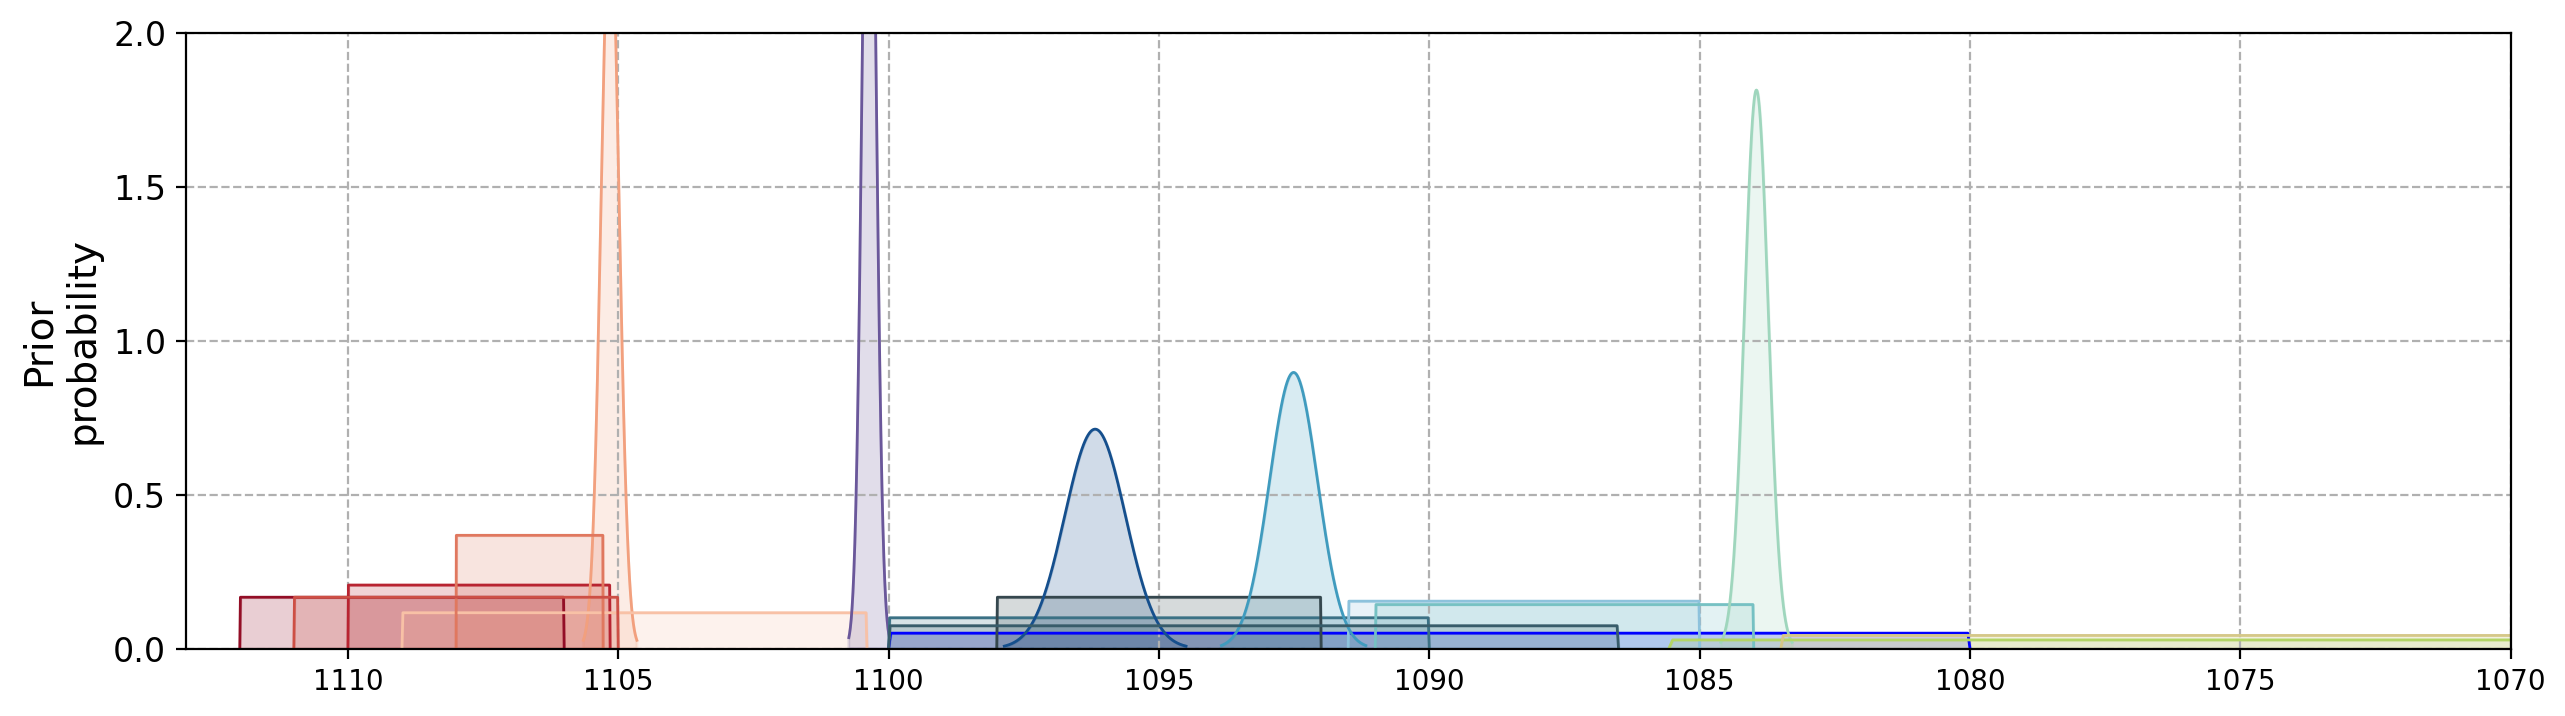

In [234]:
plt.figure(figsize = (15, 4))
for i in range(pole_means.shape[0]):
        
    max_y = 0
    if pole_means['GaussianOrUniform'][i] == 'uniform':
        x = np.linspace(pole_means['AgeLower'][i], pole_means['AgeUpper'][i], 500)
        y = np.zeros(500)
        y[(x< pole_means['AgeUpper'][i]) & (x>pole_means['AgeLower'][i])] = 1.0/(pole_means['AgeUpper'][i]-pole_means['AgeLower'][i])
        if max_y < max(y):
            max_y = max(y)

    else: 
        mu = pole_means['AgeNominal'][i]
        sigma = pole_means['Gaussian_2sigma'][i]/2

        x = np.linspace(mu-3*sigma,mu+3*sigma, 1000)
        y = st.norm.pdf(x, mu, sigma)
        if max_y < max(y):
            max_y = max(y)
    plt.plot(x, y, color = pole_means['color'][i], lw=1)
    plt.fill_between(x, y, color = pole_means['color'][i], alpha = 0.2)
plt.grid(1, ls='--')
plt.xlim(1070, 1113)
plt.ylim(0, 2)

plt.ylabel('Prior\nprobability', fontsize=14)
plt.yticks([0, 0.5, 1, 1.5, 2], fontsize=12)
plt.gca().invert_xaxis()
plt.show()


# overall site level data table

Grouping by paleopole name (dataframe), the site/VGP level data shoud include:
- Osler lower reversed
- Osler upper reversed
- Osler normal
- Mamainse lower reversed 1
- Mamainse lower reversed 2
- Mamainse lower normal
- Mamainse upper normal
- Grand Portage Basalts
- North Shore Volcanic Group (upper NE sequence)
- North Shore Volcanic Group (lower NW sequence)
- Schroeder-Lutsen Basalts
- Portage Lake Volcanics
- Lake Shore Traps
- Siemens Creek Volcanics
- Quebec Mine Member (Michipicoten Island)
- Michipicoten Island Formation

- Nonesuch Formation (we update the site level data associated with this formation to include both Henry 1977 data and Slotznick et al., 2023 data)
- Freda Formation

In [235]:
Keweenawan_track_sites = pd.concat([Osler_reverse_lower_site, 
                                        Osler_reverse_upper_site,
                                        Osler_normal_site, 
                                        MP_sites_lowerR1, 
                                        MP_sites_lowerR2,
                                        MP_sites_lower_normal, 
                                        MP_sites_upperN, 
                                        Grand_portage_site,
                                        NNEU_sites, 
                                        NSWU_sites, 
                                        SLB_sites, 
                                        PLV_sites,
                                        LST_sites, 
                                        Palmer1986_PM_reliable, 
                                        Palmer1987_QM_sites,
                                        Fairchild2017_MIF,
                                        Henry1977_Freda_data, 
                                        Slotznick2023_data
                                        ]).reset_index(drop=1)
Keweenawan_track_sites = Keweenawan_track_sites[['pole_name', 'age', 'age_high', 'age_low', 'age_unit', 'age_uncertainty',
                                                 'citations', 'dir_alpha95', 'dir_polarity',
                                                'dir_dec', 'dir_inc', 'dir_n_specimens', 'dir_n_samples', 'geologic_classes',
                                                'geologic_types', 'height', 'lat', 'lithologies', 'location', 'lon',
                                                'site', 'vgp_lat', 'vgp_lon', 'dir_k',
                                                'dir_tilt_correction',
                                                'dir_r','vgp_lat_rev', 'vgp_lon_rev',
                                                'vgp_dm', 'vgp_dp', 'f_nominal', 'f_sigma']]
Keweenawan_track_sites['dir_dec'] = Keweenawan_track_sites['dir_dec'].astype(np.float64)
Keweenawan_track_sites['dir_inc'] = Keweenawan_track_sites['dir_inc'].astype(np.float64)
Keweenawan_track_sites['lat'] = Keweenawan_track_sites['lat'].astype(np.float64)
Keweenawan_track_sites['lon'] = Keweenawan_track_sites['lon'].astype(np.float64)
Keweenawan_track_sites = ipmag.vgp_calc(Keweenawan_track_sites, tilt_correction='yes', site_lon='lon', site_lat='lat', dec_tc='dir_dec', inc_tc='dir_inc')
Keweenawan_track_sites.head()

,pole_name,age,age_high,age_low,age_unit,age_uncertainty,citations,dir_alpha95,dir_polarity,dir_dec,dir_inc,dir_n_specimens,dir_n_samples,geologic_classes,geologic_types,height,lat,lithologies,location,lon,site,vgp_lat,vgp_lon,dir_k,dir_tilt_correction,dir_r,vgp_lat_rev,vgp_lon_rev,vgp_dm,vgp_dp,f_nominal,f_sigma,paleolatitude
0,Osler reverse lower,1108.0,1110.0,1105.15,Ma,uniform,Swanson-Hysell et al. 2014,2.7,r,79.7,-70.5,7.0,7.0,Extrusive:Igneous,Lava Flow,11.8,48.8122,Basalt,Simpson Island,272.3380,SI1(11.8 to 26.4),-33.098356,49.588330,384.087791,NaN,NaN,33.098356,229.588330,NaN,NaN,NaN,NaN,-54.692457
1,Osler reverse lower,1108.0,1110.0,1105.15,Ma,uniform,Swanson-Hysell et al. 2014,6.4,r,74.1,-70.3,6.0,6.0,Extrusive:Igneous,Lava Flow,116.3,48.8062,Basalt,Simpson Island,272.3366,SI1(116.3 to 118.8),-30.447349,51.831739,79.752604,NaN,NaN,30.447349,231.831739,NaN,NaN,NaN,NaN,-54.393410
2,Osler reverse lower,1108.0,1110.0,1105.15,Ma,uniform,Swanson-Hysell et al. 2014,6.8,r,87.5,-68.9,5.0,5.0,Extrusive:Igneous,Lava Flow,119.7,48.8060,Basalt,Simpson Island,272.3366,SI1(119.7 to 122.1),-35.321456,43.912252,84.775087,NaN,NaN,35.321456,223.912252,NaN,NaN,NaN,NaN,-52.341346
3,Osler reverse lower,1108.0,1110.0,1105.15,Ma,uniform,Swanson-Hysell et al. 2014,4.9,r,75.7,-69.1,6.0,6.0,Extrusive:Igneous,Lava Flow,122.1,48.8058,Basalt,Simpson Island,272.3367,SI1(122.1 to 123.7),-29.952660,49.585495,136.054422,NaN,NaN,29.952660,229.585495,NaN,NaN,NaN,NaN,-52.630096
4,Osler reverse lower,1108.0,1110.0,1105.15,Ma,uniform,Swanson-Hysell et al. 2014,3.9,r,109.8,-66.8,7.0,7.0,Extrusive:Igneous,Lava Flow,28.3,48.8107,Basalt,Simpson Island,272.3377,SI1(28.3 to 29.2),-45.769076,30.954452,184.089415,NaN,NaN,45.769076,210.954452,NaN,NaN,NaN,NaN,-49.396782


In [239]:
Keweenawan_track_sites['Plon'] = None
Keweenawan_track_sites['Plat'] = None
Keweenawan_track_sites['Plon'] = np.where(Keweenawan_track_sites['dir_polarity']== 'n', Keweenawan_track_sites['vgp_lon'], Keweenawan_track_sites['vgp_lon_rev'])
Keweenawan_track_sites['Plon'] = Keweenawan_track_sites['Plon']%360
Keweenawan_track_sites['Plat'] = np.where(Keweenawan_track_sites['dir_polarity']== 'n', Keweenawan_track_sites['vgp_lat'], Keweenawan_track_sites['vgp_lat_rev'])
Keweenawan_track_sites.head()

,pole_name,age,age_high,age_low,age_unit,age_uncertainty,citations,dir_alpha95,dir_polarity,dir_dec,dir_inc,dir_n_specimens,dir_n_samples,geologic_classes,geologic_types,height,lat,lithologies,location,lon,site,vgp_lat,vgp_lon,dir_k,dir_tilt_correction,dir_r,vgp_lat_rev,vgp_lon_rev,vgp_dm,vgp_dp,f_nominal,f_sigma,paleolatitude,Plon,Plat
0,Osler reverse lower,1108.0,1110.0,1105.15,Ma,uniform,Swanson-Hysell et al. 2014,2.7,r,79.7,-70.5,7.0,7.0,Extrusive:Igneous,Lava Flow,11.8,48.8122,Basalt,Simpson Island,272.3380,SI1(11.8 to 26.4),-33.098356,49.588330,384.087791,NaN,NaN,33.098356,229.588330,NaN,NaN,NaN,NaN,-54.692457,229.588330,33.098356
1,Osler reverse lower,1108.0,1110.0,1105.15,Ma,uniform,Swanson-Hysell et al. 2014,6.4,r,74.1,-70.3,6.0,6.0,Extrusive:Igneous,Lava Flow,116.3,48.8062,Basalt,Simpson Island,272.3366,SI1(116.3 to 118.8),-30.447349,51.831739,79.752604,NaN,NaN,30.447349,231.831739,NaN,NaN,NaN,NaN,-54.393410,231.831739,30.447349
2,Osler reverse lower,1108.0,1110.0,1105.15,Ma,uniform,Swanson-Hysell et al. 2014,6.8,r,87.5,-68.9,5.0,5.0,Extrusive:Igneous,Lava Flow,119.7,48.8060,Basalt,Simpson Island,272.3366,SI1(119.7 to 122.1),-35.321456,43.912252,84.775087,NaN,NaN,35.321456,223.912252,NaN,NaN,NaN,NaN,-52.341346,223.912252,35.321456
3,Osler reverse lower,1108.0,1110.0,1105.15,Ma,uniform,Swanson-Hysell et al. 2014,4.9,r,75.7,-69.1,6.0,6.0,Extrusive:Igneous,Lava Flow,122.1,48.8058,Basalt,Simpson Island,272.3367,SI1(122.1 to 123.7),-29.952660,49.585495,136.054422,NaN,NaN,29.952660,229.585495,NaN,NaN,NaN,NaN,-52.630096,229.585495,29.952660
4,Osler reverse lower,1108.0,1110.0,1105.15,Ma,uniform,Swanson-Hysell et al. 2014,3.9,r,109.8,-66.8,7.0,7.0,Extrusive:Igneous,Lava Flow,28.3,48.8107,Basalt,Simpson Island,272.3377,SI1(28.3 to 29.2),-45.769076,30.954452,184.089415,NaN,NaN,45.769076,210.954452,NaN,NaN,NaN,NaN,-49.396782,210.954452,45.769076


In [240]:
Keweenawan_track_sites.to_csv('../data/pmag_compiled/Keweenawan_track_sites.csv', index=False)

In [46]:
Keweenawan_track_sites = pd.read_csv('../data/pmag_compiled/Keweenawan_track_sites.csv')
Keweenawan_track_sites_volcanic = Keweenawan_track_sites[~Keweenawan_track_sites['geologic_classes'].str.contains('Sedimentary')].reset_index(drop=1)
Keweenawan_track_sites_sedimentary = Keweenawan_track_sites[Keweenawan_track_sites['geologic_classes'].str.contains('Sedimentary')].reset_index(drop=1)

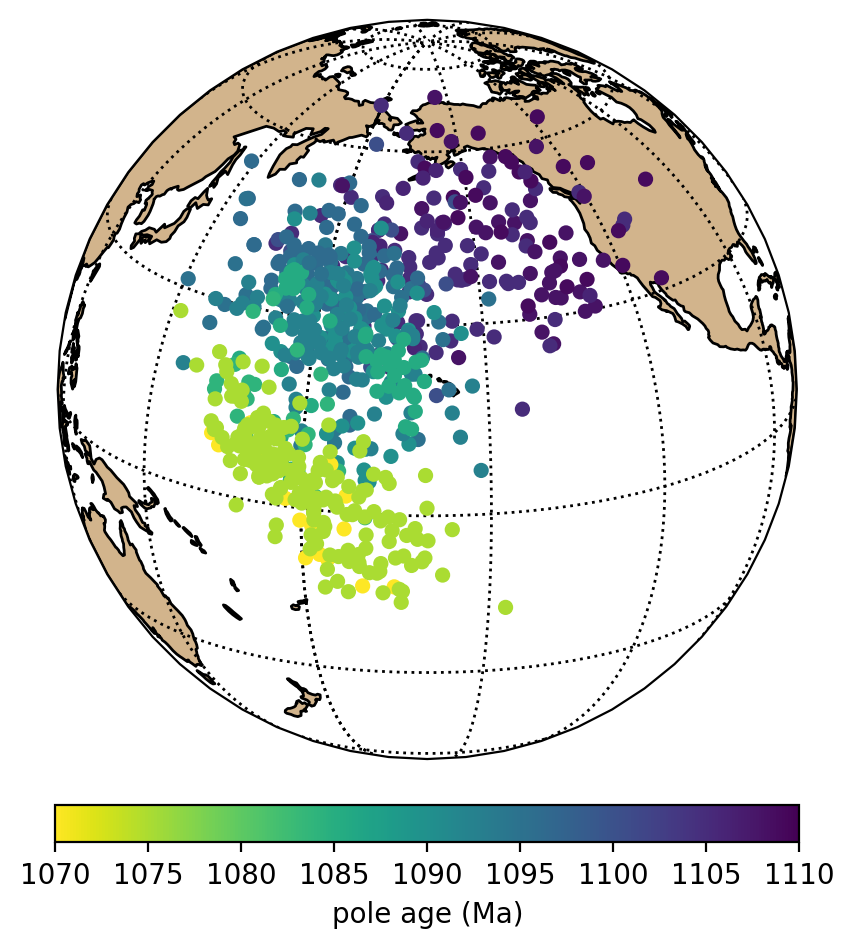

In [44]:
ax = ipmag.make_orthographic_map(200, 20, figsize=(6,6))
ipmag.plot_poles_colorbar(ax, Keweenawan_track_sites['Plon'], Keweenawan_track_sites['Plat'], 
                          np.zeros(Keweenawan_track_sites.shape[0]), Keweenawan_track_sites['age'], vmin=1070, vmax=1110, colormap='viridis_r', edgecolor=None, alpha=0.6, )

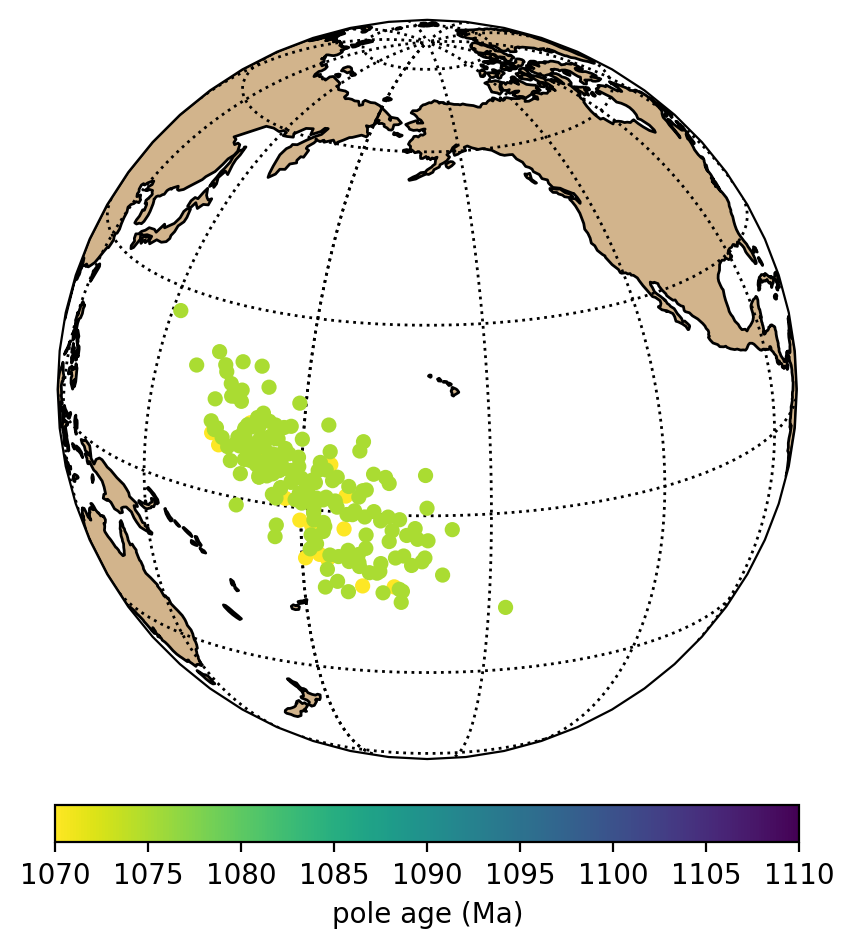

In [50]:
ax = ipmag.make_orthographic_map(200, 20, figsize=(6,6))
ipmag.plot_poles_colorbar(ax, Keweenawan_track_sites_sedimentary['Plon'], Keweenawan_track_sites_sedimentary['Plat'], 
                          np.zeros(Keweenawan_track_sites_sedimentary.shape[0]), Keweenawan_track_sites_sedimentary['age'], vmin=1070, vmax=1110, colormap='viridis_r', edgecolor=None, alpha=0.6)